<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/TeamProject_V2024_04_09_01_ADM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Review with Video https://www.youtube.com/watch?v=hpfQE0bTeA4

Done
* Correct Nodes lableing
* Auto Model Layers by parameter


TODO updates.
* Auto Nodes by input Parameter Size
* Use Kaggle Data.
* Only Pull Data with change in Ticker
* graph each stock



#Code Section

In [37]:
#pip install pandas_ta

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [39]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = 0
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [40]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicattors','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean',"elapsTime"]

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicattors':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time })


# Get Fields








# Model Fit Section

# Model Training

In [41]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
Ticker = ['ADM']
frame_days = [10,25,50,75,100]
LSTM_layers = [1,2,3,4,5,6]

#Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10]
#LSTM_layers = [1]


Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 30 models


In [42]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L1___________
Start Time:2024-04-30 06:38:38.682397
Epoch 1/30
122/122 - 3s - loss: 0.0051 - mae: 0.0564 - val_loss: 0.1566 - val_mae: 0.3439 - 3s/epoch - 27ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0030 - mae: 0.0461 - val_loss: 0.1002 - val_mae: 0.2572 - 818ms/epoch - 7ms/step
Epoch 3/30
122/122 - 1s - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0775 - val_mae: 0.2154 - 749ms/epoch - 6ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0040 - mae: 0.0541 - val_loss: 0.0553 - val_mae: 0.1744 - 715ms/epoch - 6ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0042 - mae: 0.0540 - val_loss: 0.0614 - val_mae: 0.1918 - 773ms/epoch - 6ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0688 - val_mae: 0.2144 - 778ms/epoch - 6ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0021 - mae: 0.0395 - val_loss: 0.0717 - val_mae: 0.2229 - 794ms/epoch - 7ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0018 - mae: 0.0363 - val_loss: 0.0730 - val_mae: 0.2266 - 802ms/epoch - 7ms/step
Epoch 9/30


[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L2___________
Start Time:2024-04-30 06:39:07.917633
Epoch 1/30
122/122 - 6s - loss: 0.0019 - mae: 0.0351 - val_loss: 0.0887 - val_mae: 0.2401 - 6s/epoch - 47ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0025 - mae: 0.0418 - val_loss: 0.0904 - val_mae: 0.2432 - 1s/epoch - 10ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0033 - mae: 0.0477 - val_loss: 0.1165 - val_mae: 0.2921 - 2s/epoch - 15ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0028 - mae: 0.0462 - val_loss: 0.1143 - val_mae: 0.2885 - 2s/epoch - 15ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0033 - mae: 0.0495 - val_loss: 0.1121 - val_mae: 0.2846 - 1s/epoch - 11ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0032 - mae: 0.0480 - val_loss: 0.1101 - val_mae: 0.2814 - 1s/epoch - 10ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0030 - mae: 0.0453 - val_loss: 0.1075 - val_mae: 0.2773 - 1s/epoch - 10ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0024 - mae: 0.0405 - val_loss: 0.1043 - val_mae: 0.2723 - 1s/epoch - 10ms/step
Epoch 9/30
122/122 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L3___________
Start Time:2024-04-30 06:40:36.320176
Epoch 1/30
122/122 - 9s - loss: 0.0026 - mae: 0.0406 - val_loss: 0.0968 - val_mae: 0.2524 - 9s/epoch - 73ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0044 - mae: 0.0553 - val_loss: 0.1276 - val_mae: 0.3066 - 2s/epoch - 20ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0046 - mae: 0.0565 - val_loss: 0.1281 - val_mae: 0.3077 - 2s/epoch - 18ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0057 - mae: 0.0626 - val_loss: 0.1257 - val_mae: 0.3043 - 2s/epoch - 14ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0052 - mae: 0.0593 - val_loss: 0.1185 - val_mae: 0.2933 - 2s/epoch - 14ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0042 - mae: 0.0544 - val_loss: 0.1167 - val_mae: 0.2910 - 2s/epoch - 14ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0033 - mae: 0.0477 - val_loss: 0.1131 - val_mae: 0.2863 - 2s/epoch - 14ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0020 - mae: 0.0368 - val_loss: 0.1080 - val_mae: 0.2790 - 2s/epoch - 14ms/step
Epoch 9/30
122/122 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L4___________
Start Time:2024-04-30 06:41:46.649474
Epoch 1/30
122/122 - 12s - loss: 0.0022 - mae: 0.0374 - val_loss: 0.1116 - val_mae: 0.2774 - 12s/epoch - 99ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0050 - mae: 0.0600 - val_loss: 0.1399 - val_mae: 0.3243 - 2s/epoch - 18ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0063 - mae: 0.0656 - val_loss: 0.1346 - val_mae: 0.3171 - 2s/epoch - 19ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0068 - mae: 0.0681 - val_loss: 0.1213 - val_mae: 0.2957 - 2s/epoch - 20ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0067 - mae: 0.0655 - val_loss: 0.1233 - val_mae: 0.2997 - 3s/epoch - 24ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0057 - mae: 0.0601 - val_loss: 0.1188 - val_mae: 0.2927 - 3s/epoch - 22ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0053 - mae: 0.0600 - val_loss: 0.1182 - val_mae: 0.2923 - 2s/epoch - 19ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0039 - mae: 0.0508 - val_loss: 0.1181 - val_mae: 0.2927 - 2s/epoch - 18ms/step
Epoch 9/30
122/122 - 2s

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L5___________
Start Time:2024-04-30 06:43:20.007107
Epoch 1/30
122/122 - 16s - loss: 0.0032 - mae: 0.0482 - val_loss: 0.1130 - val_mae: 0.2806 - 16s/epoch - 129ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0055 - mae: 0.0617 - val_loss: 0.1354 - val_mae: 0.3177 - 3s/epoch - 23ms/step
Epoch 3/30
122/122 - 3s - loss: 0.0072 - mae: 0.0699 - val_loss: 0.1296 - val_mae: 0.3088 - 3s/epoch - 23ms/step
Epoch 4/30
122/122 - 4s - loss: 0.0070 - mae: 0.0675 - val_loss: 0.1242 - val_mae: 0.3007 - 4s/epoch - 32ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0061 - mae: 0.0622 - val_loss: 0.1223 - val_mae: 0.2967 - 3s/epoch - 23ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0067 - mae: 0.0641 - val_loss: 0.1275 - val_mae: 0.3070 - 3s/epoch - 22ms/step
Epoch 7/30
122/122 - 3s - loss: 0.0055 - mae: 0.0596 - val_loss: 0.1188 - val_mae: 0.2943 - 3s/epoch - 22ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0051 - mae: 0.0582 - val_loss: 0.1194 - val_mae: 0.2952 - 3s/epoch - 25ms/step
Epoch 9/30
122/122 - 4

[*********************100%%**********************]  4 of 4 completed


___________ADM_F10_L6___________
Start Time:2024-04-30 06:45:56.358210
Epoch 1/30
122/122 - 19s - loss: 0.0024 - mae: 0.0402 - val_loss: 0.1141 - val_mae: 0.2831 - 19s/epoch - 155ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0056 - mae: 0.0630 - val_loss: 0.1382 - val_mae: 0.3219 - 3s/epoch - 27ms/step
Epoch 3/30
122/122 - 5s - loss: 0.0070 - mae: 0.0702 - val_loss: 0.1330 - val_mae: 0.3139 - 5s/epoch - 37ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0070 - mae: 0.0668 - val_loss: 0.1253 - val_mae: 0.3015 - 3s/epoch - 27ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0069 - mae: 0.0651 - val_loss: 0.1287 - val_mae: 0.3072 - 3s/epoch - 27ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0064 - mae: 0.0640 - val_loss: 0.1271 - val_mae: 0.3044 - 3s/epoch - 27ms/step
Epoch 7/30
122/122 - 5s - loss: 0.0067 - mae: 0.0645 - val_loss: 0.1296 - val_mae: 0.3085 - 5s/epoch - 38ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0065 - mae: 0.0639 - val_loss: 0.1323 - val_mae: 0.3130 - 3s/epoch - 27ms/step
Epoch 9/30
122/122 - 3

[*********************100%%**********************]  4 of 4 completed


___________ADM_F25_L1___________
Start Time:2024-04-30 06:48:06.352775
Epoch 1/30
121/121 - 4s - loss: 0.0064 - mae: 0.0661 - val_loss: 0.0783 - val_mae: 0.2200 - 4s/epoch - 34ms/step
Epoch 2/30
121/121 - 2s - loss: 0.0048 - mae: 0.0569 - val_loss: 0.0632 - val_mae: 0.1961 - 2s/epoch - 16ms/step
Epoch 3/30
121/121 - 2s - loss: 0.0035 - mae: 0.0481 - val_loss: 0.0687 - val_mae: 0.2109 - 2s/epoch - 16ms/step
Epoch 4/30
121/121 - 1s - loss: 0.0021 - mae: 0.0384 - val_loss: 0.0658 - val_mae: 0.2080 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 0.0016 - mae: 0.0337 - val_loss: 0.0633 - val_mae: 0.2044 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 0.0014 - mae: 0.0312 - val_loss: 0.0618 - val_mae: 0.2023 - 1s/epoch - 12ms/step
Epoch 7/30
121/121 - 1s - loss: 0.0013 - mae: 0.0296 - val_loss: 0.0610 - val_mae: 0.2014 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 0.0012 - mae: 0.0283 - val_loss: 0.0605 - val_mae: 0.2009 - 1s/epoch - 11ms/step
Epoch 9/30
121/121 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________ADM_F25_L2___________
Start Time:2024-04-30 06:49:32.015154
Epoch 1/30
121/121 - 7s - loss: 0.0044 - mae: 0.0539 - val_loss: 0.0887 - val_mae: 0.2356 - 7s/epoch - 58ms/step
Epoch 2/30
121/121 - 3s - loss: 0.0039 - mae: 0.0518 - val_loss: 0.1085 - val_mae: 0.2761 - 3s/epoch - 25ms/step
Epoch 3/30
121/121 - 3s - loss: 0.0036 - mae: 0.0512 - val_loss: 0.1181 - val_mae: 0.2948 - 3s/epoch - 26ms/step
Epoch 4/30
121/121 - 2s - loss: 0.0032 - mae: 0.0492 - val_loss: 0.1137 - val_mae: 0.2885 - 2s/epoch - 20ms/step
Epoch 5/30
121/121 - 2s - loss: 0.0031 - mae: 0.0482 - val_loss: 0.1085 - val_mae: 0.2810 - 2s/epoch - 20ms/step
Epoch 6/30
121/121 - 2s - loss: 0.0029 - mae: 0.0458 - val_loss: 0.1027 - val_mae: 0.2723 - 2s/epoch - 20ms/step
Epoch 7/30
121/121 - 3s - loss: 0.0023 - mae: 0.0410 - val_loss: 0.0964 - val_mae: 0.2624 - 3s/epoch - 24ms/step
Epoch 8/30
121/121 - 3s - loss: 0.0017 - mae: 0.0346 - val_loss: 0.0886 - val_mae: 0.2496 - 3s/epoch - 26ms/step
Epoch 9/30
121/121 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________ADM_F25_L3___________
Start Time:2024-04-30 06:50:59.761145
Epoch 1/30
121/121 - 11s - loss: 0.0025 - mae: 0.0407 - val_loss: 0.1153 - val_mae: 0.2848 - 11s/epoch - 95ms/step
Epoch 2/30
121/121 - 3s - loss: 0.0024 - mae: 0.0378 - val_loss: 0.0977 - val_mae: 0.2538 - 3s/epoch - 29ms/step
Epoch 3/30
121/121 - 5s - loss: 0.0046 - mae: 0.0557 - val_loss: 0.1275 - val_mae: 0.3069 - 5s/epoch - 39ms/step
Epoch 4/30
121/121 - 3s - loss: 0.0052 - mae: 0.0602 - val_loss: 0.1283 - val_mae: 0.3088 - 3s/epoch - 28ms/step
Epoch 5/30
121/121 - 3s - loss: 0.0056 - mae: 0.0617 - val_loss: 0.1256 - val_mae: 0.3051 - 3s/epoch - 28ms/step
Epoch 6/30
121/121 - 4s - loss: 0.0052 - mae: 0.0591 - val_loss: 0.1216 - val_mae: 0.2994 - 4s/epoch - 34ms/step
Epoch 7/30
121/121 - 4s - loss: 0.0044 - mae: 0.0548 - val_loss: 0.1179 - val_mae: 0.2938 - 4s/epoch - 34ms/step
Epoch 8/30
121/121 - 3s - loss: 0.0036 - mae: 0.0495 - val_loss: 0.1151 - val_mae: 0.2897 - 3s/epoch - 28ms/step
Epoch 9/30
121/121 - 3s

[*********************100%%**********************]  4 of 4 completed


___________ADM_F25_L4___________
Start Time:2024-04-30 06:53:08.148291
Epoch 1/30
121/121 - 15s - loss: 0.0012 - mae: 0.0275 - val_loss: 0.1633 - val_mae: 0.3548 - 15s/epoch - 121ms/step
Epoch 2/30
121/121 - 5s - loss: 0.0036 - mae: 0.0500 - val_loss: 0.1227 - val_mae: 0.2965 - 5s/epoch - 37ms/step
Epoch 3/30
121/121 - 5s - loss: 0.0046 - mae: 0.0554 - val_loss: 0.1384 - val_mae: 0.3222 - 5s/epoch - 43ms/step
Epoch 4/30
121/121 - 5s - loss: 0.0066 - mae: 0.0679 - val_loss: 0.1317 - val_mae: 0.3126 - 5s/epoch - 42ms/step
Epoch 5/30
121/121 - 4s - loss: 0.0069 - mae: 0.0663 - val_loss: 0.1206 - val_mae: 0.2948 - 4s/epoch - 37ms/step
Epoch 6/30
121/121 - 6s - loss: 0.0070 - mae: 0.0655 - val_loss: 0.1230 - val_mae: 0.2990 - 6s/epoch - 48ms/step
Epoch 7/30
121/121 - 4s - loss: 0.0065 - mae: 0.0633 - val_loss: 0.1222 - val_mae: 0.2978 - 4s/epoch - 37ms/step
Epoch 8/30
121/121 - 4s - loss: 0.0056 - mae: 0.0589 - val_loss: 0.1194 - val_mae: 0.2940 - 4s/epoch - 36ms/step
Epoch 9/30
121/121 - 6

[*********************100%%**********************]  4 of 4 completed


___________ADM_F25_L5___________
Start Time:2024-04-30 06:55:50.440645
Epoch 1/30
121/121 - 18s - loss: 0.0015 - mae: 0.0299 - val_loss: 0.1652 - val_mae: 0.3606 - 18s/epoch - 146ms/step
Epoch 2/30
121/121 - 6s - loss: 0.0025 - mae: 0.0399 - val_loss: 0.1192 - val_mae: 0.2900 - 6s/epoch - 47ms/step
Epoch 3/30
121/121 - 7s - loss: 0.0053 - mae: 0.0608 - val_loss: 0.1403 - val_mae: 0.3255 - 7s/epoch - 58ms/step
Epoch 4/30
121/121 - 6s - loss: 0.0053 - mae: 0.0601 - val_loss: 0.1359 - val_mae: 0.3185 - 6s/epoch - 47ms/step
Epoch 5/30
121/121 - 7s - loss: 0.0061 - mae: 0.0633 - val_loss: 0.1317 - val_mae: 0.3124 - 7s/epoch - 58ms/step
Epoch 6/30
121/121 - 6s - loss: 0.0068 - mae: 0.0646 - val_loss: 0.1221 - val_mae: 0.2973 - 6s/epoch - 48ms/step
Epoch 7/30
121/121 - 8s - loss: 0.0059 - mae: 0.0630 - val_loss: 0.1288 - val_mae: 0.3075 - 8s/epoch - 67ms/step
Epoch 8/30
121/121 - 6s - loss: 0.0067 - mae: 0.0643 - val_loss: 0.1299 - val_mae: 0.3096 - 6s/epoch - 48ms/step
Epoch 9/30
121/121 - 7

[*********************100%%**********************]  4 of 4 completed


___________ADM_F25_L6___________
Start Time:2024-04-30 06:59:25.117118
Epoch 1/30
121/121 - 22s - loss: 0.0018 - mae: 0.0325 - val_loss: 0.1621 - val_mae: 0.3556 - 22s/epoch - 185ms/step
Epoch 2/30
121/121 - 8s - loss: 0.0043 - mae: 0.0567 - val_loss: 0.1311 - val_mae: 0.3113 - 8s/epoch - 66ms/step
Epoch 3/30
121/121 - 7s - loss: 0.0054 - mae: 0.0602 - val_loss: 0.1375 - val_mae: 0.3203 - 7s/epoch - 56ms/step
Epoch 4/30
121/121 - 8s - loss: 0.0072 - mae: 0.0689 - val_loss: 0.1311 - val_mae: 0.3115 - 8s/epoch - 67ms/step
Epoch 5/30
121/121 - 7s - loss: 0.0069 - mae: 0.0652 - val_loss: 0.1262 - val_mae: 0.3036 - 7s/epoch - 56ms/step
Epoch 6/30
121/121 - 8s - loss: 0.0069 - mae: 0.0649 - val_loss: 0.1291 - val_mae: 0.3082 - 8s/epoch - 69ms/step
Epoch 7/30
121/121 - 7s - loss: 0.0066 - mae: 0.0637 - val_loss: 0.1313 - val_mae: 0.3118 - 7s/epoch - 56ms/step
Epoch 8/30
121/121 - 8s - loss: 0.0064 - mae: 0.0630 - val_loss: 0.1316 - val_mae: 0.3122 - 8s/epoch - 66ms/step
Epoch 9/30
121/121 - 7

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L1___________
Start Time:2024-04-30 07:04:01.783965
Epoch 1/30
120/120 - 5s - loss: 0.0061 - mae: 0.0631 - val_loss: 0.0601 - val_mae: 0.2036 - 5s/epoch - 40ms/step
Epoch 2/30
120/120 - 3s - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0663 - val_mae: 0.2206 - 3s/epoch - 26ms/step
Epoch 3/30
120/120 - 2s - loss: 8.9692e-04 - mae: 0.0236 - val_loss: 0.0564 - val_mae: 0.2002 - 2s/epoch - 20ms/step
Epoch 4/30
120/120 - 2s - loss: 6.3697e-04 - mae: 0.0196 - val_loss: 0.0557 - val_mae: 0.1982 - 2s/epoch - 18ms/step
Epoch 5/30
120/120 - 2s - loss: 5.2978e-04 - mae: 0.0177 - val_loss: 0.0553 - val_mae: 0.1962 - 2s/epoch - 18ms/step
Epoch 6/30
120/120 - 2s - loss: 4.6349e-04 - mae: 0.0165 - val_loss: 0.0559 - val_mae: 0.1969 - 2s/epoch - 18ms/step
Epoch 7/30
120/120 - 3s - loss: 4.2544e-04 - mae: 0.0157 - val_loss: 0.0569 - val_mae: 0.1985 - 3s/epoch - 26ms/step
Epoch 8/30
120/120 - 3s - loss: 3.9955e-04 - mae: 0.0152 - val_loss: 0.0576 - val_mae: 0.1998 - 3s/epoch - 24ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L2___________
Start Time:2024-04-30 07:05:27.715097
Epoch 1/30
120/120 - 10s - loss: 0.0043 - mae: 0.0469 - val_loss: 0.1514 - val_mae: 0.3392 - 10s/epoch - 83ms/step
Epoch 2/30
120/120 - 5s - loss: 0.0041 - mae: 0.0517 - val_loss: 0.1000 - val_mae: 0.2583 - 5s/epoch - 38ms/step
Epoch 3/30
120/120 - 5s - loss: 0.0046 - mae: 0.0537 - val_loss: 0.1204 - val_mae: 0.2985 - 5s/epoch - 42ms/step
Epoch 4/30
120/120 - 4s - loss: 0.0036 - mae: 0.0495 - val_loss: 0.1159 - val_mae: 0.2922 - 4s/epoch - 35ms/step
Epoch 5/30
120/120 - 5s - loss: 0.0029 - mae: 0.0451 - val_loss: 0.1132 - val_mae: 0.2886 - 5s/epoch - 43ms/step
Epoch 6/30
120/120 - 6s - loss: 0.0023 - mae: 0.0403 - val_loss: 0.1033 - val_mae: 0.2730 - 6s/epoch - 50ms/step
Epoch 7/30
120/120 - 4s - loss: 0.0014 - mae: 0.0303 - val_loss: 0.0900 - val_mae: 0.2507 - 4s/epoch - 34ms/step
Epoch 8/30
120/120 - 4s - loss: 0.0010 - mae: 0.0255 - val_loss: 0.0764 - val_mae: 0.2252 - 4s/epoch - 35ms/step
Epoch 9/30
120/120 - 5s

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L3___________
Start Time:2024-04-30 07:07:55.652339
Epoch 1/30
120/120 - 14s - loss: 0.0020 - mae: 0.0357 - val_loss: 0.1339 - val_mae: 0.3186 - 14s/epoch - 119ms/step
Epoch 2/30
120/120 - 8s - loss: 0.0026 - mae: 0.0410 - val_loss: 0.1069 - val_mae: 0.2719 - 8s/epoch - 65ms/step
Epoch 3/30
120/120 - 7s - loss: 0.0044 - mae: 0.0545 - val_loss: 0.1272 - val_mae: 0.3082 - 7s/epoch - 55ms/step
Epoch 4/30
120/120 - 8s - loss: 0.0042 - mae: 0.0549 - val_loss: 0.1267 - val_mae: 0.3077 - 8s/epoch - 65ms/step
Epoch 5/30
120/120 - 7s - loss: 0.0052 - mae: 0.0589 - val_loss: 0.1255 - val_mae: 0.3065 - 7s/epoch - 55ms/step
Epoch 6/30
120/120 - 8s - loss: 0.0049 - mae: 0.0568 - val_loss: 0.1210 - val_mae: 0.3002 - 8s/epoch - 65ms/step
Epoch 7/30
120/120 - 7s - loss: 0.0039 - mae: 0.0510 - val_loss: 0.1173 - val_mae: 0.2943 - 7s/epoch - 55ms/step
Epoch 8/30
120/120 - 8s - loss: 0.0034 - mae: 0.0476 - val_loss: 0.1157 - val_mae: 0.2922 - 8s/epoch - 65ms/step
Epoch 9/30
120/120 - 6

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L4___________
Start Time:2024-04-30 07:11:39.093578
Epoch 1/30
120/120 - 21s - loss: 0.0015 - mae: 0.0288 - val_loss: 0.1644 - val_mae: 0.3583 - 21s/epoch - 177ms/step
Epoch 2/30
120/120 - 9s - loss: 0.0022 - mae: 0.0359 - val_loss: 0.1230 - val_mae: 0.2966 - 9s/epoch - 77ms/step
Epoch 3/30
120/120 - 9s - loss: 0.0046 - mae: 0.0556 - val_loss: 0.1341 - val_mae: 0.3171 - 9s/epoch - 72ms/step
Epoch 4/30
120/120 - 10s - loss: 0.0054 - mae: 0.0587 - val_loss: 0.1370 - val_mae: 0.3222 - 10s/epoch - 82ms/step
Epoch 5/30
120/120 - 10s - loss: 0.0063 - mae: 0.0648 - val_loss: 0.1348 - val_mae: 0.3189 - 10s/epoch - 82ms/step
Epoch 6/30
120/120 - 8s - loss: 0.0063 - mae: 0.0624 - val_loss: 0.1218 - val_mae: 0.2982 - 8s/epoch - 70ms/step
Epoch 7/30
120/120 - 10s - loss: 0.0064 - mae: 0.0621 - val_loss: 0.1205 - val_mae: 0.2964 - 10s/epoch - 81ms/step
Epoch 8/30
120/120 - 10s - loss: 0.0059 - mae: 0.0595 - val_loss: 0.1230 - val_mae: 0.3011 - 10s/epoch - 81ms/step
Epoch 9/30
120

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L5___________
Start Time:2024-04-30 07:17:13.707187
Epoch 1/30
120/120 - 24s - loss: 0.0014 - mae: 0.0289 - val_loss: 0.1748 - val_mae: 0.3701 - 24s/epoch - 202ms/step
Epoch 2/30
120/120 - 12s - loss: 0.0032 - mae: 0.0439 - val_loss: 0.1244 - val_mae: 0.3002 - 12s/epoch - 97ms/step
Epoch 3/30
120/120 - 12s - loss: 0.0053 - mae: 0.0595 - val_loss: 0.1386 - val_mae: 0.3244 - 12s/epoch - 96ms/step
Epoch 4/30
120/120 - 11s - loss: 0.0060 - mae: 0.0624 - val_loss: 0.1323 - val_mae: 0.3146 - 11s/epoch - 95ms/step
Epoch 5/30
120/120 - 10s - loss: 0.0068 - mae: 0.0657 - val_loss: 0.1242 - val_mae: 0.3015 - 10s/epoch - 87ms/step
Epoch 6/30
120/120 - 12s - loss: 0.0069 - mae: 0.0651 - val_loss: 0.1273 - val_mae: 0.3072 - 12s/epoch - 101ms/step
Epoch 7/30
120/120 - 12s - loss: 0.0057 - mae: 0.0619 - val_loss: 0.1333 - val_mae: 0.3159 - 12s/epoch - 101ms/step
Epoch 8/30
120/120 - 12s - loss: 0.0064 - mae: 0.0619 - val_loss: 0.1290 - val_mae: 0.3093 - 12s/epoch - 101ms/step
Epoch

[*********************100%%**********************]  4 of 4 completed


___________ADM_F50_L6___________
Start Time:2024-04-30 07:23:50.047608
Epoch 1/30
120/120 - 29s - loss: 0.0016 - mae: 0.0295 - val_loss: 0.1681 - val_mae: 0.3654 - 29s/epoch - 243ms/step
Epoch 2/30
120/120 - 16s - loss: 0.0042 - mae: 0.0552 - val_loss: 0.1371 - val_mae: 0.3220 - 16s/epoch - 132ms/step
Epoch 3/30
120/120 - 14s - loss: 0.0054 - mae: 0.0597 - val_loss: 0.1358 - val_mae: 0.3200 - 14s/epoch - 117ms/step
Epoch 4/30
120/120 - 14s - loss: 0.0063 - mae: 0.0649 - val_loss: 0.1287 - val_mae: 0.3087 - 14s/epoch - 117ms/step
Epoch 5/30
120/120 - 14s - loss: 0.0071 - mae: 0.0664 - val_loss: 0.1283 - val_mae: 0.3083 - 14s/epoch - 118ms/step
Epoch 6/30
120/120 - 14s - loss: 0.0068 - mae: 0.0641 - val_loss: 0.1279 - val_mae: 0.3074 - 14s/epoch - 117ms/step
Epoch 7/30
120/120 - 14s - loss: 0.0066 - mae: 0.0628 - val_loss: 0.1303 - val_mae: 0.3114 - 14s/epoch - 117ms/step
Epoch 8/30
120/120 - 14s - loss: 0.0064 - mae: 0.0623 - val_loss: 0.1313 - val_mae: 0.3129 - 14s/epoch - 117ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________ADM_F75_L1___________
Start Time:2024-04-30 07:31:26.210446
Epoch 1/30
119/119 - 7s - loss: 0.0044 - mae: 0.0549 - val_loss: 0.0610 - val_mae: 0.1987 - 7s/epoch - 57ms/step
Epoch 2/30
119/119 - 3s - loss: 0.0041 - mae: 0.0517 - val_loss: 0.0487 - val_mae: 0.1674 - 3s/epoch - 24ms/step
Epoch 3/30
119/119 - 3s - loss: 0.0046 - mae: 0.0534 - val_loss: 0.0607 - val_mae: 0.1953 - 3s/epoch - 24ms/step
Epoch 4/30
119/119 - 3s - loss: 0.0033 - mae: 0.0471 - val_loss: 0.0775 - val_mae: 0.2336 - 3s/epoch - 23ms/step
Epoch 5/30
119/119 - 4s - loss: 0.0021 - mae: 0.0393 - val_loss: 0.0801 - val_mae: 0.2397 - 4s/epoch - 31ms/step
Epoch 6/30
119/119 - 3s - loss: 0.0017 - mae: 0.0353 - val_loss: 0.0801 - val_mae: 0.2401 - 3s/epoch - 28ms/step
Epoch 7/30
119/119 - 3s - loss: 0.0015 - mae: 0.0328 - val_loss: 0.0787 - val_mae: 0.2380 - 3s/epoch - 24ms/step
Epoch 8/30
119/119 - 3s - loss: 0.0013 - mae: 0.0307 - val_loss: 0.0763 - val_mae: 0.2341 - 3s/epoch - 24ms/step
Epoch 9/30
119/119 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________ADM_F75_L2___________
Start Time:2024-04-30 07:33:52.068695
Epoch 1/30
119/119 - 13s - loss: 0.0037 - mae: 0.0459 - val_loss: 0.1397 - val_mae: 0.3262 - 13s/epoch - 110ms/step
Epoch 2/30
119/119 - 7s - loss: 0.0029 - mae: 0.0430 - val_loss: 0.0921 - val_mae: 0.2455 - 7s/epoch - 60ms/step
Epoch 3/30
119/119 - 6s - loss: 0.0047 - mae: 0.0538 - val_loss: 0.1103 - val_mae: 0.2817 - 6s/epoch - 48ms/step
Epoch 4/30
119/119 - 7s - loss: 0.0045 - mae: 0.0540 - val_loss: 0.1144 - val_mae: 0.2906 - 7s/epoch - 60ms/step
Epoch 5/30
119/119 - 6s - loss: 0.0041 - mae: 0.0525 - val_loss: 0.1078 - val_mae: 0.2816 - 6s/epoch - 50ms/step
Epoch 6/30
119/119 - 7s - loss: 0.0033 - mae: 0.0470 - val_loss: 0.1024 - val_mae: 0.2736 - 7s/epoch - 57ms/step
Epoch 7/30
119/119 - 6s - loss: 0.0027 - mae: 0.0427 - val_loss: 0.0931 - val_mae: 0.2584 - 6s/epoch - 53ms/step
Epoch 8/30
119/119 - 7s - loss: 0.0018 - mae: 0.0344 - val_loss: 0.0818 - val_mae: 0.2383 - 7s/epoch - 56ms/step
Epoch 9/30
119/119 - 7

[*********************100%%**********************]  4 of 4 completed


___________ADM_F75_L3___________
Start Time:2024-04-30 07:37:22.958670
Epoch 1/30
119/119 - 17s - loss: 0.0013 - mae: 0.0284 - val_loss: 0.1323 - val_mae: 0.3144 - 17s/epoch - 147ms/step
Epoch 2/30
119/119 - 10s - loss: 0.0031 - mae: 0.0455 - val_loss: 0.0955 - val_mae: 0.2533 - 10s/epoch - 86ms/step
Epoch 3/30
119/119 - 10s - loss: 0.0044 - mae: 0.0524 - val_loss: 0.1221 - val_mae: 0.2997 - 10s/epoch - 80ms/step
Epoch 4/30
119/119 - 9s - loss: 0.0052 - mae: 0.0575 - val_loss: 0.1268 - val_mae: 0.3095 - 9s/epoch - 79ms/step
Epoch 5/30
119/119 - 10s - loss: 0.0047 - mae: 0.0560 - val_loss: 0.1247 - val_mae: 0.3066 - 10s/epoch - 85ms/step
Epoch 6/30
119/119 - 12s - loss: 0.0045 - mae: 0.0539 - val_loss: 0.1182 - val_mae: 0.2973 - 12s/epoch - 97ms/step
Epoch 7/30
119/119 - 10s - loss: 0.0032 - mae: 0.0456 - val_loss: 0.1145 - val_mae: 0.2916 - 10s/epoch - 81ms/step
Epoch 8/30
119/119 - 9s - loss: 0.0026 - mae: 0.0413 - val_loss: 0.1093 - val_mae: 0.2830 - 9s/epoch - 79ms/step
Epoch 9/30
1

[*********************100%%**********************]  4 of 4 completed


___________ADM_F75_L4___________
Start Time:2024-04-30 07:42:53.100711
Epoch 1/30
119/119 - 25s - loss: 0.0018 - mae: 0.0324 - val_loss: 0.1650 - val_mae: 0.3599 - 25s/epoch - 208ms/step
Epoch 2/30
119/119 - 13s - loss: 0.0037 - mae: 0.0513 - val_loss: 0.1158 - val_mae: 0.2882 - 13s/epoch - 108ms/step
Epoch 3/30
119/119 - 14s - loss: 0.0047 - mae: 0.0536 - val_loss: 0.1332 - val_mae: 0.3182 - 14s/epoch - 113ms/step
Epoch 4/30
119/119 - 14s - loss: 0.0055 - mae: 0.0596 - val_loss: 0.1327 - val_mae: 0.3175 - 14s/epoch - 114ms/step
Epoch 5/30
119/119 - 14s - loss: 0.0056 - mae: 0.0605 - val_loss: 0.1312 - val_mae: 0.3156 - 14s/epoch - 115ms/step
Epoch 6/30
119/119 - 14s - loss: 0.0048 - mae: 0.0560 - val_loss: 0.1242 - val_mae: 0.3053 - 14s/epoch - 114ms/step
Epoch 7/30
119/119 - 14s - loss: 0.0047 - mae: 0.0555 - val_loss: 0.1192 - val_mae: 0.2985 - 14s/epoch - 116ms/step
Epoch 8/30
119/119 - 14s - loss: 0.0038 - mae: 0.0496 - val_loss: 0.1105 - val_mae: 0.2866 - 14s/epoch - 115ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________ADM_F75_L5___________
Start Time:2024-04-30 07:50:27.789721
Epoch 1/30
119/119 - 28s - loss: 0.0014 - mae: 0.0281 - val_loss: 0.1715 - val_mae: 0.3697 - 28s/epoch - 239ms/step
Epoch 2/30
119/119 - 16s - loss: 0.0040 - mae: 0.0527 - val_loss: 0.1235 - val_mae: 0.3004 - 16s/epoch - 138ms/step
Epoch 3/30
119/119 - 16s - loss: 0.0057 - mae: 0.0602 - val_loss: 0.1369 - val_mae: 0.3221 - 16s/epoch - 137ms/step
Epoch 4/30
119/119 - 17s - loss: 0.0059 - mae: 0.0618 - val_loss: 0.1305 - val_mae: 0.3130 - 17s/epoch - 140ms/step
Epoch 5/30
119/119 - 16s - loss: 0.0066 - mae: 0.0632 - val_loss: 0.1234 - val_mae: 0.3014 - 16s/epoch - 135ms/step
Epoch 6/30
119/119 - 18s - loss: 0.0066 - mae: 0.0629 - val_loss: 0.1291 - val_mae: 0.3117 - 18s/epoch - 149ms/step
Epoch 7/30
119/119 - 16s - loss: 0.0046 - mae: 0.0516 - val_loss: 0.1372 - val_mae: 0.3228 - 16s/epoch - 138ms/step
Epoch 8/30
119/119 - 17s - loss: 0.0056 - mae: 0.0604 - val_loss: 0.1345 - val_mae: 0.3187 - 17s/epoch - 140ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________ADM_F75_L6___________
Start Time:2024-04-30 07:59:04.041389
Epoch 1/30
119/119 - 33s - loss: 0.0013 - mae: 0.0274 - val_loss: 0.1777 - val_mae: 0.3783 - 33s/epoch - 278ms/step
Epoch 2/30
119/119 - 20s - loss: 0.0045 - mae: 0.0561 - val_loss: 0.1312 - val_mae: 0.3134 - 20s/epoch - 171ms/step
Epoch 3/30
119/119 - 19s - loss: 0.0055 - mae: 0.0591 - val_loss: 0.1409 - val_mae: 0.3287 - 19s/epoch - 159ms/step
Epoch 4/30
119/119 - 21s - loss: 0.0062 - mae: 0.0646 - val_loss: 0.1344 - val_mae: 0.3187 - 21s/epoch - 174ms/step
Epoch 5/30
119/119 - 19s - loss: 0.0064 - mae: 0.0620 - val_loss: 0.1277 - val_mae: 0.3080 - 19s/epoch - 159ms/step
Epoch 6/30
119/119 - 21s - loss: 0.0065 - mae: 0.0623 - val_loss: 0.1308 - val_mae: 0.3131 - 21s/epoch - 175ms/step
Epoch 7/30
119/119 - 20s - loss: 0.0062 - mae: 0.0608 - val_loss: 0.1283 - val_mae: 0.3089 - 20s/epoch - 172ms/step
Epoch 8/30
119/119 - 21s - loss: 0.0063 - mae: 0.0616 - val_loss: 0.1341 - val_mae: 0.3182 - 21s/epoch - 177ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________ADM_F100_L1___________
Start Time:2024-04-30 08:09:44.937860
Epoch 1/30
117/117 - 7s - loss: 0.0026 - mae: 0.0410 - val_loss: 0.0998 - val_mae: 0.2598 - 7s/epoch - 63ms/step
Epoch 2/30
117/117 - 5s - loss: 0.0037 - mae: 0.0479 - val_loss: 0.0898 - val_mae: 0.2461 - 5s/epoch - 44ms/step
Epoch 3/30
117/117 - 4s - loss: 0.0038 - mae: 0.0505 - val_loss: 0.0638 - val_mae: 0.1968 - 4s/epoch - 33ms/step
Epoch 4/30
117/117 - 4s - loss: 0.0036 - mae: 0.0489 - val_loss: 0.0925 - val_mae: 0.2584 - 4s/epoch - 32ms/step
Epoch 5/30
117/117 - 5s - loss: 0.0024 - mae: 0.0411 - val_loss: 0.0929 - val_mae: 0.2602 - 5s/epoch - 42ms/step
Epoch 6/30
117/117 - 4s - loss: 0.0019 - mae: 0.0365 - val_loss: 0.0894 - val_mae: 0.2544 - 4s/epoch - 34ms/step
Epoch 7/30
117/117 - 3s - loss: 0.0016 - mae: 0.0337 - val_loss: 0.0844 - val_mae: 0.2461 - 3s/epoch - 30ms/step
Epoch 8/30
117/117 - 4s - loss: 0.0014 - mae: 0.0305 - val_loss: 0.0778 - val_mae: 0.2348 - 4s/epoch - 30ms/step
Epoch 9/30
117/117 - 5s 

[*********************100%%**********************]  4 of 4 completed


___________ADM_F100_L2___________
Start Time:2024-04-30 08:11:57.327013
Epoch 1/30
117/117 - 15s - loss: 0.0047 - mae: 0.0564 - val_loss: 0.0993 - val_mae: 0.2576 - 15s/epoch - 125ms/step
Epoch 2/30
117/117 - 8s - loss: 0.0044 - mae: 0.0542 - val_loss: 0.1086 - val_mae: 0.2812 - 8s/epoch - 72ms/step
Epoch 3/30
117/117 - 9s - loss: 0.0038 - mae: 0.0508 - val_loss: 0.1078 - val_mae: 0.2843 - 9s/epoch - 76ms/step
Epoch 4/30
117/117 - 7s - loss: 0.0034 - mae: 0.0494 - val_loss: 0.1012 - val_mae: 0.2749 - 7s/epoch - 63ms/step
Epoch 5/30
117/117 - 9s - loss: 0.0028 - mae: 0.0445 - val_loss: 0.0923 - val_mae: 0.2608 - 9s/epoch - 76ms/step
Epoch 6/30
117/117 - 8s - loss: 0.0025 - mae: 0.0413 - val_loss: 0.0819 - val_mae: 0.2428 - 8s/epoch - 72ms/step
Epoch 7/30
117/117 - 8s - loss: 0.0019 - mae: 0.0354 - val_loss: 0.0695 - val_mae: 0.2194 - 8s/epoch - 65ms/step
Epoch 8/30
117/117 - 9s - loss: 0.0013 - mae: 0.0281 - val_loss: 0.0559 - val_mae: 0.1899 - 9s/epoch - 76ms/step
Epoch 9/30
117/117 - 

[*********************100%%**********************]  4 of 4 completed


___________ADM_F100_L3___________
Start Time:2024-04-30 08:16:26.645652
Epoch 1/30
117/117 - 21s - loss: 0.0021 - mae: 0.0357 - val_loss: 0.1340 - val_mae: 0.3220 - 21s/epoch - 182ms/step
Epoch 2/30
117/117 - 13s - loss: 0.0023 - mae: 0.0369 - val_loss: 0.1075 - val_mae: 0.2746 - 13s/epoch - 112ms/step
Epoch 3/30
117/117 - 13s - loss: 0.0043 - mae: 0.0516 - val_loss: 0.1189 - val_mae: 0.2964 - 13s/epoch - 114ms/step
Epoch 4/30
117/117 - 13s - loss: 0.0048 - mae: 0.0577 - val_loss: 0.1301 - val_mae: 0.3147 - 13s/epoch - 108ms/step
Epoch 5/30
117/117 - 13s - loss: 0.0051 - mae: 0.0576 - val_loss: 0.1273 - val_mae: 0.3112 - 13s/epoch - 107ms/step
Epoch 6/30
117/117 - 12s - loss: 0.0049 - mae: 0.0565 - val_loss: 0.1236 - val_mae: 0.3061 - 12s/epoch - 106ms/step
Epoch 7/30
117/117 - 12s - loss: 0.0047 - mae: 0.0547 - val_loss: 0.1177 - val_mae: 0.2975 - 12s/epoch - 100ms/step
Epoch 8/30
117/117 - 13s - loss: 0.0039 - mae: 0.0501 - val_loss: 0.1143 - val_mae: 0.2923 - 13s/epoch - 108ms/step


[*********************100%%**********************]  4 of 4 completed


___________ADM_F100_L4___________
Start Time:2024-04-30 08:23:06.758279
Epoch 1/30
117/117 - 28s - loss: 0.0015 - mae: 0.0294 - val_loss: 0.1612 - val_mae: 0.3565 - 28s/epoch - 237ms/step
Epoch 2/30
117/117 - 16s - loss: 0.0028 - mae: 0.0407 - val_loss: 0.1350 - val_mae: 0.3199 - 16s/epoch - 141ms/step
Epoch 3/30
117/117 - 18s - loss: 0.0044 - mae: 0.0540 - val_loss: 0.1371 - val_mae: 0.3241 - 18s/epoch - 155ms/step
Epoch 4/30
117/117 - 17s - loss: 0.0046 - mae: 0.0543 - val_loss: 0.1365 - val_mae: 0.3237 - 17s/epoch - 141ms/step
Epoch 5/30
117/117 - 18s - loss: 0.0054 - mae: 0.0607 - val_loss: 0.1361 - val_mae: 0.3231 - 18s/epoch - 154ms/step
Epoch 6/30
117/117 - 17s - loss: 0.0054 - mae: 0.0579 - val_loss: 0.1245 - val_mae: 0.3055 - 17s/epoch - 142ms/step
Epoch 7/30
117/117 - 17s - loss: 0.0050 - mae: 0.0565 - val_loss: 0.1226 - val_mae: 0.3027 - 17s/epoch - 142ms/step
Epoch 8/30
117/117 - 17s - loss: 0.0051 - mae: 0.0583 - val_loss: 0.1197 - val_mae: 0.2996 - 17s/epoch - 141ms/step


[*********************100%%**********************]  4 of 4 completed


___________ADM_F100_L5___________
Start Time:2024-04-30 08:32:40.513842
Epoch 1/30
117/117 - 35s - loss: 0.0013 - mae: 0.0274 - val_loss: 0.1769 - val_mae: 0.3794 - 35s/epoch - 301ms/step
Epoch 2/30
117/117 - 20s - loss: 0.0026 - mae: 0.0397 - val_loss: 0.1348 - val_mae: 0.3201 - 20s/epoch - 171ms/step
Epoch 3/30
117/117 - 22s - loss: 0.0046 - mae: 0.0558 - val_loss: 0.1356 - val_mae: 0.3211 - 22s/epoch - 191ms/step
Epoch 4/30
117/117 - 20s - loss: 0.0052 - mae: 0.0574 - val_loss: 0.1396 - val_mae: 0.3275 - 20s/epoch - 170ms/step
Epoch 5/30
117/117 - 21s - loss: 0.0054 - mae: 0.0592 - val_loss: 0.1366 - val_mae: 0.3232 - 21s/epoch - 181ms/step
Epoch 6/30
117/117 - 20s - loss: 0.0058 - mae: 0.0586 - val_loss: 0.1249 - val_mae: 0.3052 - 20s/epoch - 170ms/step
Epoch 7/30
117/117 - 22s - loss: 0.0054 - mae: 0.0599 - val_loss: 0.1320 - val_mae: 0.3162 - 22s/epoch - 184ms/step
Epoch 8/30
117/117 - 20s - loss: 0.0057 - mae: 0.0583 - val_loss: 0.1286 - val_mae: 0.3114 - 20s/epoch - 171ms/step


[*********************100%%**********************]  4 of 4 completed


___________ADM_F100_L6___________
Start Time:2024-04-30 08:44:16.652252
Epoch 1/30
117/117 - 39s - loss: 0.0018 - mae: 0.0324 - val_loss: 0.1636 - val_mae: 0.3618 - 39s/epoch - 335ms/step
Epoch 2/30
117/117 - 25s - loss: 0.0041 - mae: 0.0549 - val_loss: 0.1410 - val_mae: 0.3296 - 25s/epoch - 213ms/step
Epoch 3/30
117/117 - 25s - loss: 0.0050 - mae: 0.0573 - val_loss: 0.1391 - val_mae: 0.3267 - 25s/epoch - 211ms/step
Epoch 4/30
117/117 - 25s - loss: 0.0055 - mae: 0.0595 - val_loss: 0.1317 - val_mae: 0.3156 - 25s/epoch - 212ms/step
Epoch 5/30
117/117 - 25s - loss: 0.0061 - mae: 0.0611 - val_loss: 0.1261 - val_mae: 0.3063 - 25s/epoch - 213ms/step
Epoch 6/30
117/117 - 25s - loss: 0.0062 - mae: 0.0613 - val_loss: 0.1285 - val_mae: 0.3105 - 25s/epoch - 211ms/step
Epoch 7/30
117/117 - 27s - loss: 0.0050 - mae: 0.0548 - val_loss: 0.1403 - val_mae: 0.3286 - 27s/epoch - 226ms/step
Epoch 8/30
117/117 - 25s - loss: 0.0055 - mae: 0.0582 - val_loss: 0.1282 - val_mae: 0.3098 - 25s/epoch - 212ms/step


# Report Section

In [43]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: ADM_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.14033945003795473
             mean_sqr_err =0.03359984080417227
        root_mean_sqr_err =0.18330259355549847
           pred_diff_mean =0.7834057042758575
      pred_diff_bias_mean =0.21659429572414257
    pred_correctness_mean =0.40043763676148797

############################################################################
  Model Setup:
                    Name: ADM_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
          

############################################################################
  Model Setup:
                    Name: ADM_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.14033945003795473
             mean_sqr_err =0.03359984080417227
        root_mean_sqr_err =0.18330259355549847
           pred_diff_mean =0.7834057042758575
      pred_diff_bias_mean =0.21659429572414257
    pred_correctness_mean =0.40043763676148797



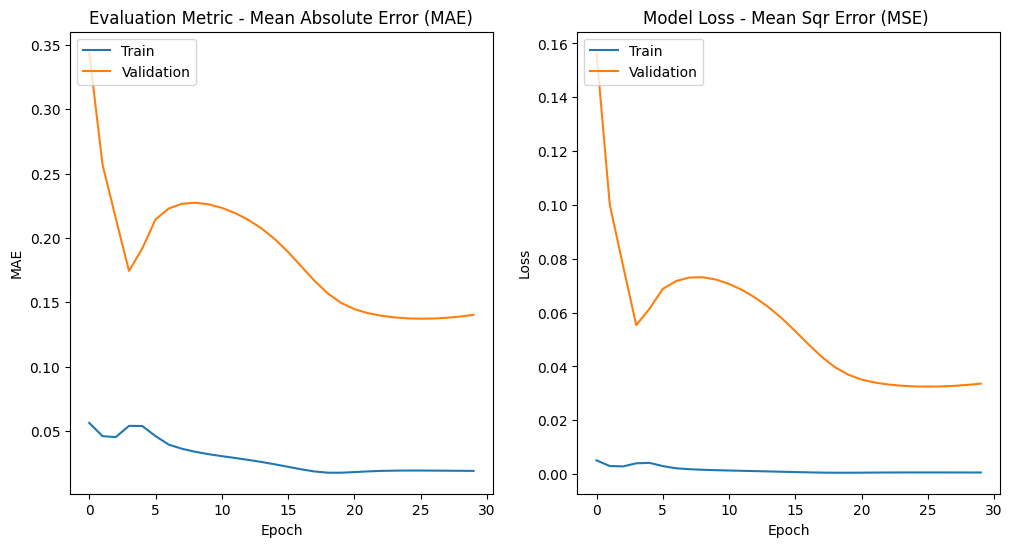

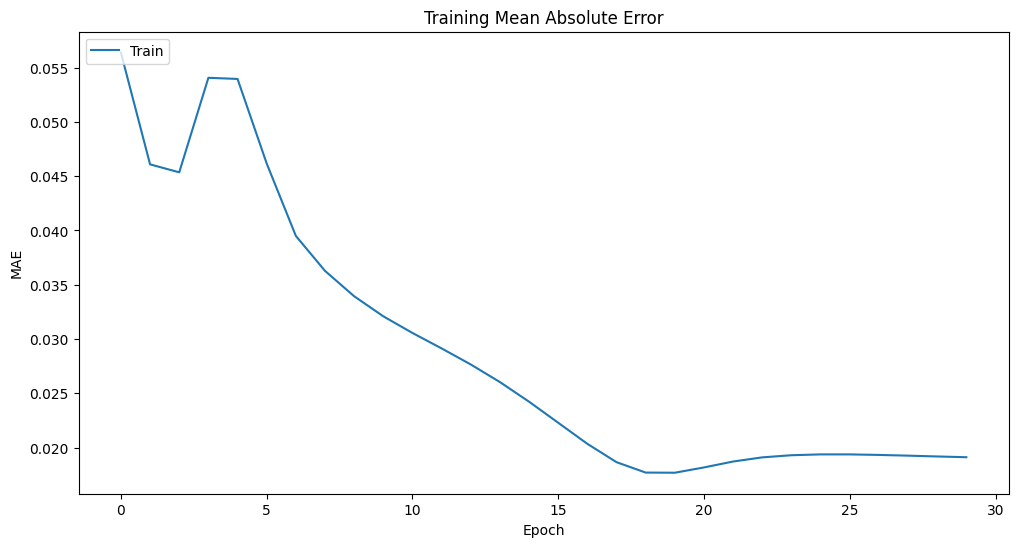

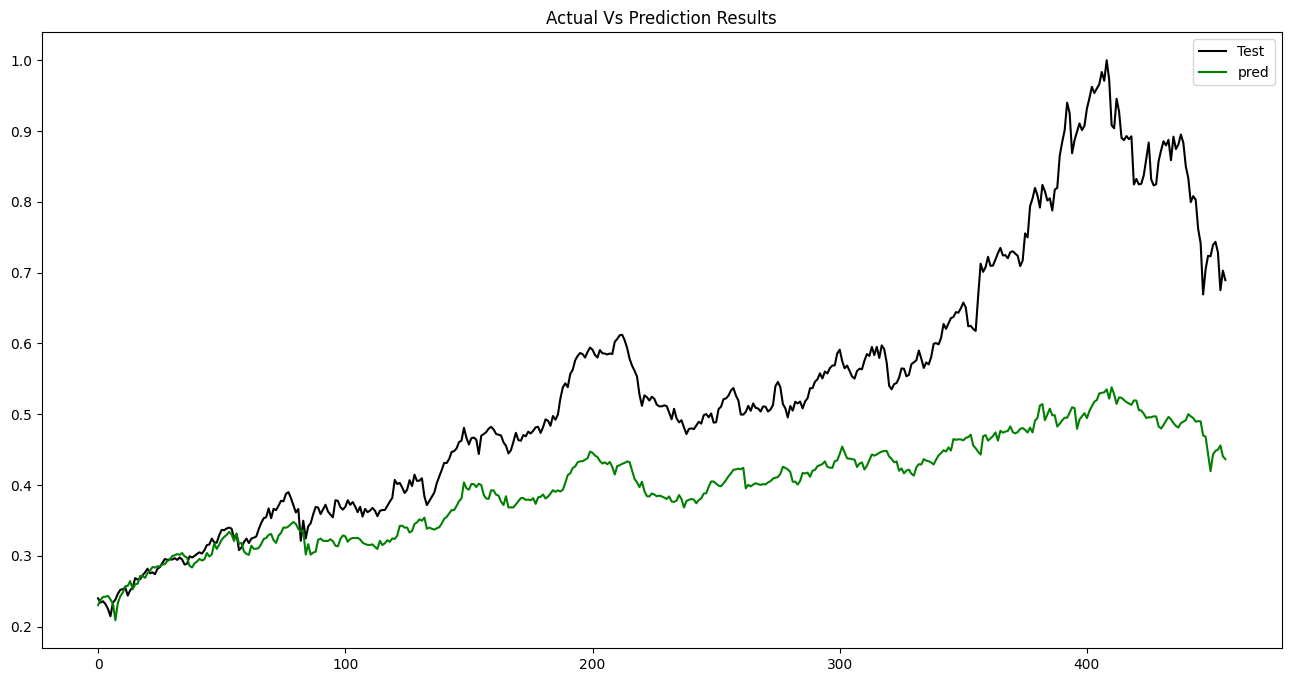

############################################################################
  Model Setup:
                    Name: ADM_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.2114202226821173
             mean_sqr_err =0.06927433880377888
        root_mean_sqr_err =0.2632001876970814
           pred_diff_mean =0.6599317538711501
      pred_diff_bias_mean =0.34006824612884995
    pred_correctness_mean =0.33916849015317285



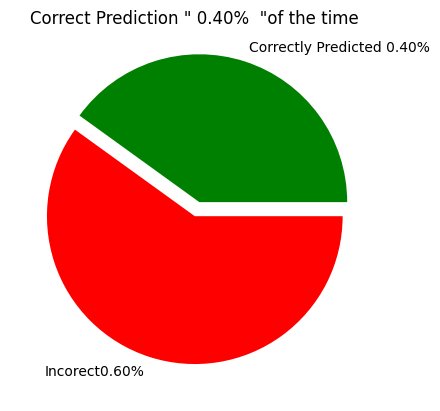

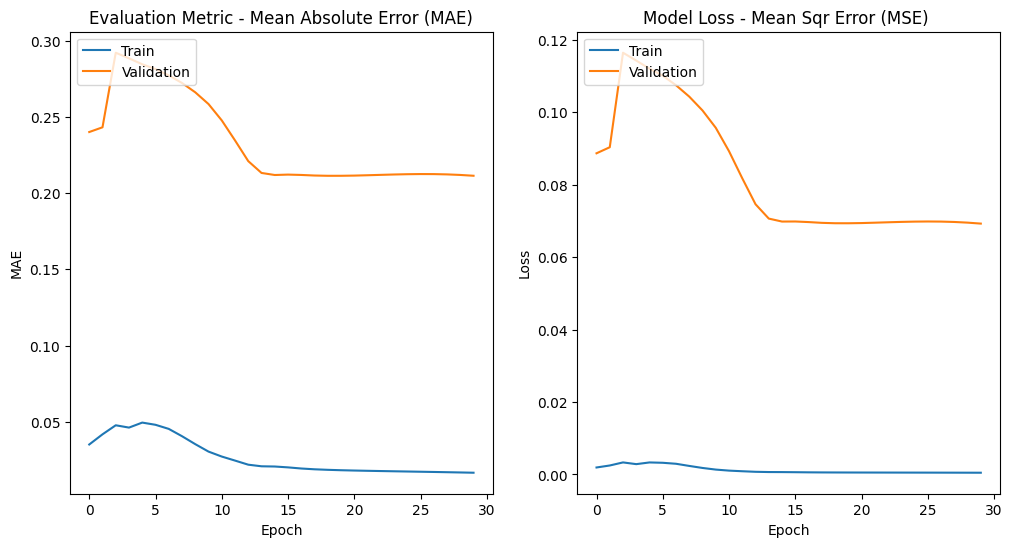

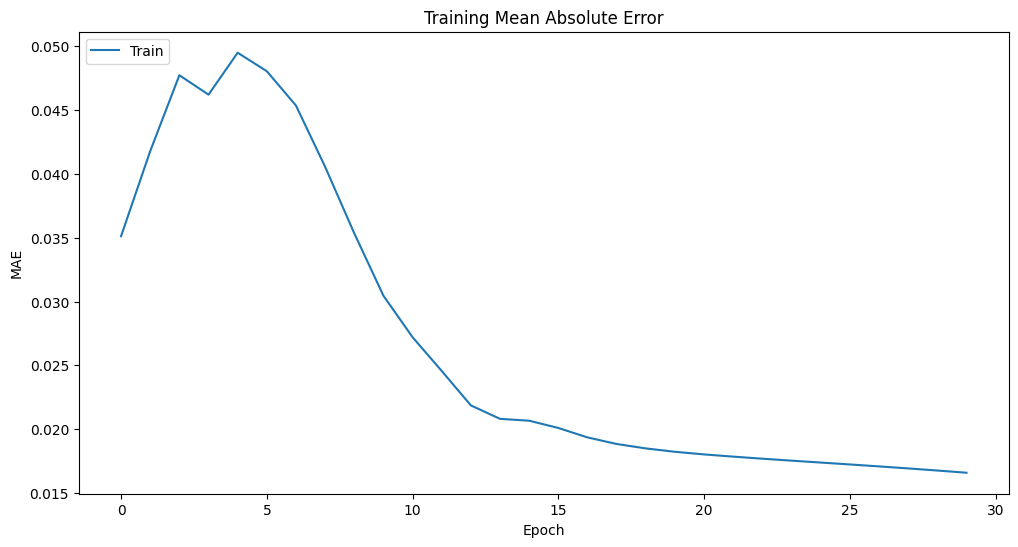

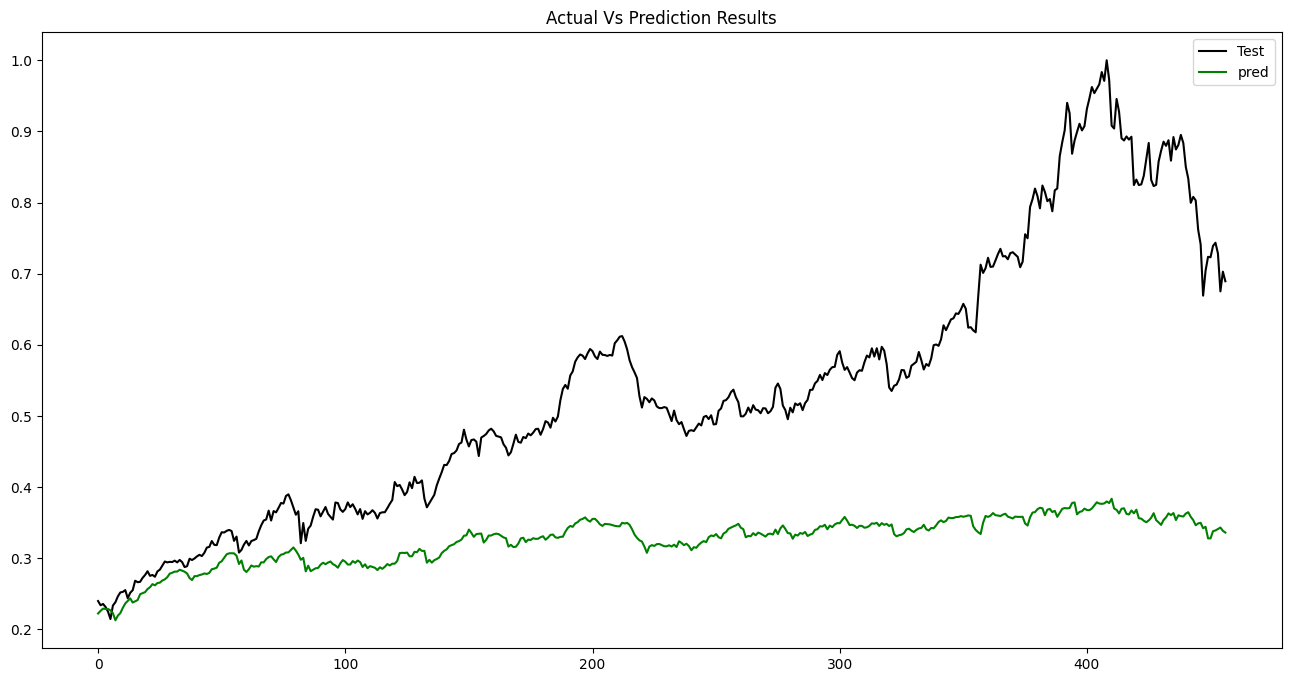

############################################################################
  Model Setup:
                    Name: ADM_F10_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.18996309074205434
             mean_sqr_err =0.05585977172792789
        root_mean_sqr_err =0.23634671930857828
           pred_diff_mean =0.6919111222047616
      pred_diff_bias_mean =0.3080888777952384
    pred_correctness_mean =0.3479212253829322



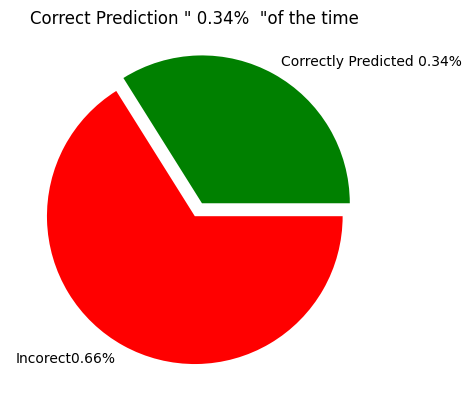

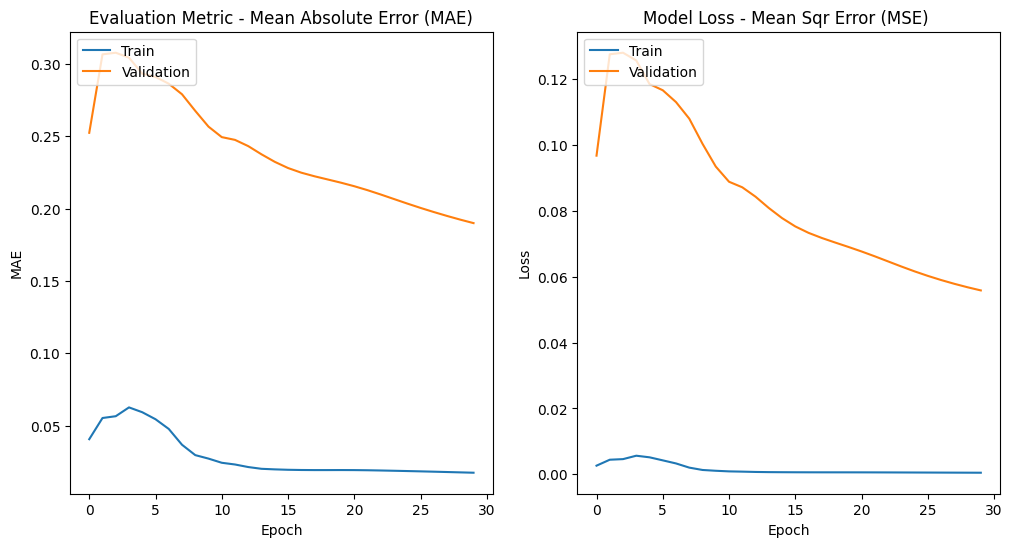

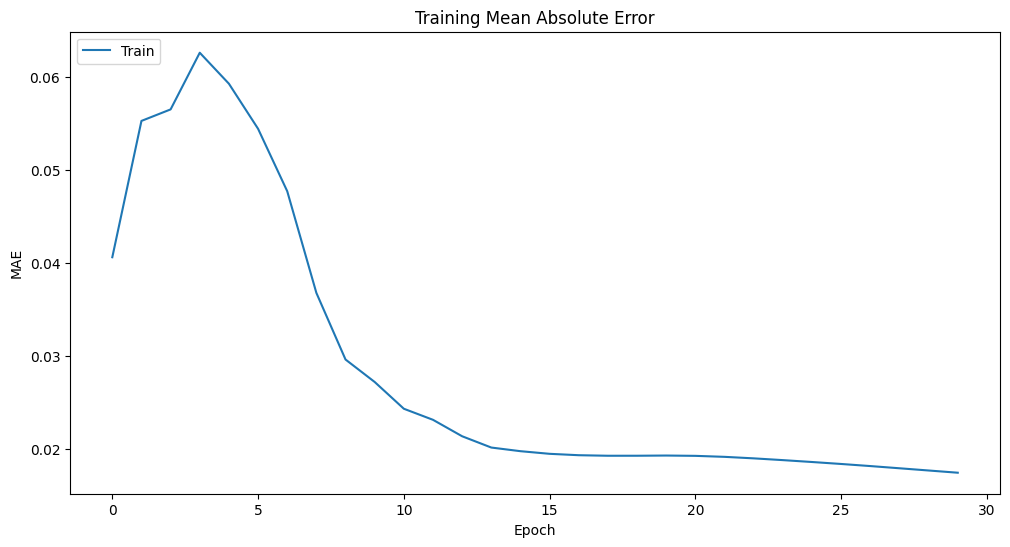

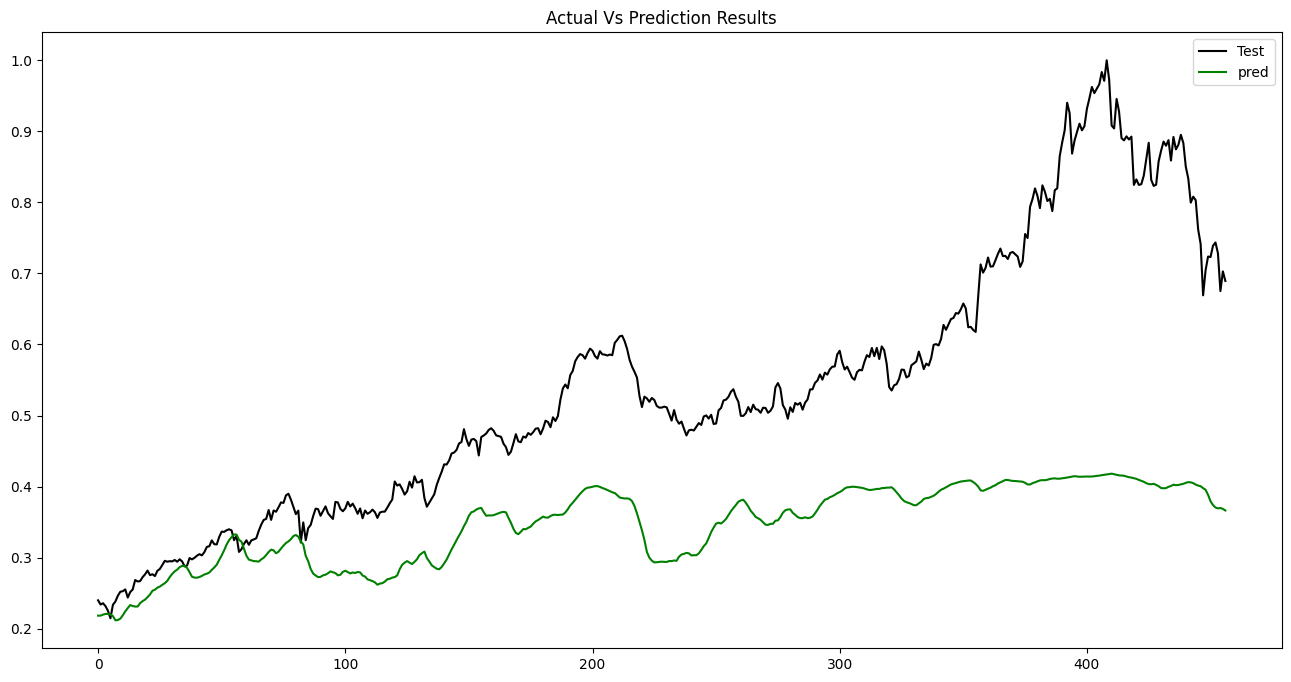

############################################################################
  Model Setup:
                    Name: ADM_F10_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.21298038273004222
             mean_sqr_err =0.06923149713831496
        root_mean_sqr_err =0.26311878902563185
           pred_diff_mean =0.6544022430630485
      pred_diff_bias_mean =0.34559775693695144
    pred_correctness_mean =0.3304157549234136



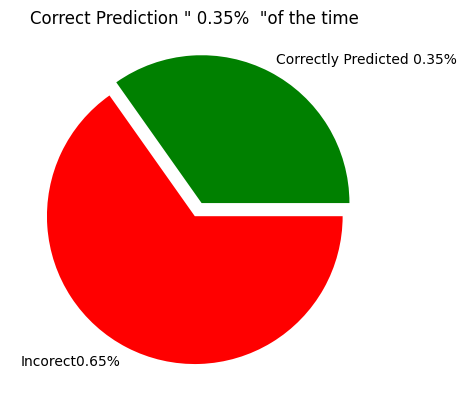

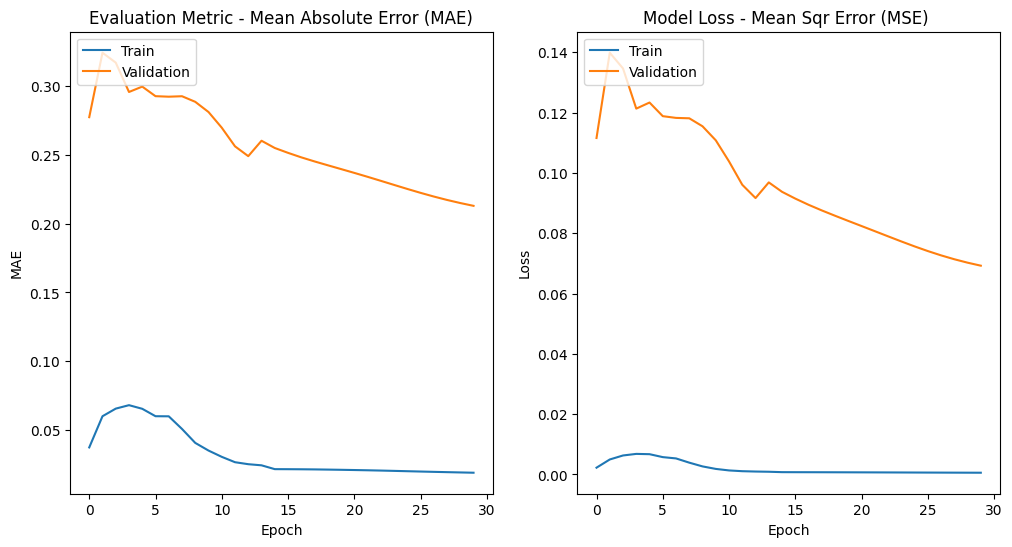

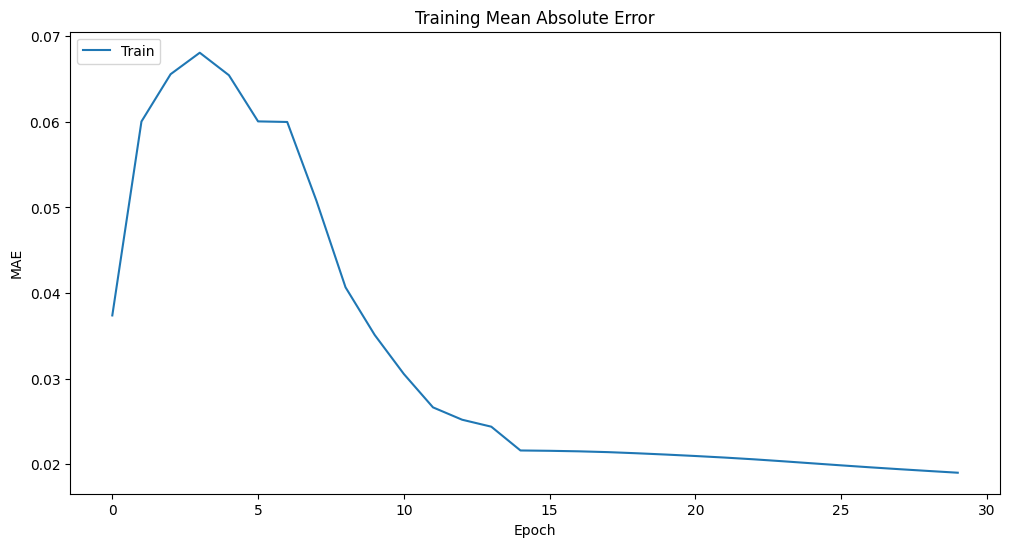

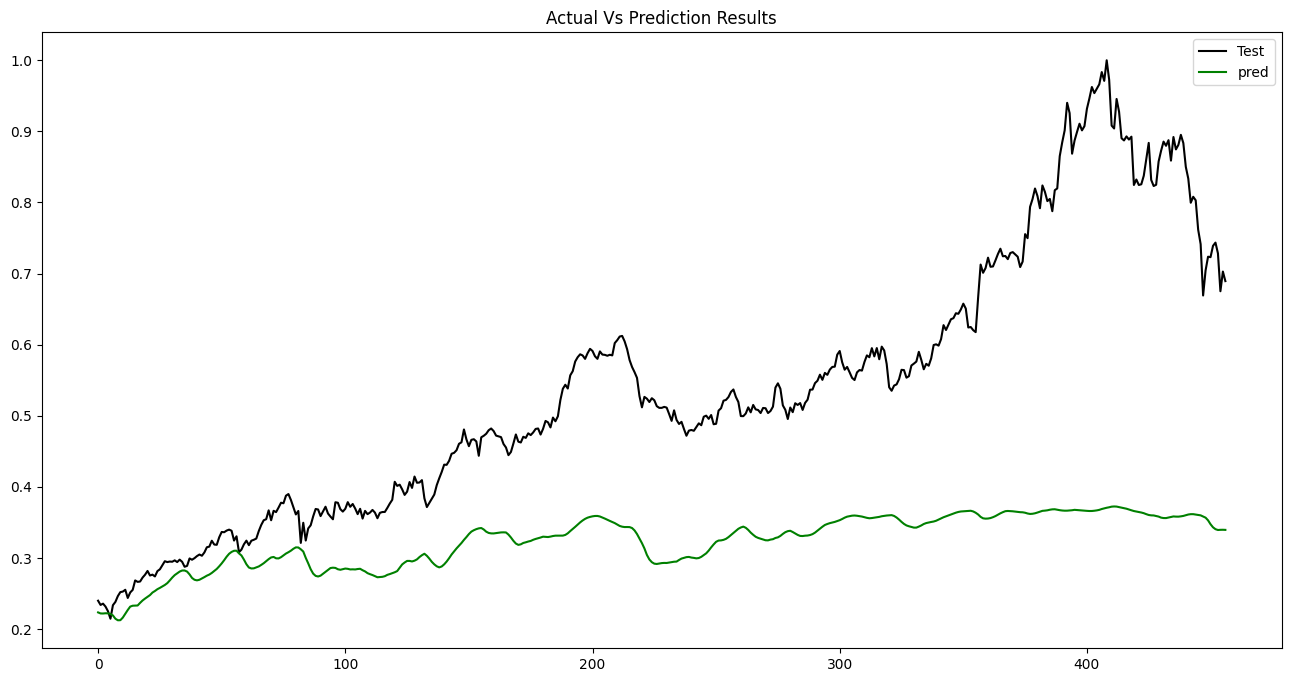

############################################################################
  Model Setup:
                    Name: ADM_F10_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.2023133685722869
             mean_sqr_err =0.06380362303468613
        root_mean_sqr_err =0.2525937905703268
           pred_diff_mean =0.6744222950331191
      pred_diff_bias_mean =0.32557770496688093
    pred_correctness_mean =0.34573304157549234



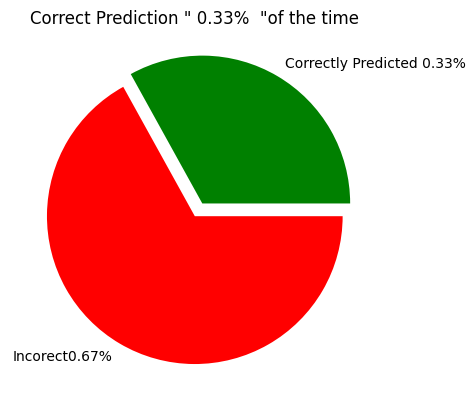

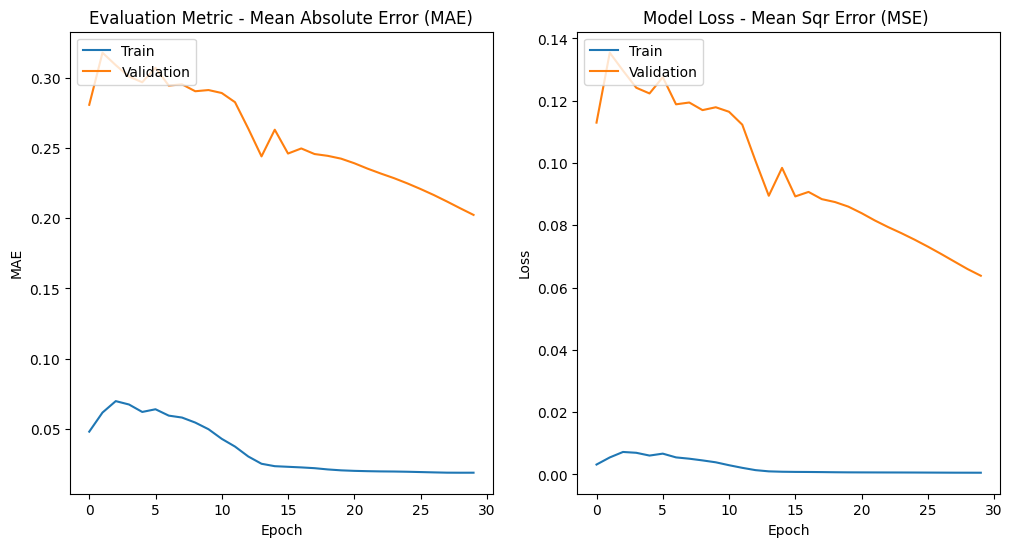

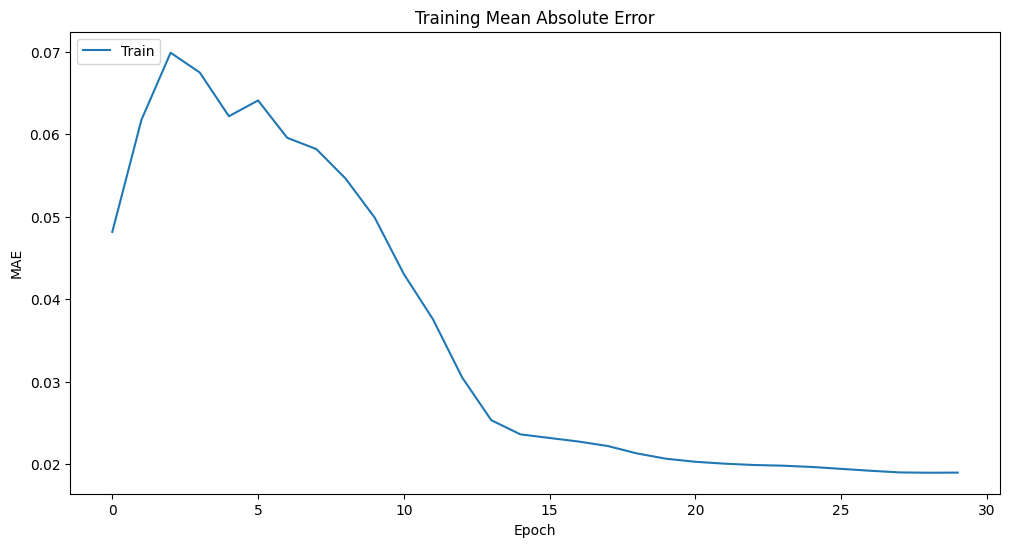

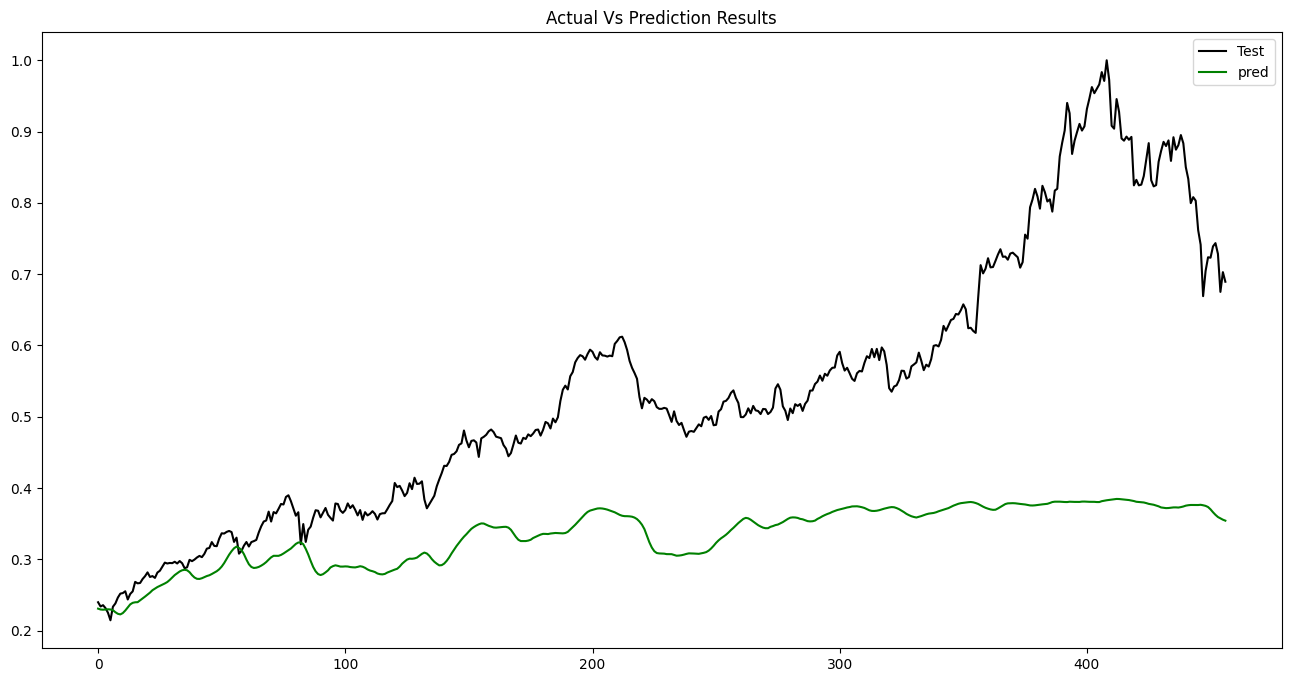

############################################################################
  Model Setup:
                    Name: ADM_F10_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.2672437624632182
             mean_sqr_err =0.10131681904993968
        root_mean_sqr_err =0.31830303022424977
           pred_diff_mean =0.556245600287835
      pred_diff_bias_mean =0.443754399712165
    pred_correctness_mean =0.2735229759299781



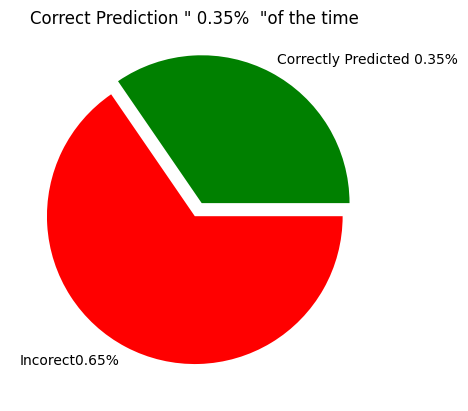

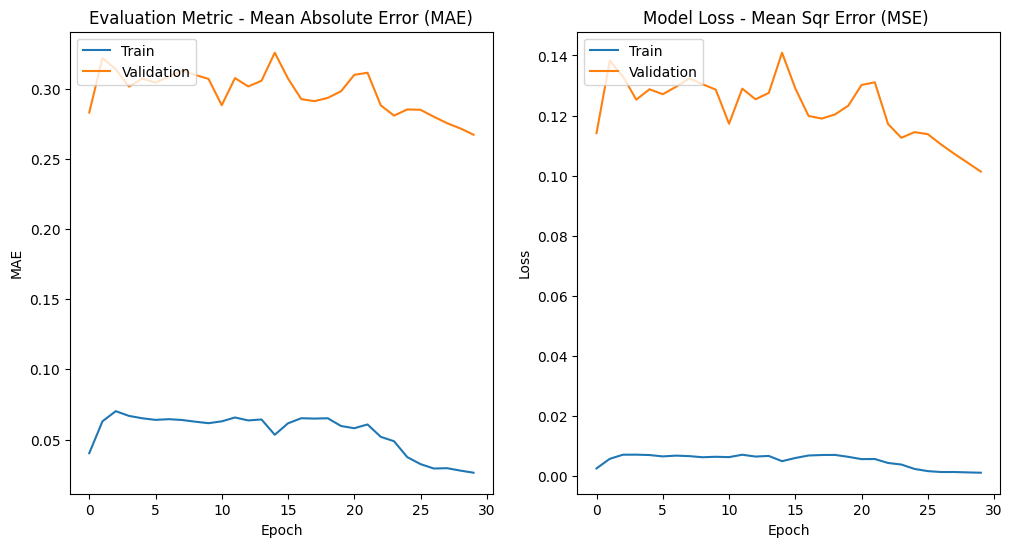

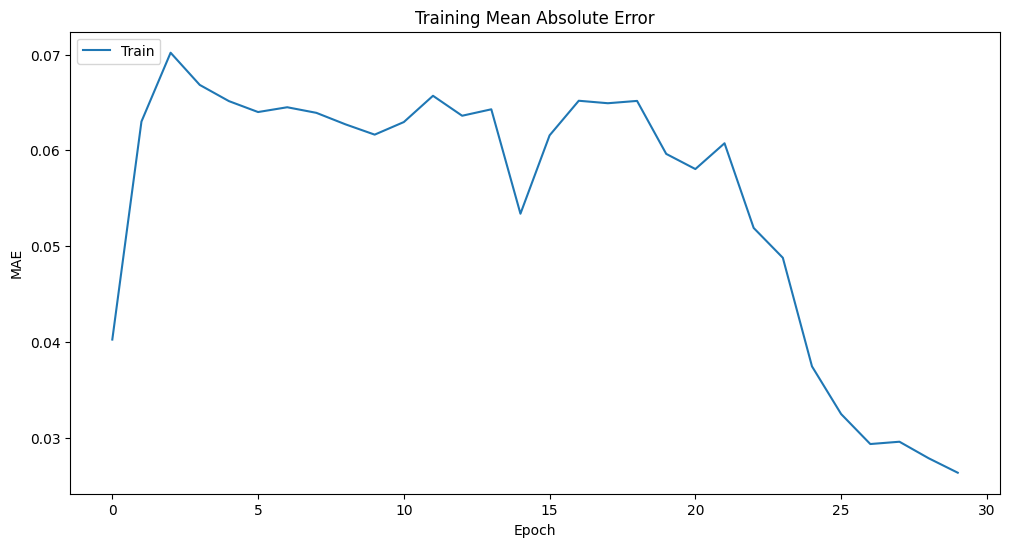

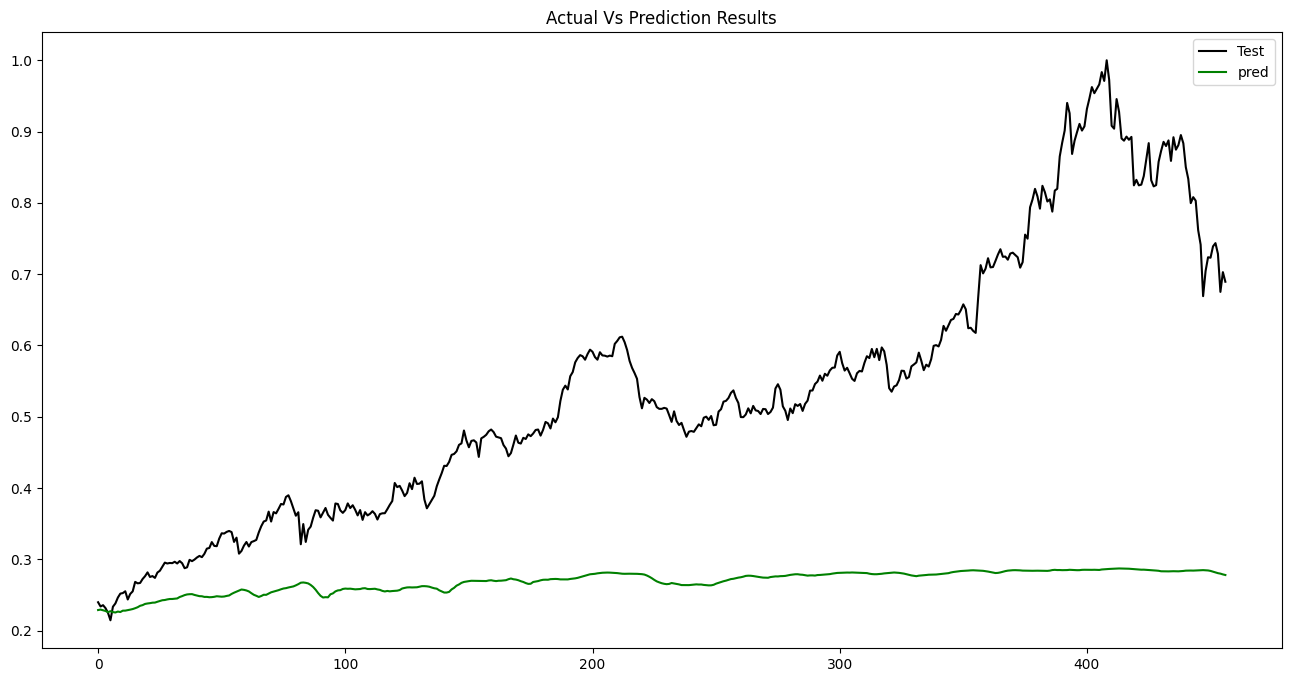

############################################################################
  Model Setup:
                    Name: ADM_F25_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.17154595068794998
             mean_sqr_err =0.04606216719092944
        root_mean_sqr_err =0.21462098497334653
           pred_diff_mean =0.7255248935138459
      pred_diff_bias_mean =0.2744751064861542
    pred_correctness_mean =0.3854625550660793



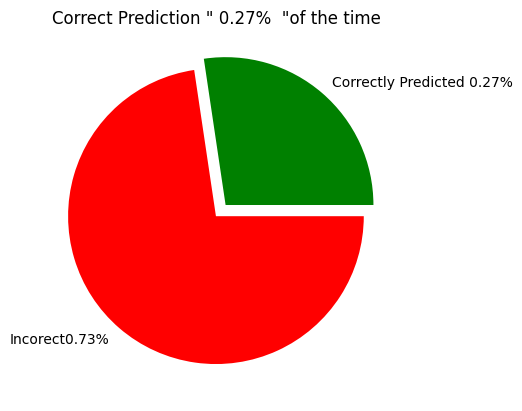

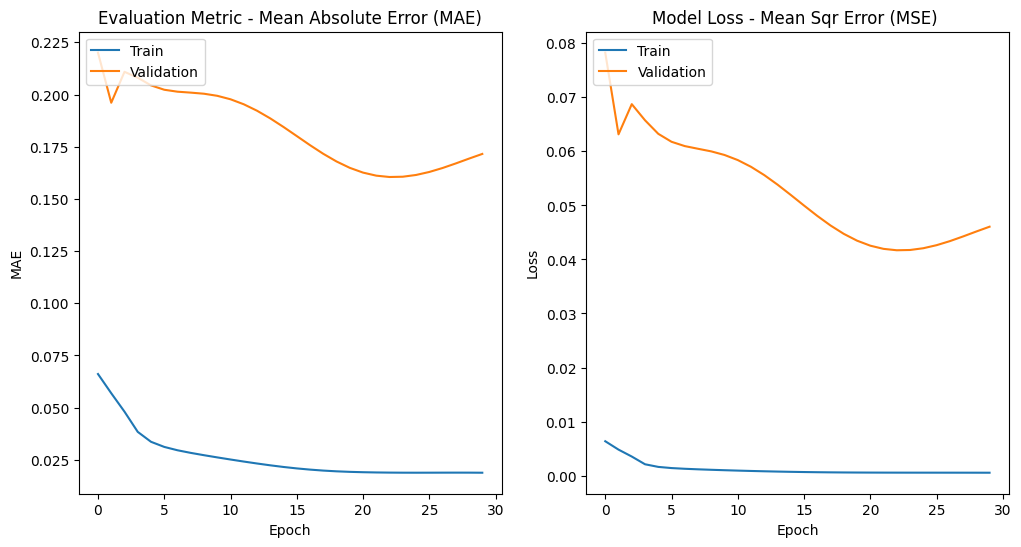

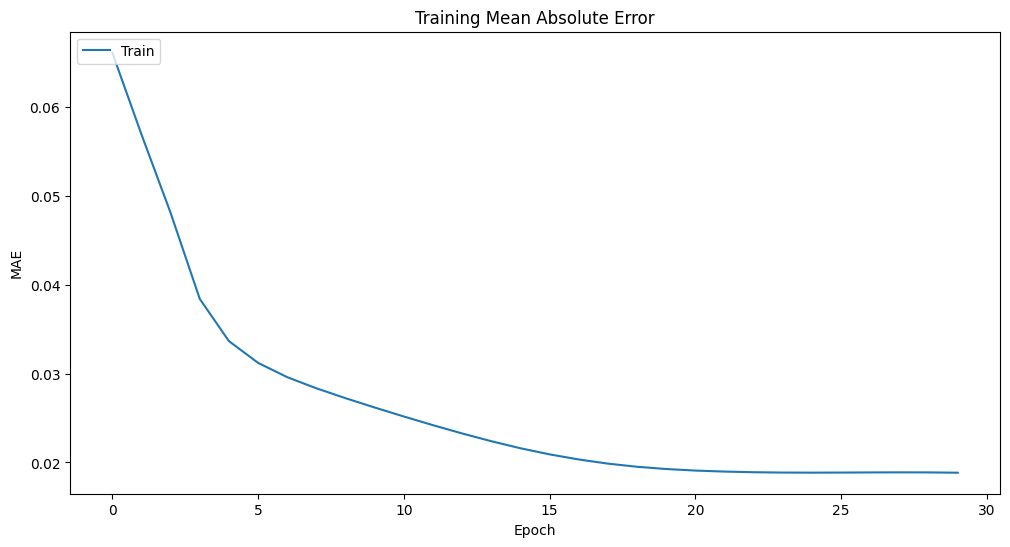

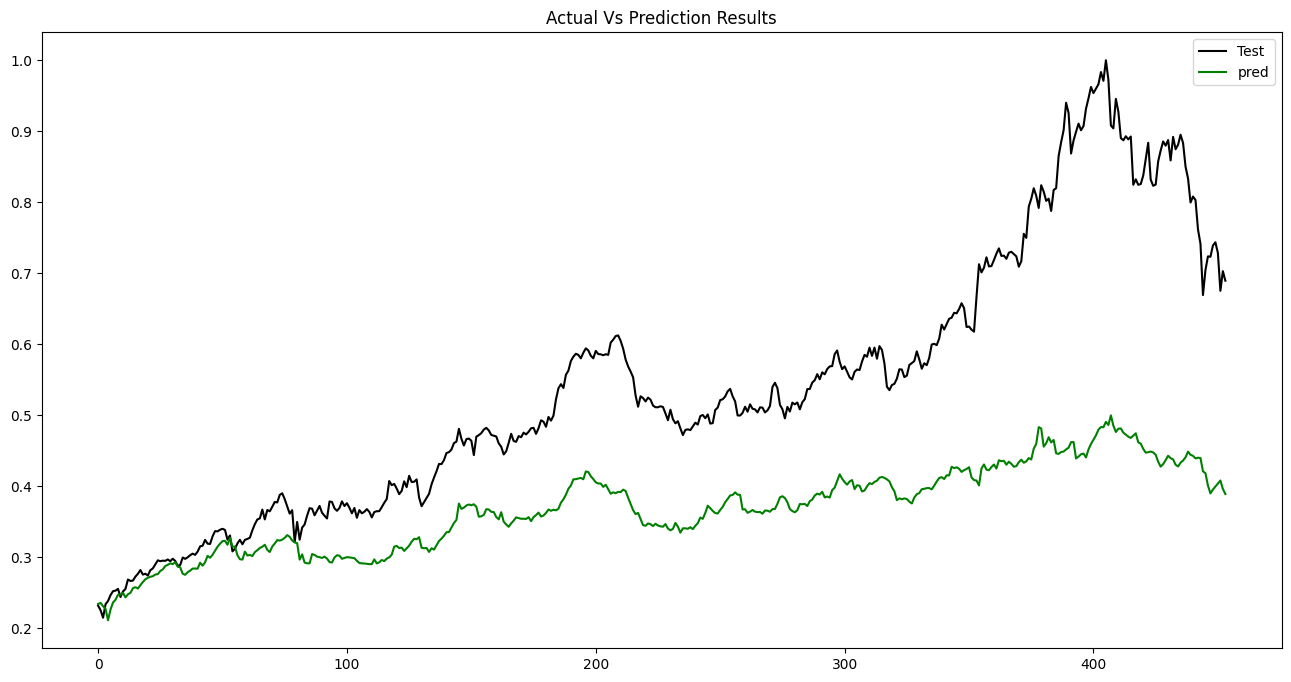

############################################################################
  Model Setup:
                    Name: ADM_F25_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.1988478138541553
             mean_sqr_err =0.06081624844940203
        root_mean_sqr_err =0.24660950599967155
           pred_diff_mean =0.6790392320543034
      pred_diff_bias_mean =0.32096076794569667
    pred_correctness_mean =0.3590308370044053



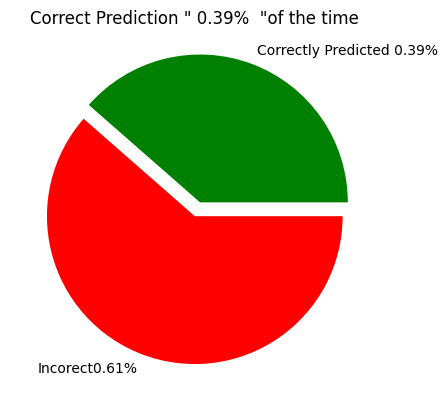

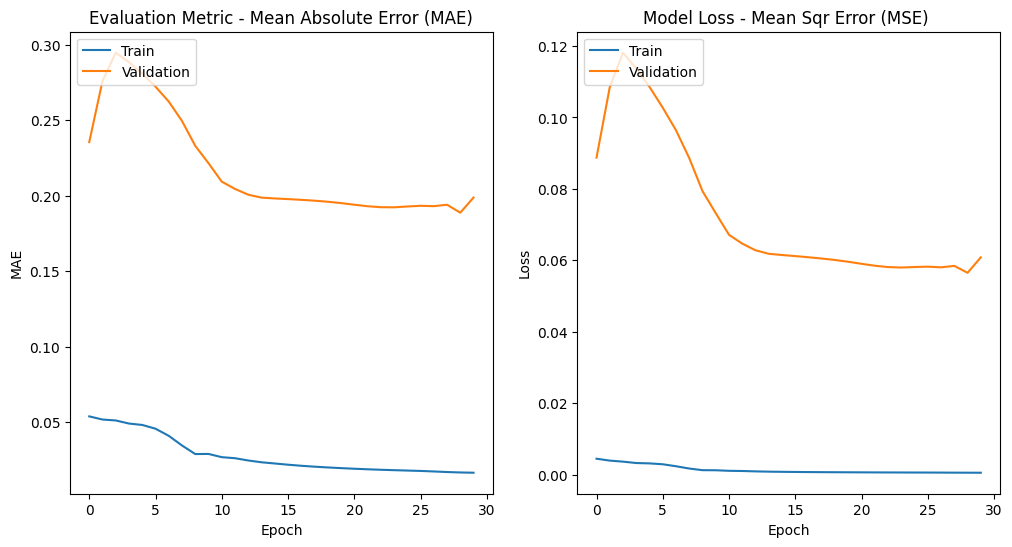

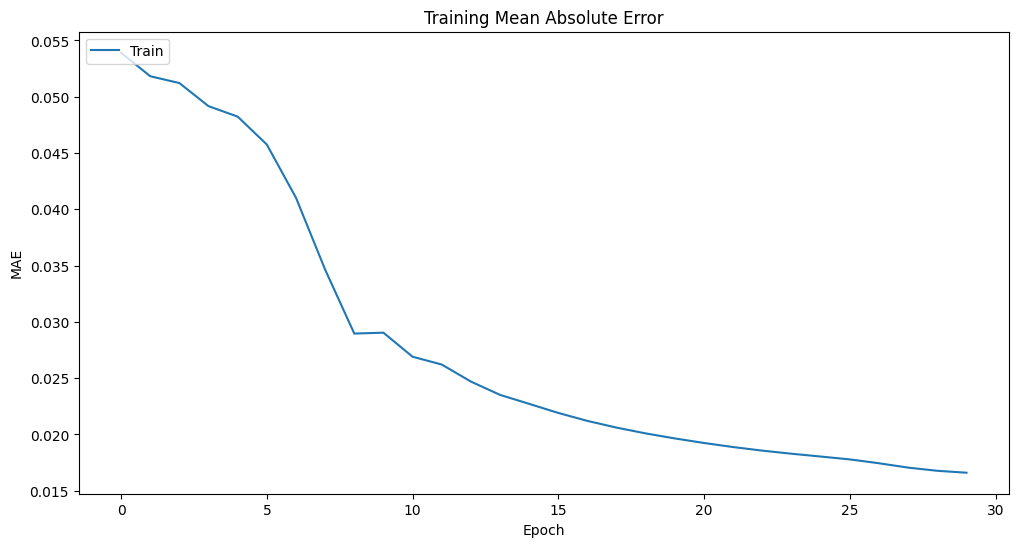

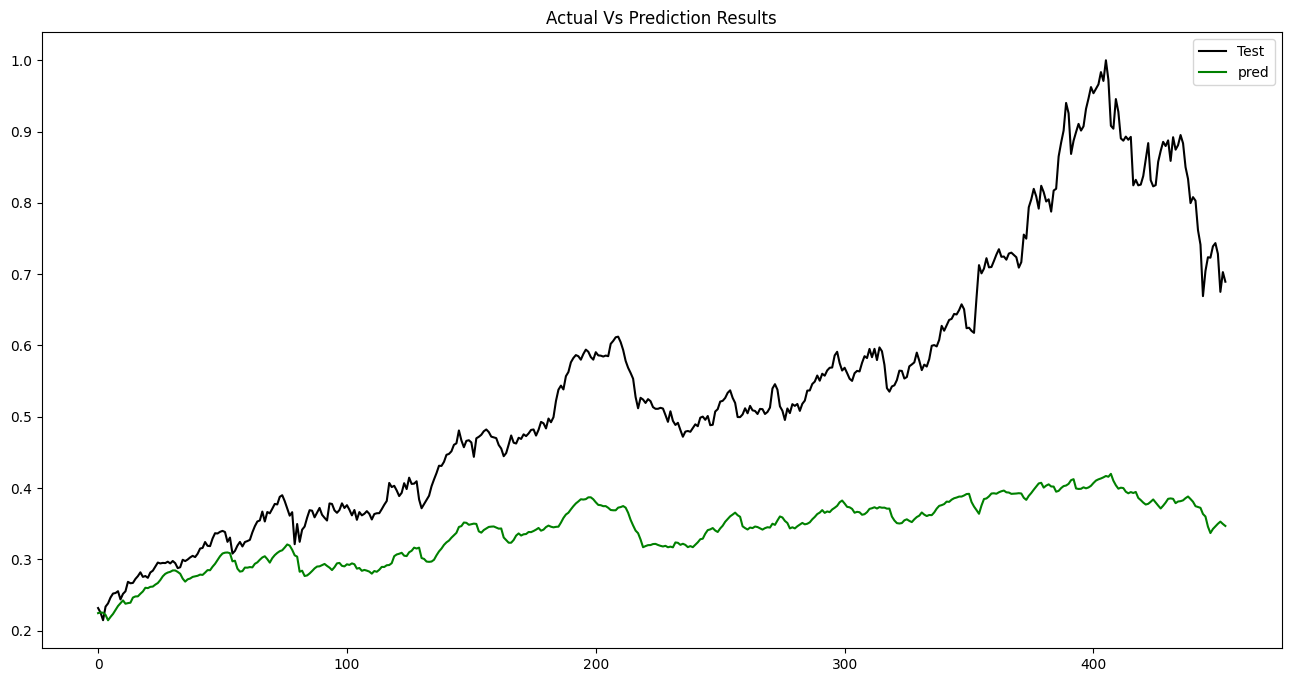

############################################################################
  Model Setup:
                    Name: ADM_F25_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.19776821359222277
             mean_sqr_err =0.06056658031219364
        root_mean_sqr_err =0.2461027840399081
           pred_diff_mean =0.6809311849584951
      pred_diff_bias_mean =0.3190688150415048
    pred_correctness_mean =0.3590308370044053



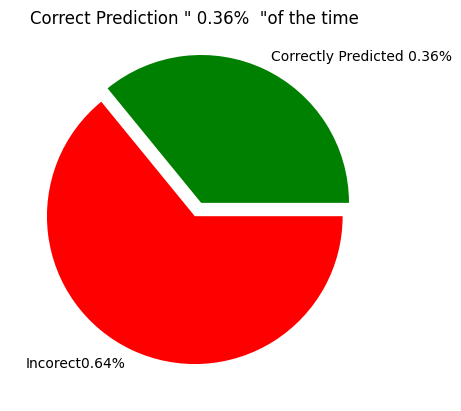

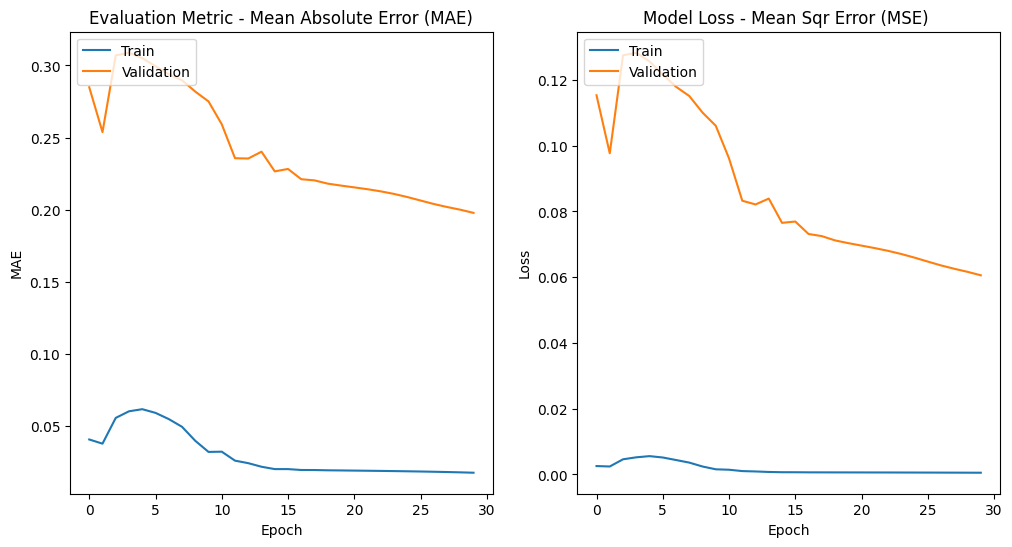

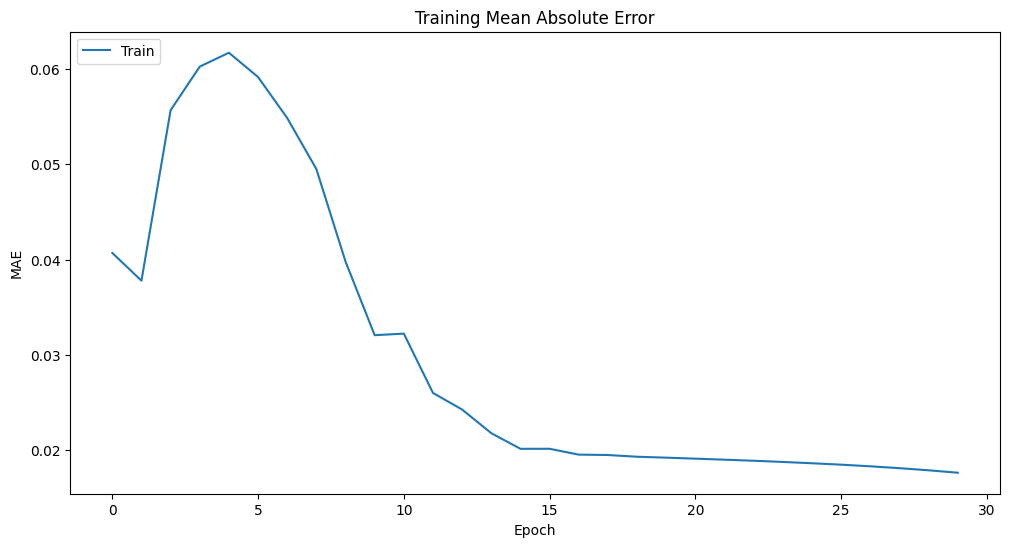

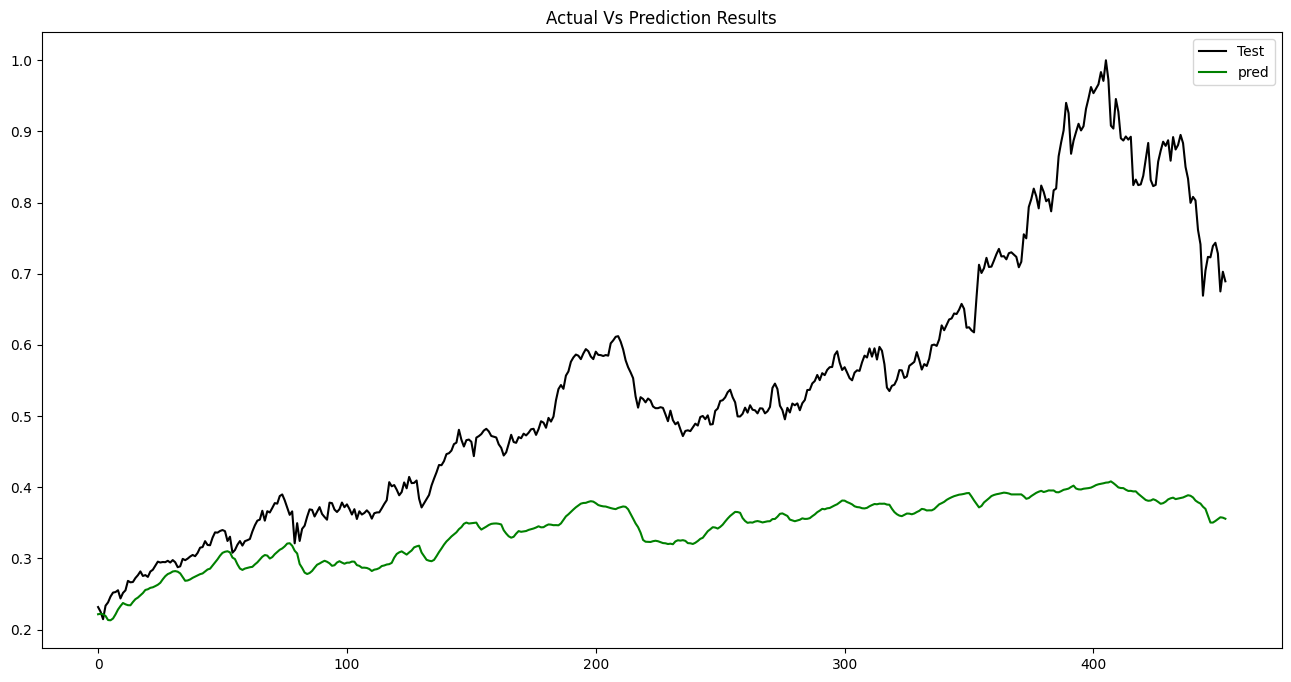

############################################################################
  Model Setup:
                    Name: ADM_F25_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.19688471661322
             mean_sqr_err =0.06144331371534399
        root_mean_sqr_err =0.24787761842357608
           pred_diff_mean =0.6858078034535389
      pred_diff_bias_mean =0.314192196546461
    pred_correctness_mean =0.36784140969163



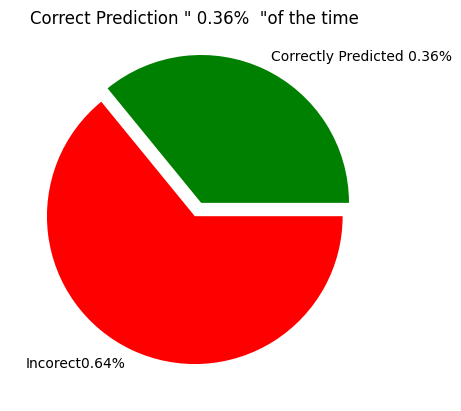

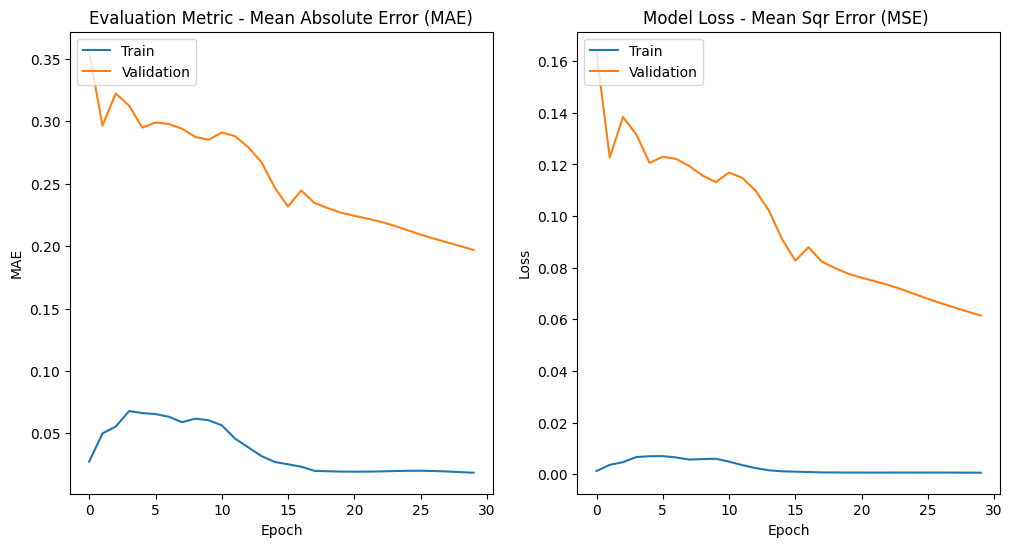

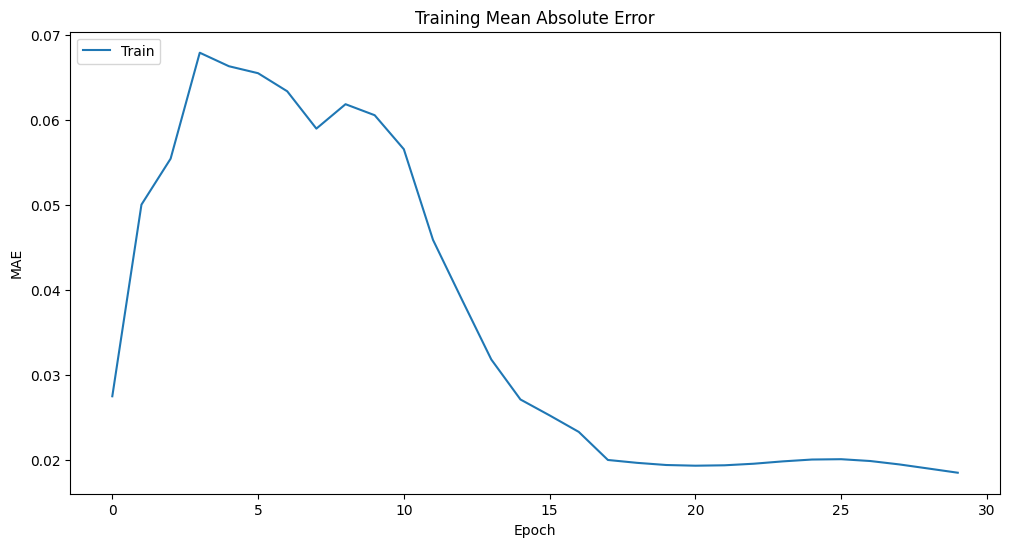

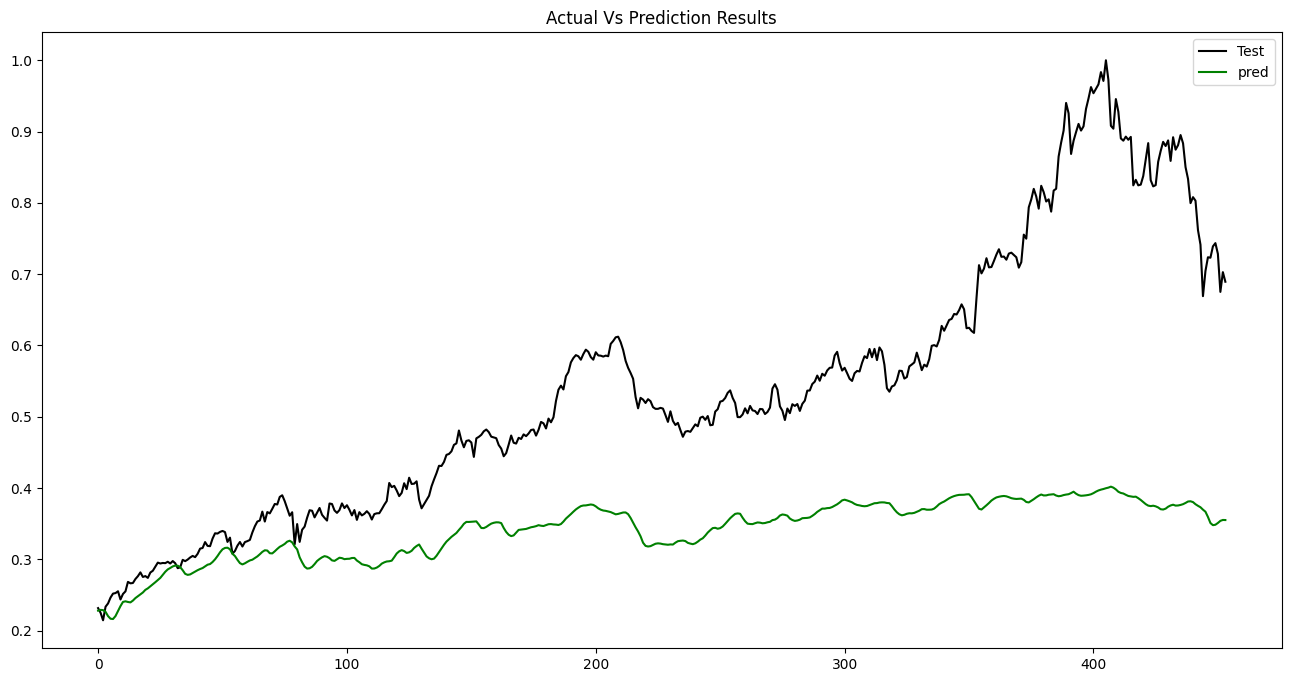

############################################################################
  Model Setup:
                    Name: ADM_F25_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.24763267011607873
             mean_sqr_err =0.08797330364979547
        root_mean_sqr_err =0.2966029393815838
           pred_diff_mean =0.5918488844642839
      pred_diff_bias_mean =0.40815111553571626
    pred_correctness_mean =0.31718061674008813



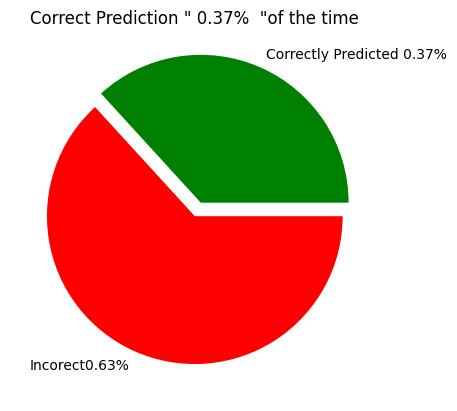

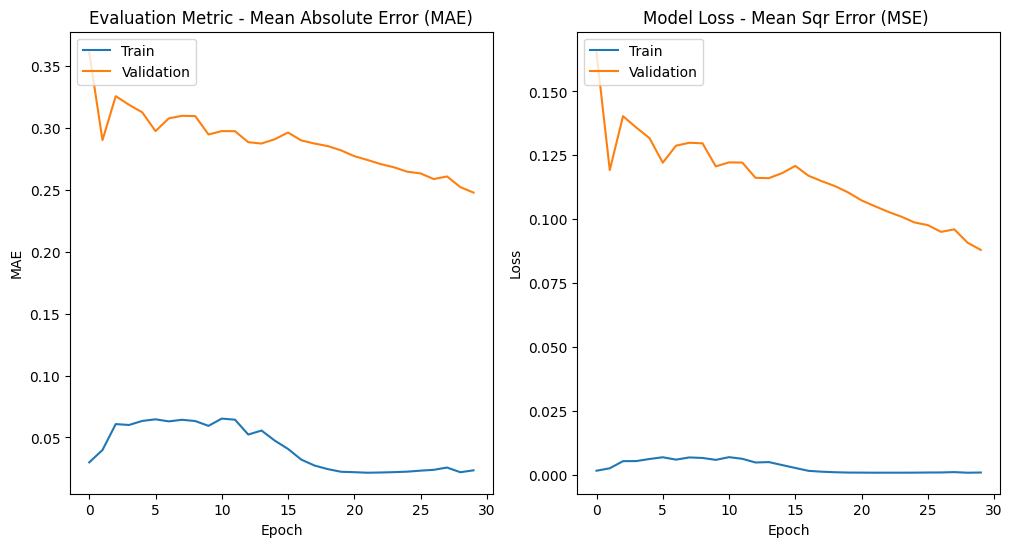

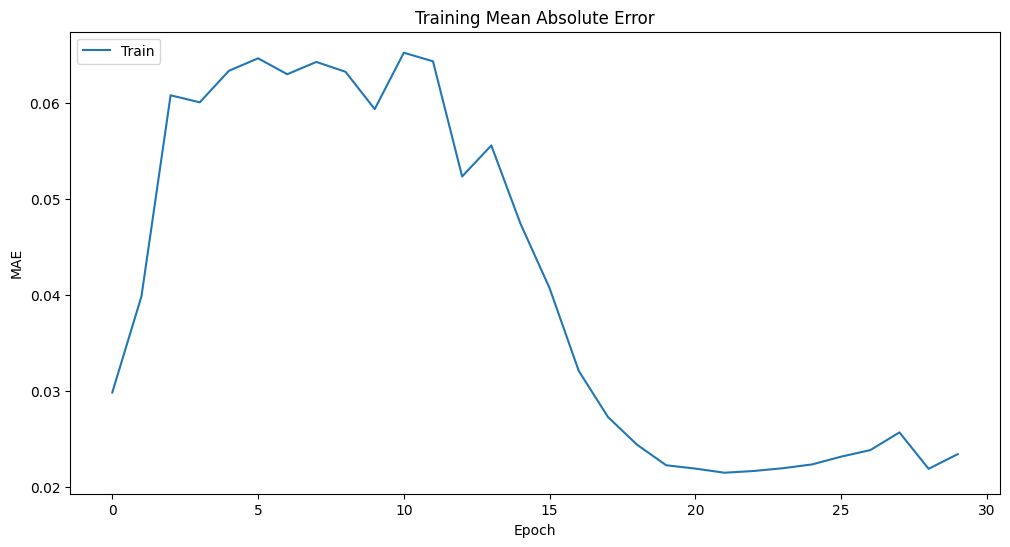

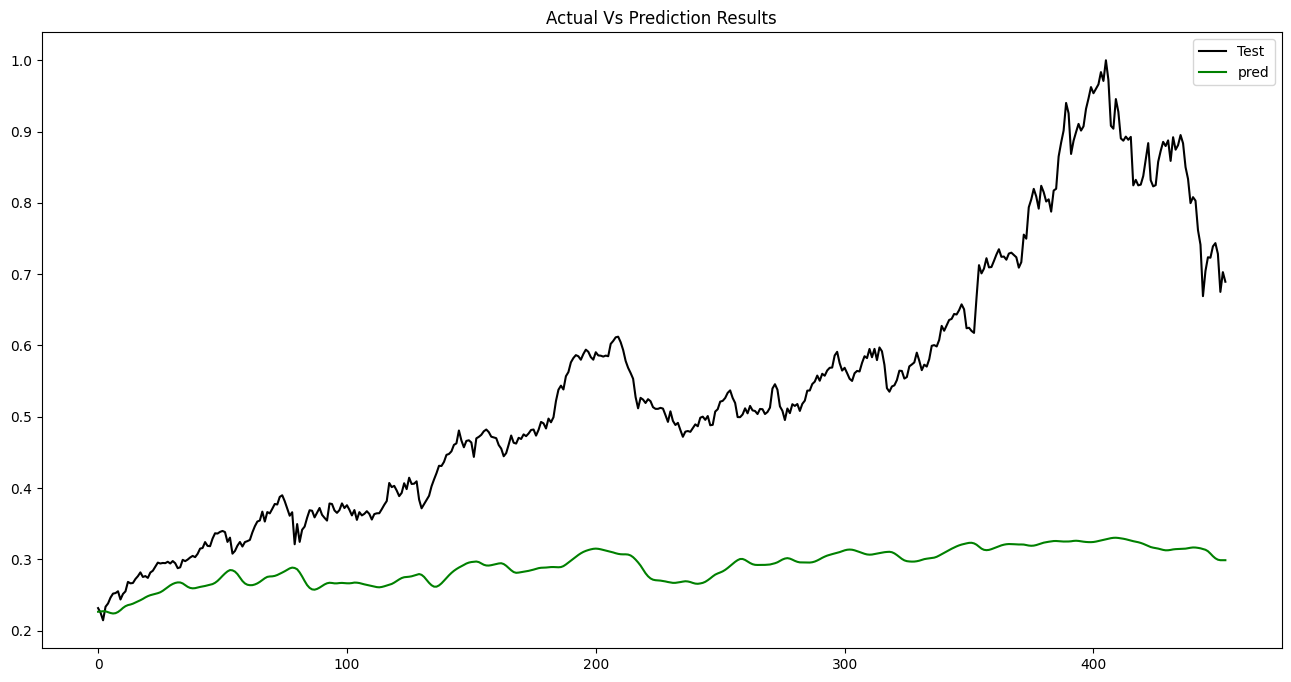

############################################################################
  Model Setup:
                    Name: ADM_F25_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.2974886521922342
             mean_sqr_err =0.12279362985698503
        root_mean_sqr_err =0.3504192201592045
           pred_diff_mean =0.5054128161132442
      pred_diff_bias_mean =0.49458718388675577
    pred_correctness_mean =0.27973568281938327



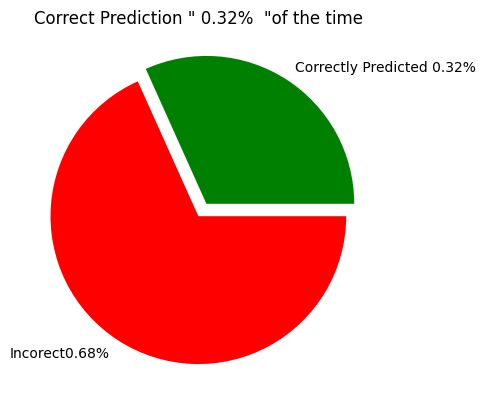

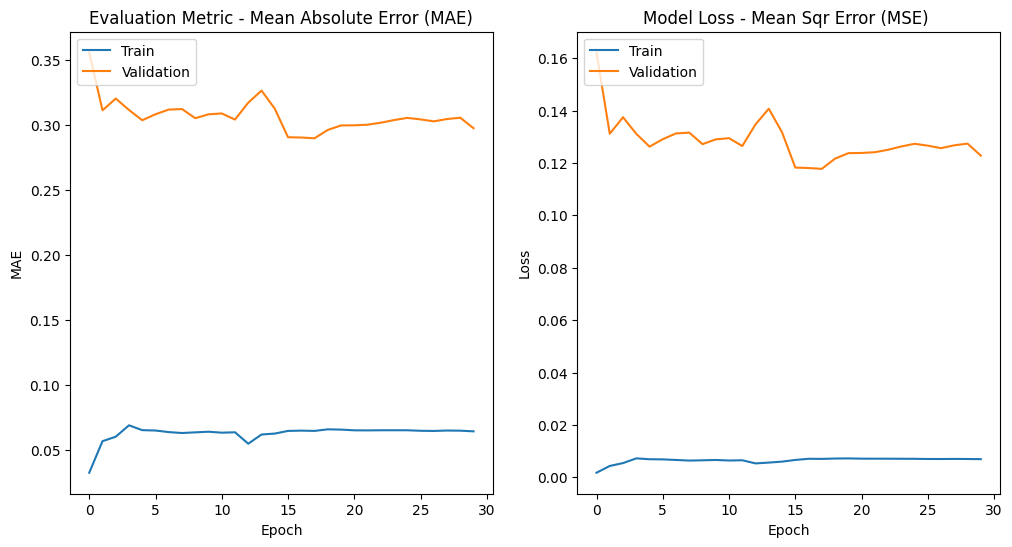

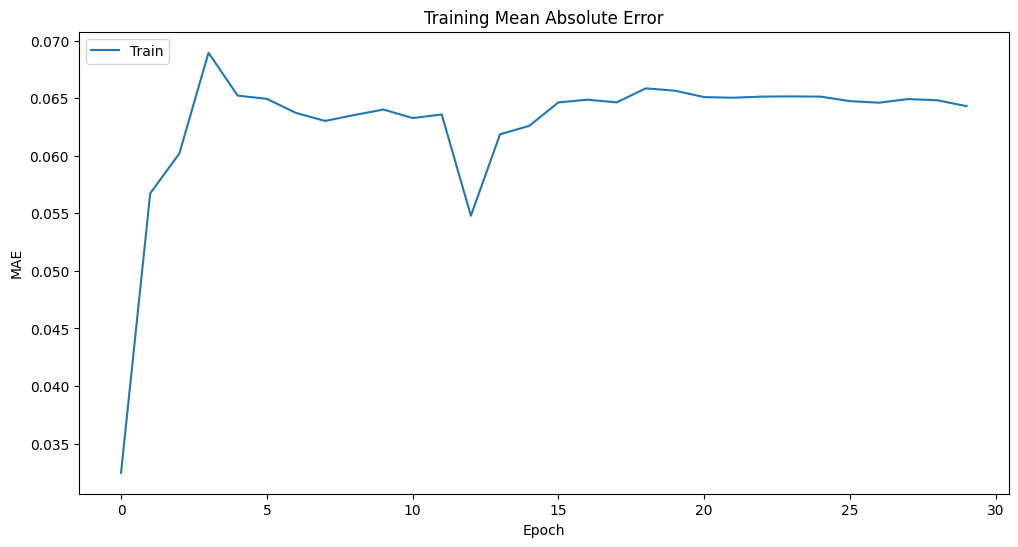

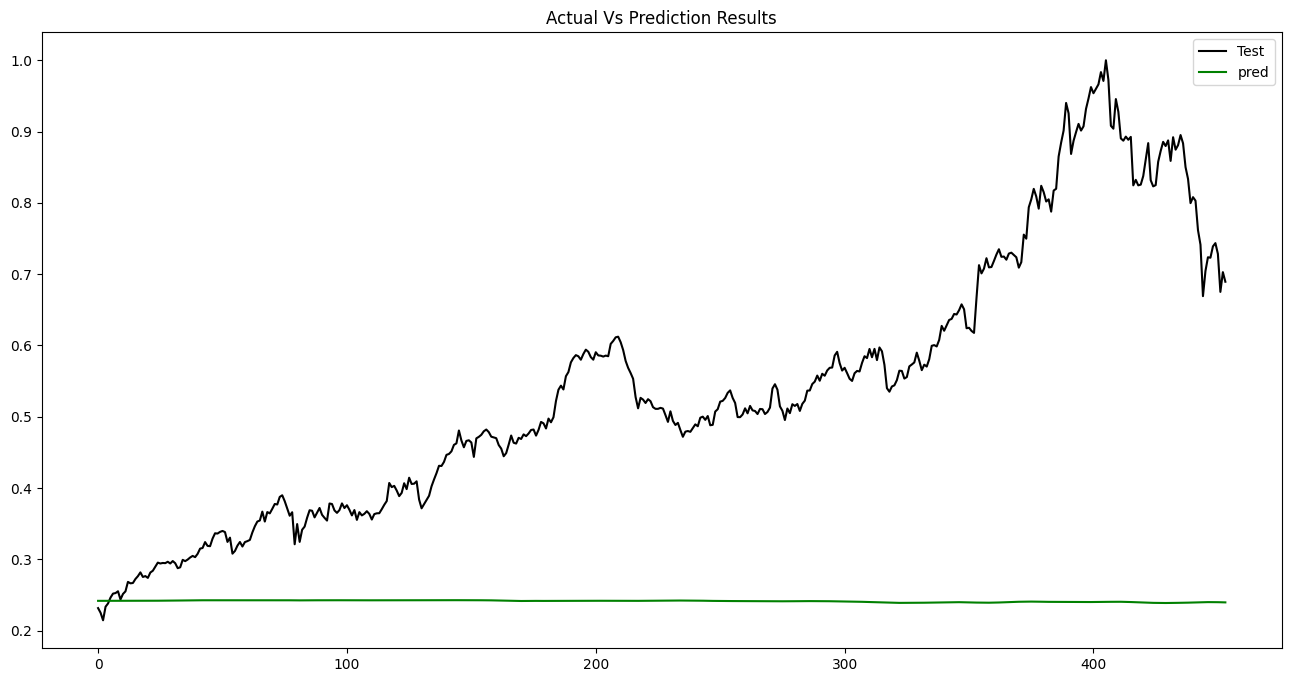

############################################################################
  Model Setup:
                    Name: ADM_F50_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.1869577611555904
             mean_sqr_err =0.0520997028291663
        root_mean_sqr_err =0.2282535932448081
           pred_diff_mean =0.6966472795771617
      pred_diff_bias_mean =0.30335272042283845
    pred_correctness_mean =0.34743875278396436



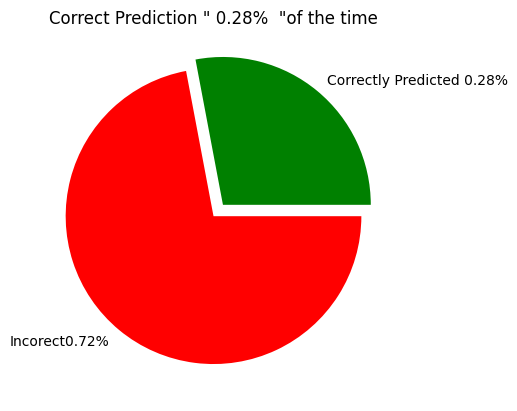

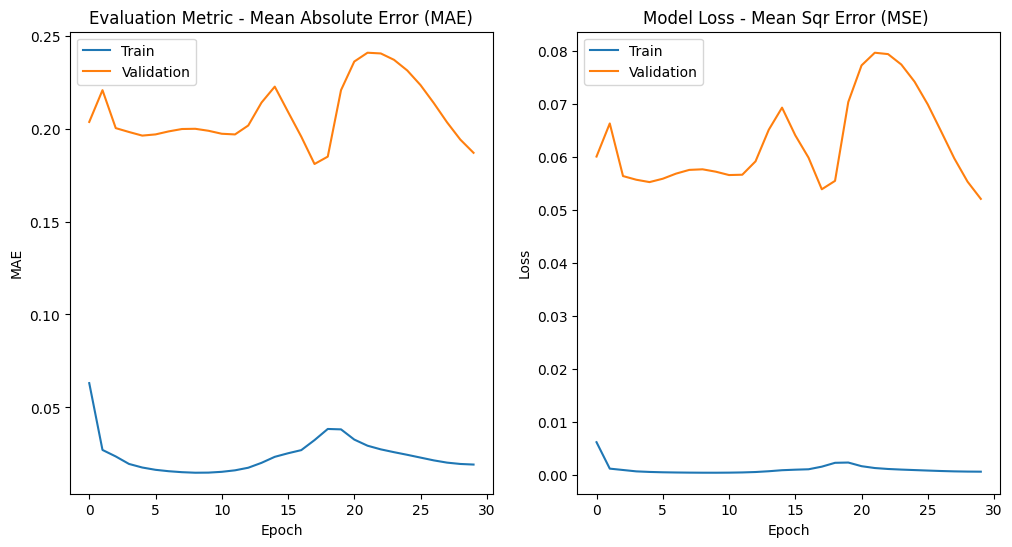

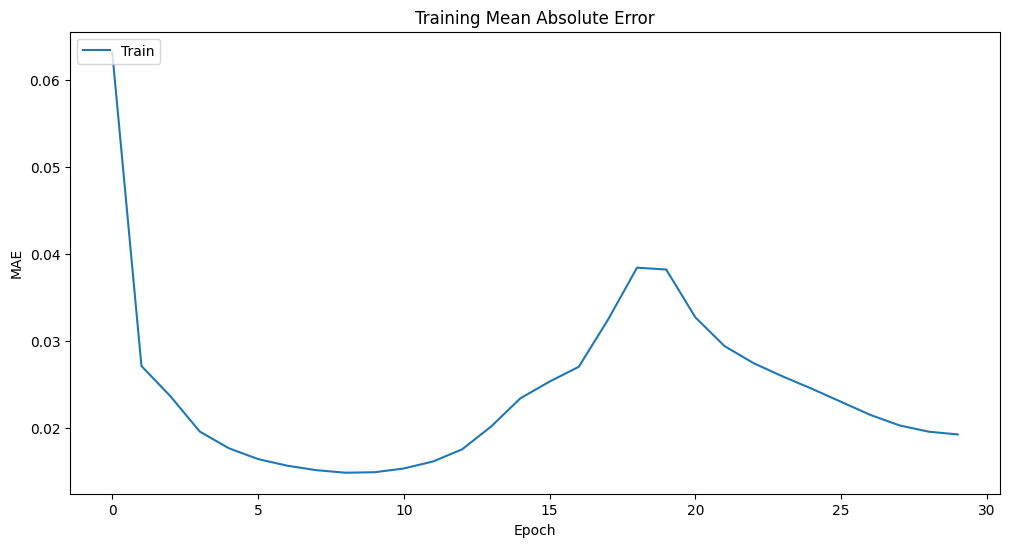

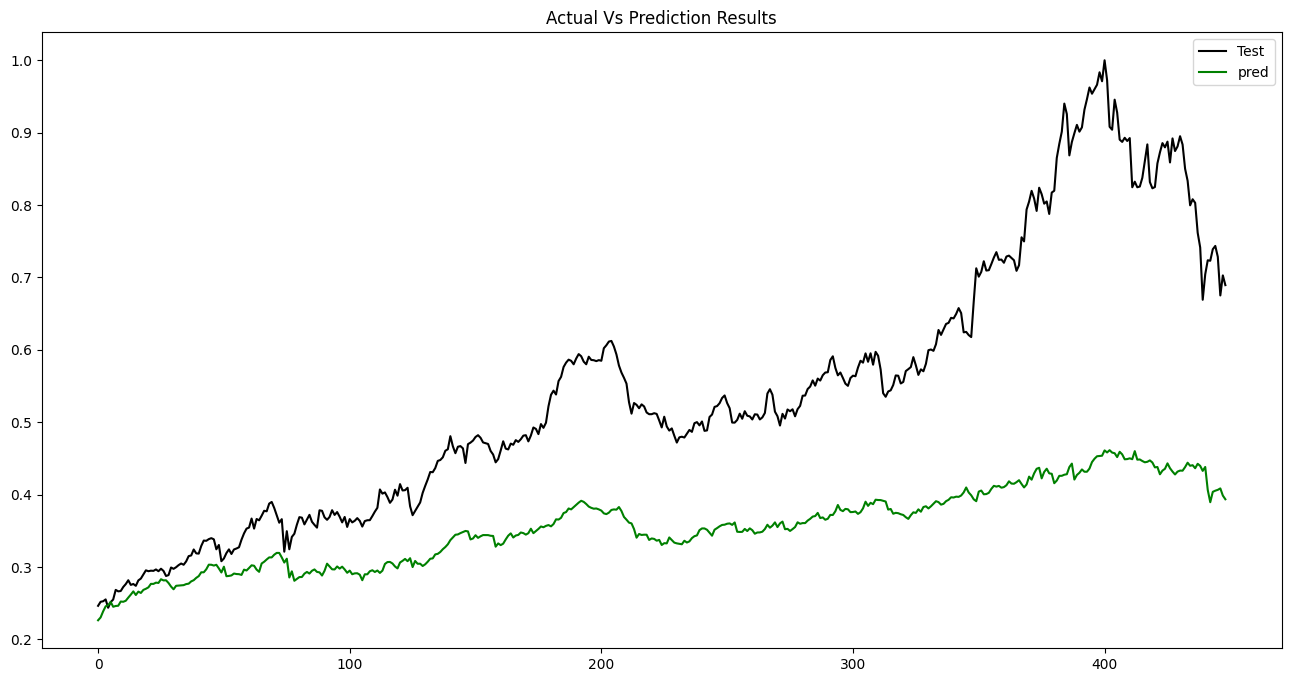

############################################################################
  Model Setup:
                    Name: ADM_F50_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.20629263358892003
             mean_sqr_err =0.0643142722998912
        root_mean_sqr_err =0.2536025873288583
           pred_diff_mean =0.6670824484027235
      pred_diff_bias_mean =0.3329175515972766
    pred_correctness_mean =0.3207126948775056



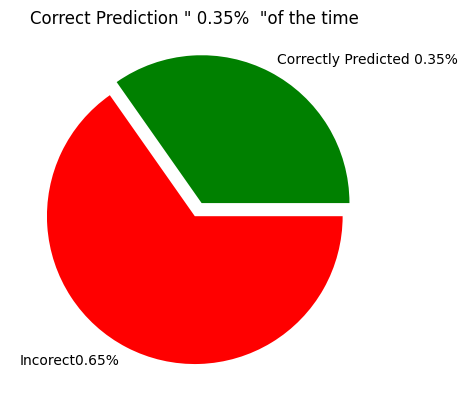

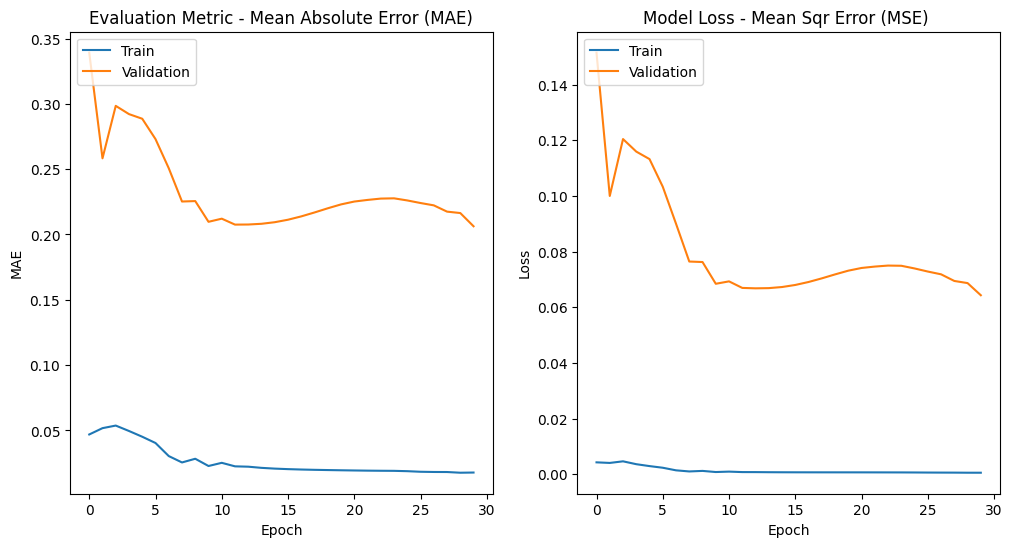

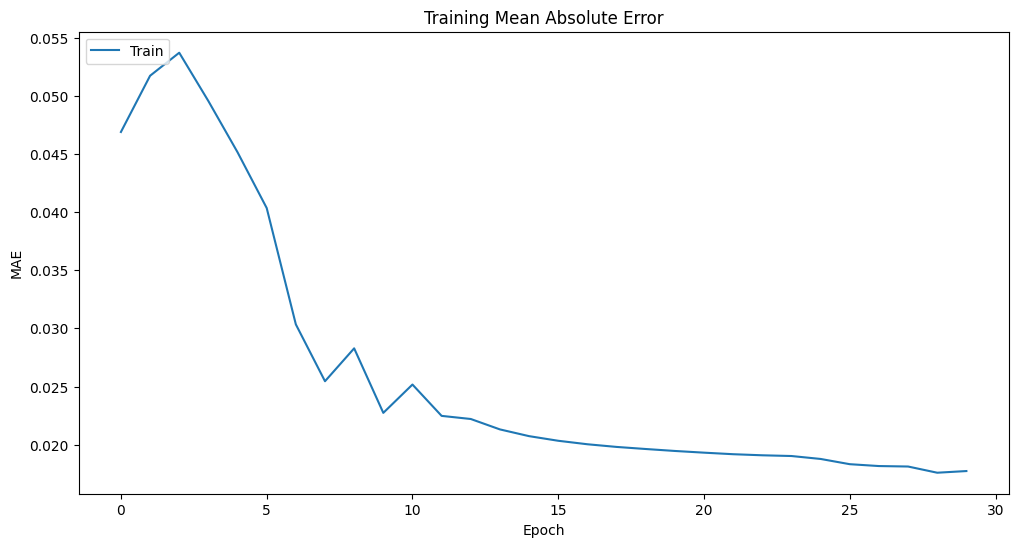

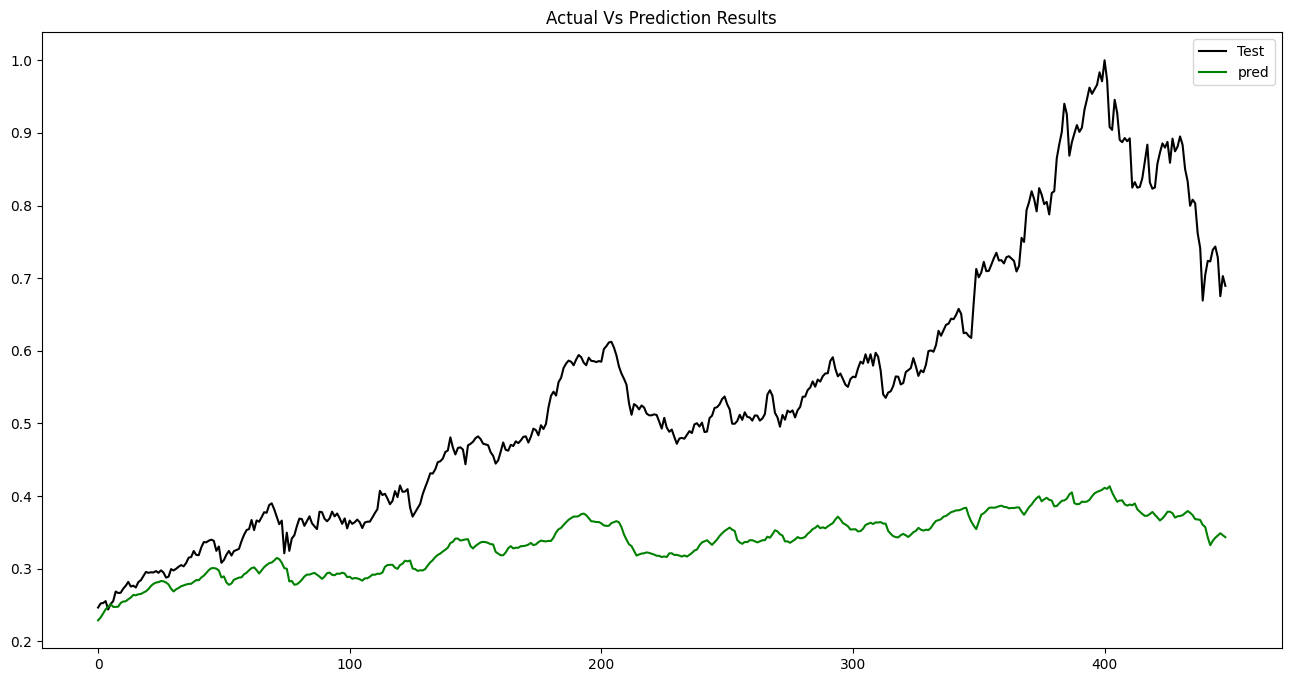

############################################################################
  Model Setup:
                    Name: ADM_F50_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.20813303025832264
             mean_sqr_err =0.06469677605843967
        root_mean_sqr_err =0.25435560944952573
           pred_diff_mean =0.6623151092637601
      pred_diff_bias_mean =0.33768489073623986
    pred_correctness_mean =0.31403118040089084



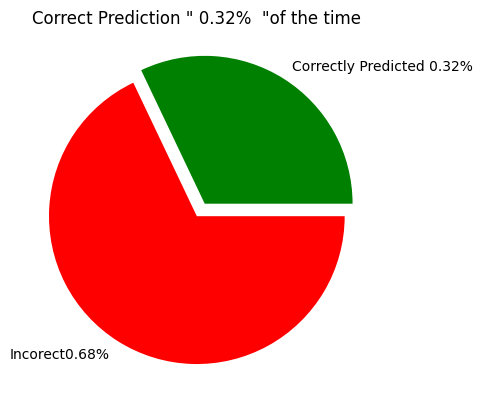

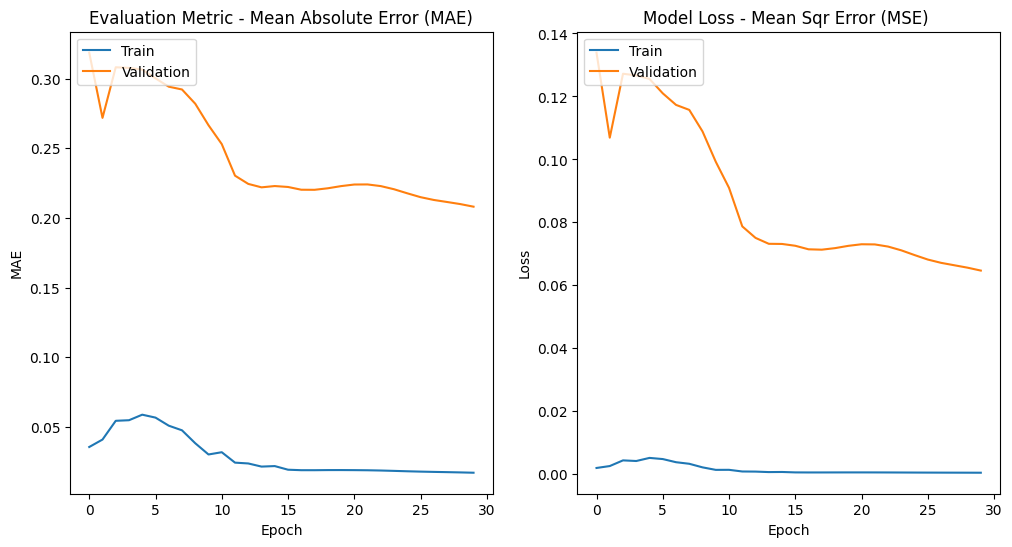

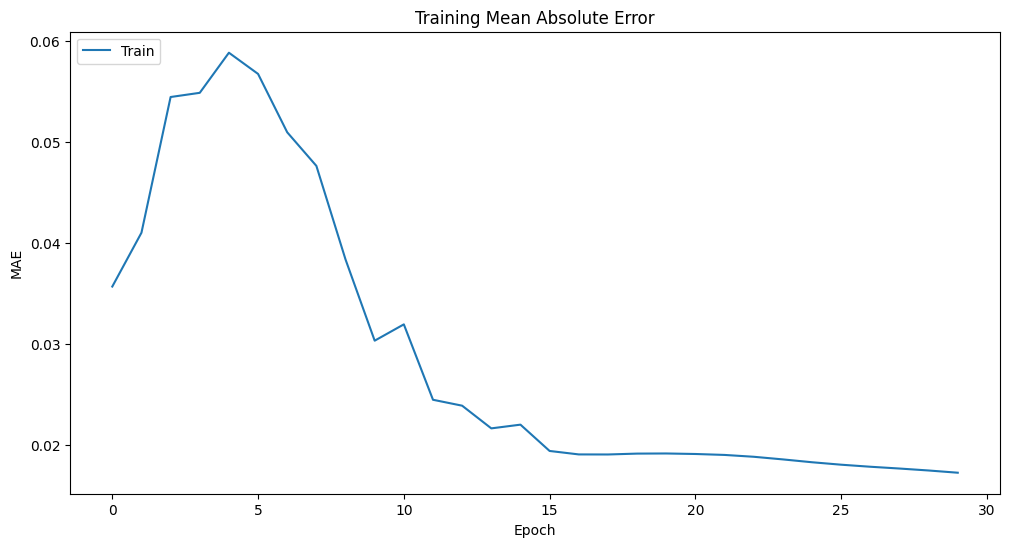

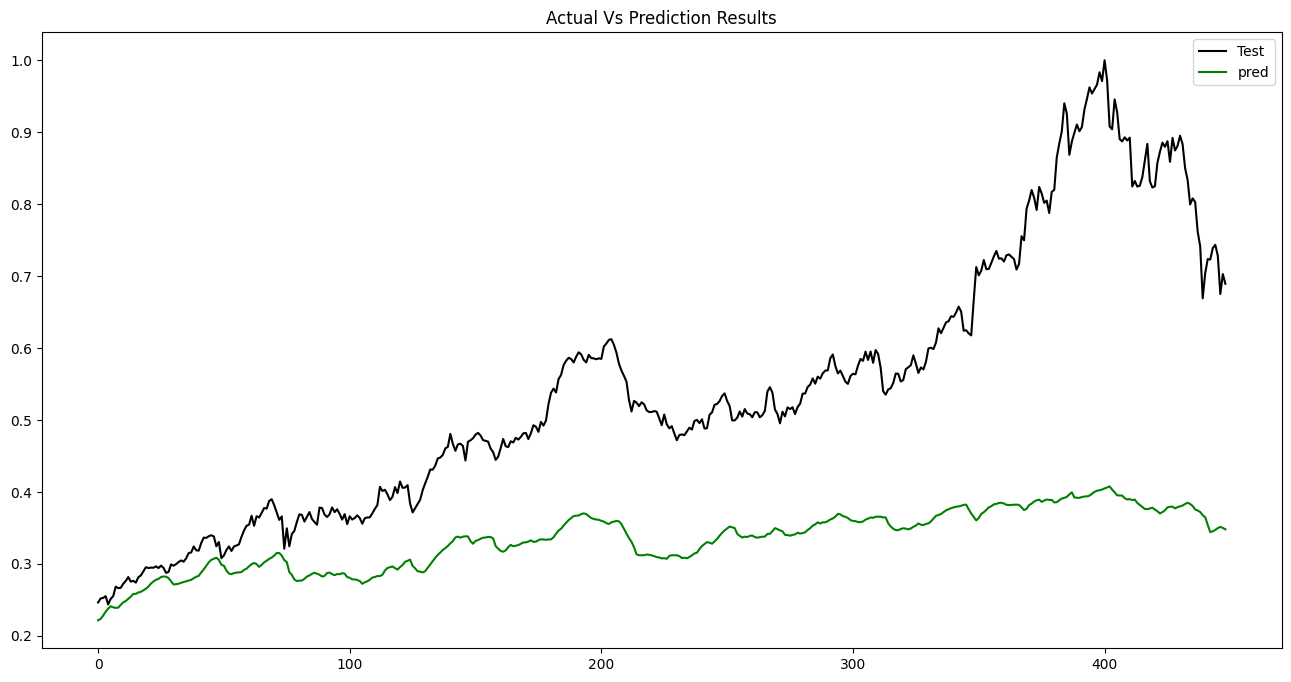

############################################################################
  Model Setup:
                    Name: ADM_F50_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.1948019310752252
             mean_sqr_err =0.05856510567193368
        root_mean_sqr_err =0.24200228443536165
           pred_diff_mean =0.6863969067464353
      pred_diff_bias_mean =0.3136030932535647
    pred_correctness_mean =0.35412026726057905



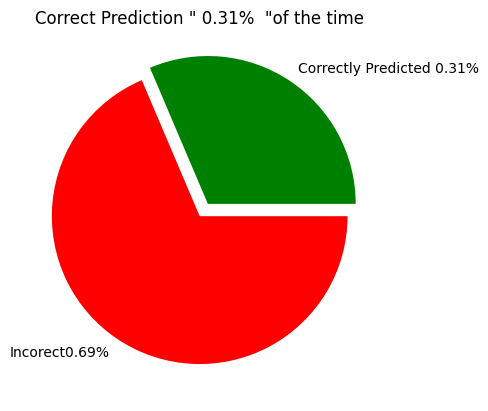

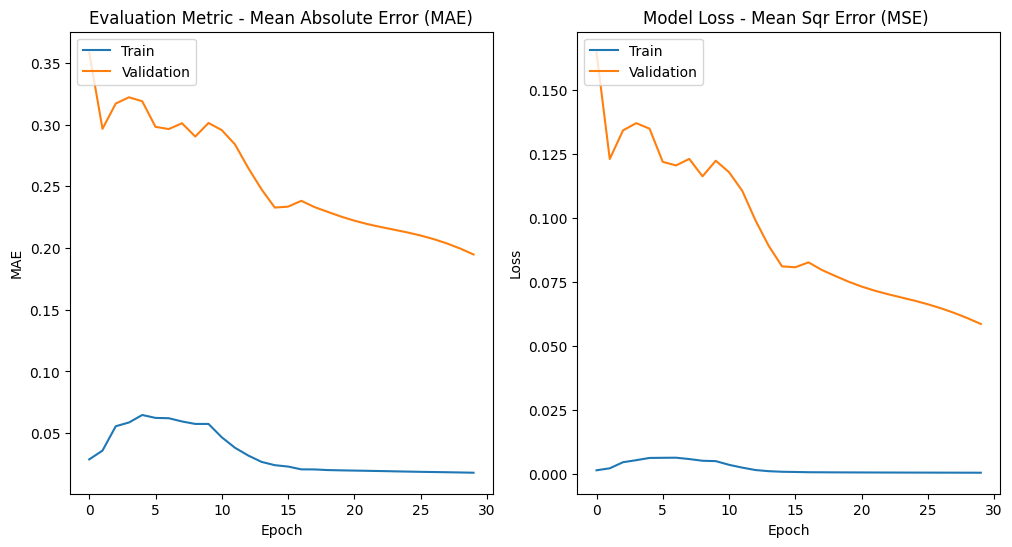

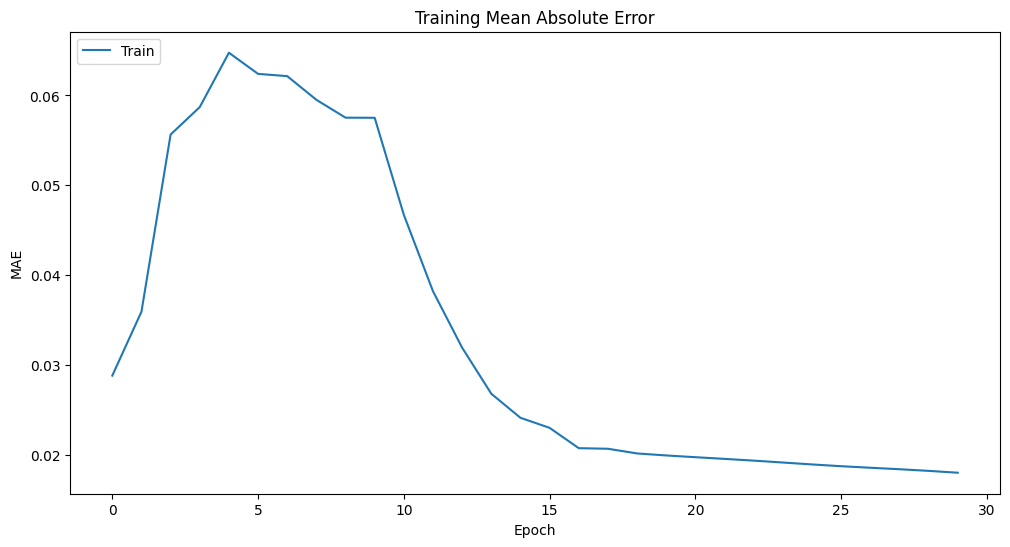

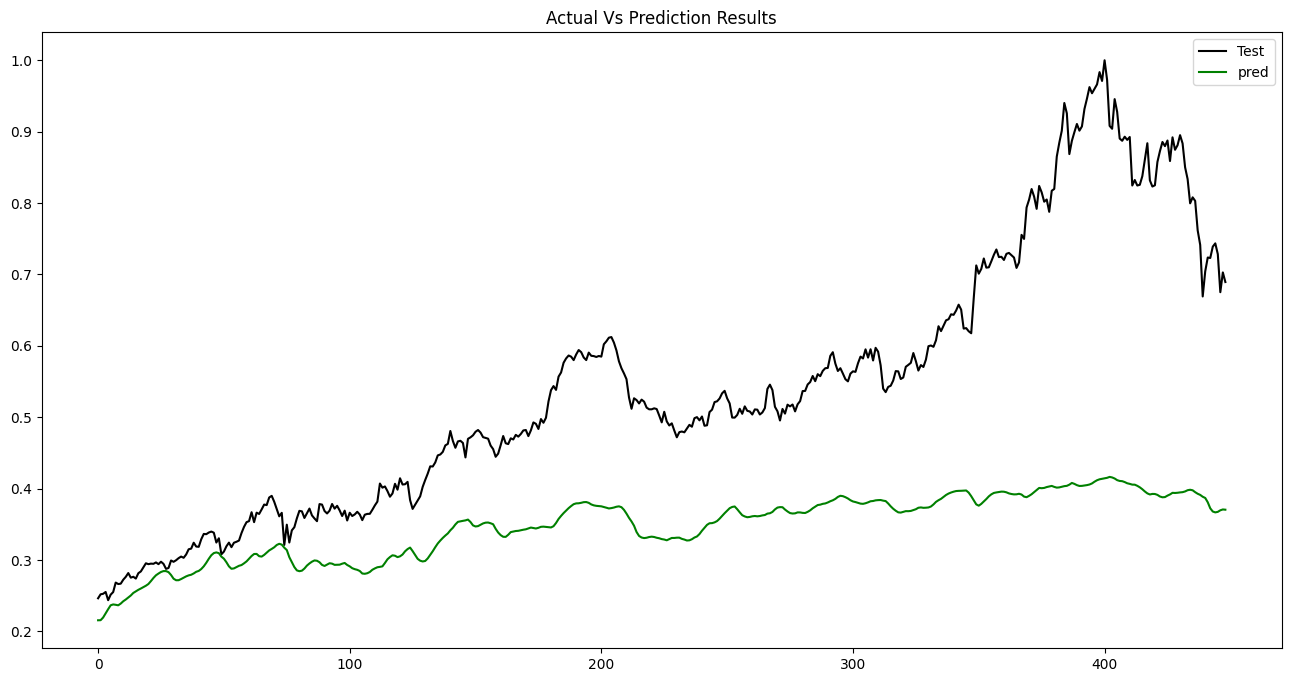

############################################################################
  Model Setup:
                    Name: ADM_F50_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.22122992994855775
             mean_sqr_err =0.07218013159803309
        root_mean_sqr_err =0.2686636030392526
           pred_diff_mean =0.6387702108442888
      pred_diff_bias_mean =0.3612297891557112
    pred_correctness_mean =0.3028953229398664



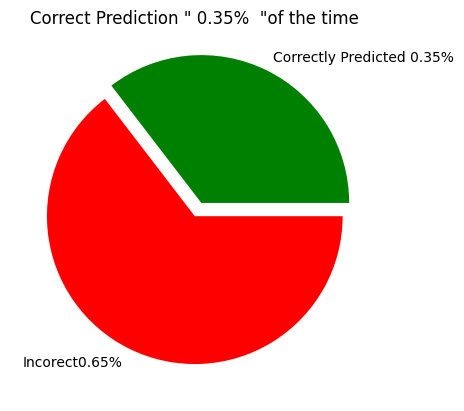

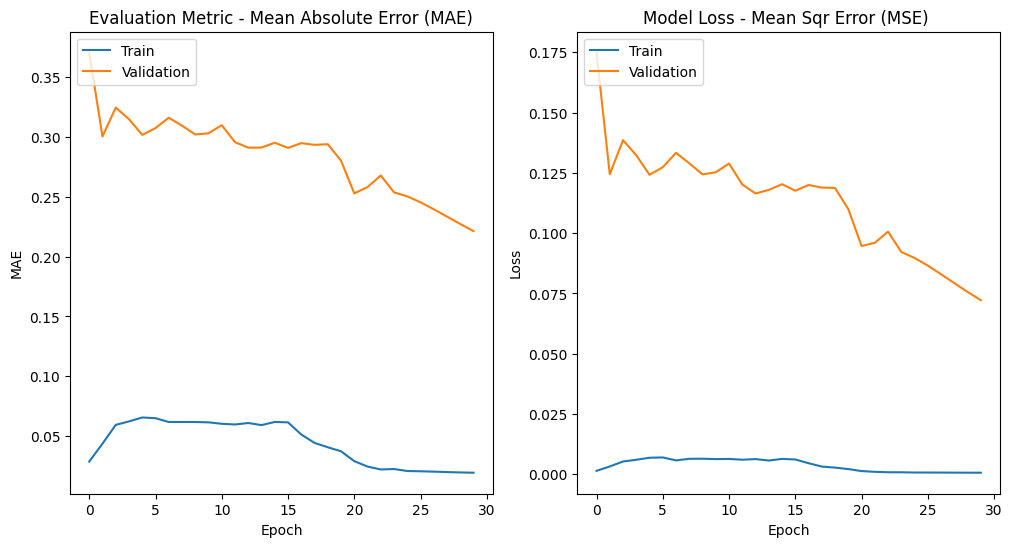

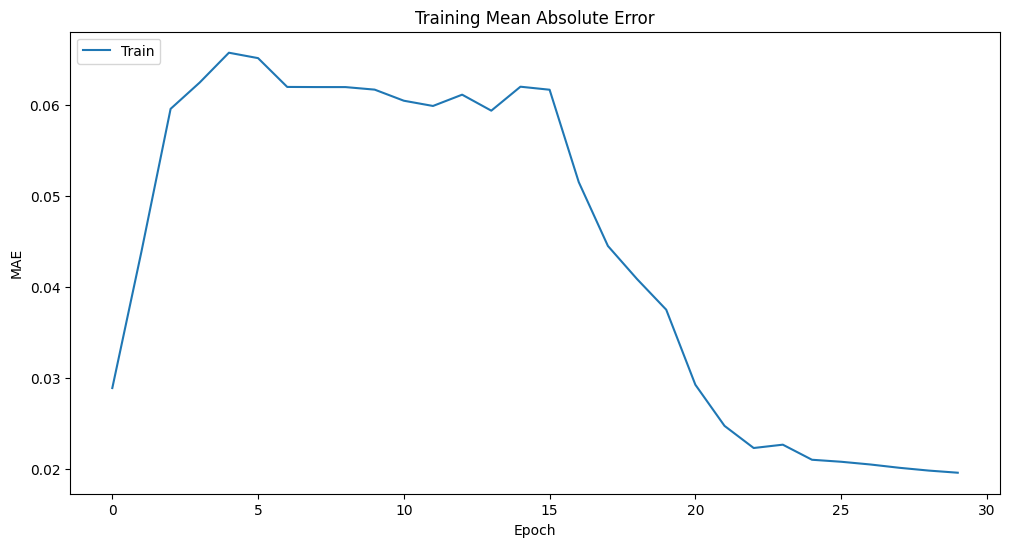

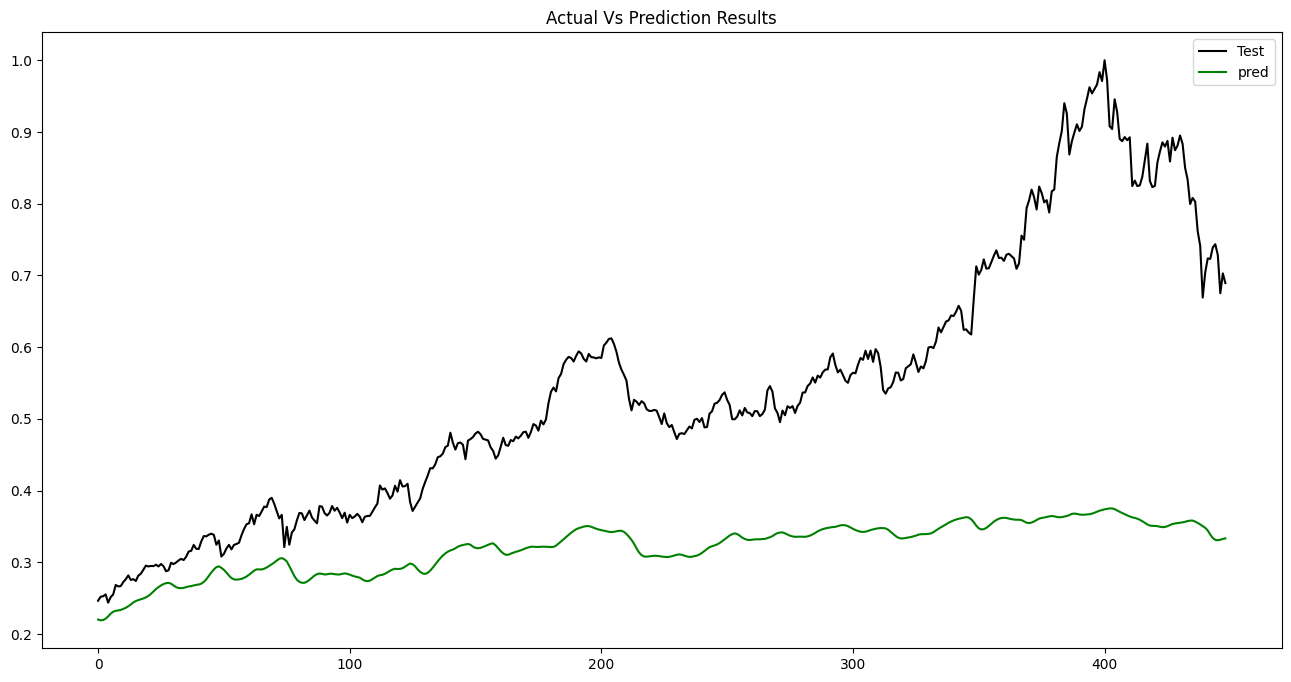

############################################################################
  Model Setup:
                    Name: ADM_F50_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.3015173875561945
             mean_sqr_err =0.12435239869925853
        root_mean_sqr_err =0.35263635476118815
           pred_diff_mean =0.496886255464279
      pred_diff_bias_mean =0.503113744535721
    pred_correctness_mean =0.24721603563474387



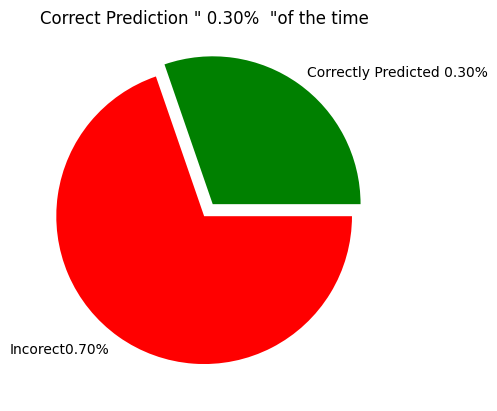

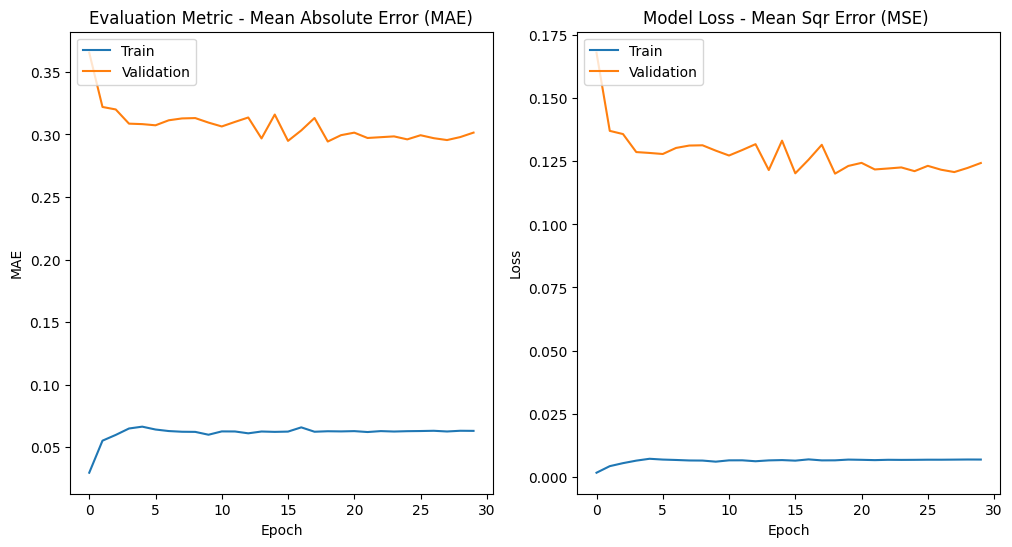

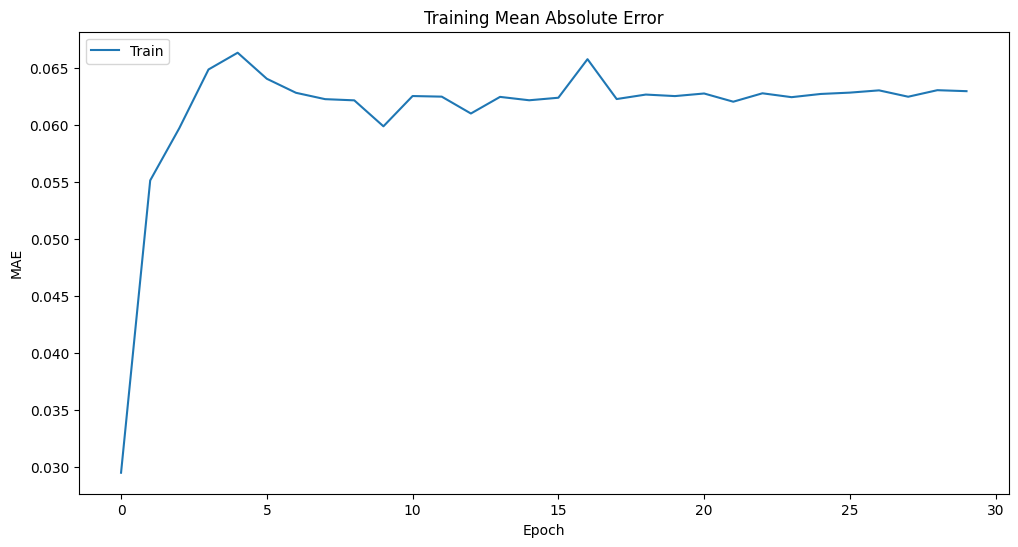

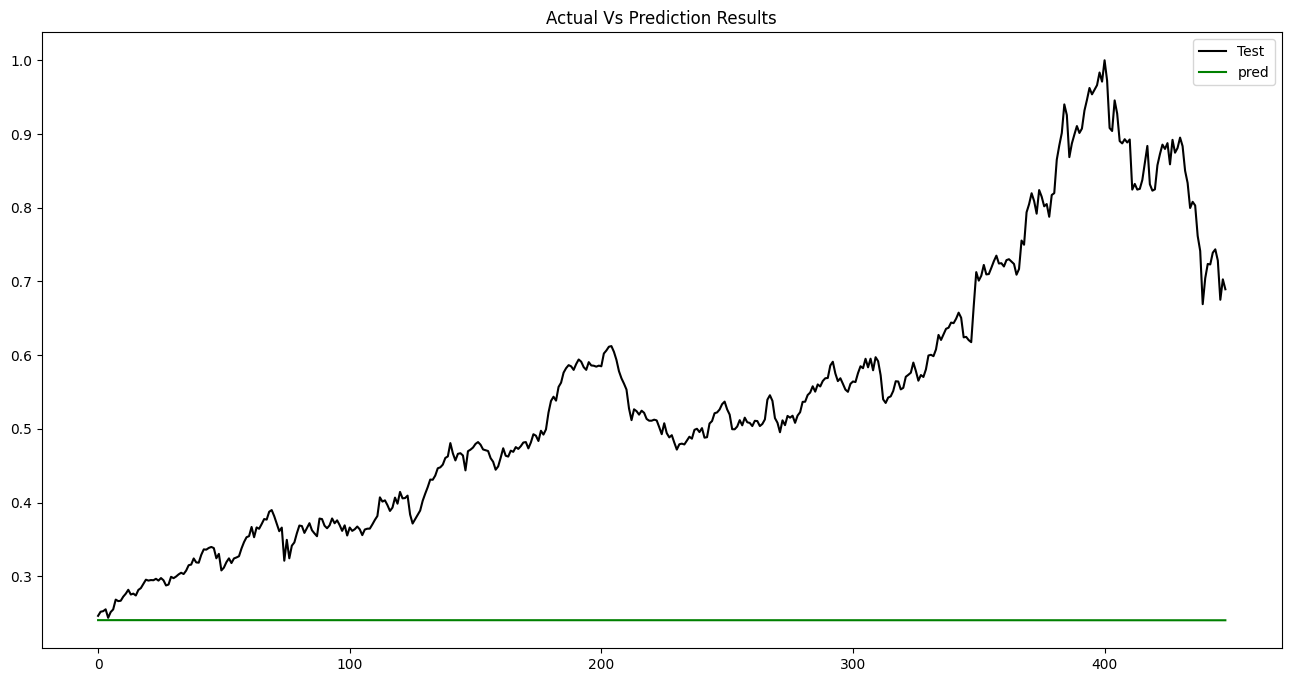

############################################################################
  Model Setup:
                    Name: ADM_F75_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.21151966897769875
             mean_sqr_err =0.06295693796337187
        root_mean_sqr_err =0.25091221166649474
           pred_diff_mean =0.6516225556635065
      pred_diff_bias_mean =0.3483774443364935
    pred_correctness_mean =0.32432432432432434



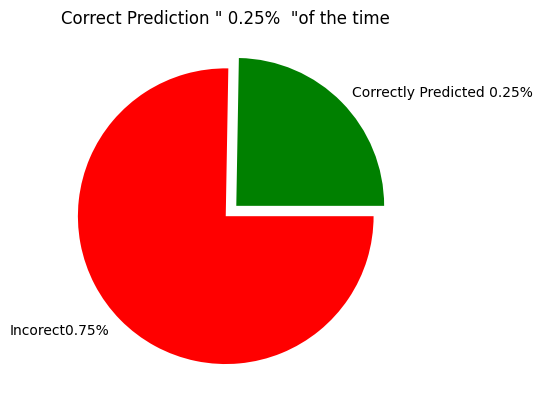

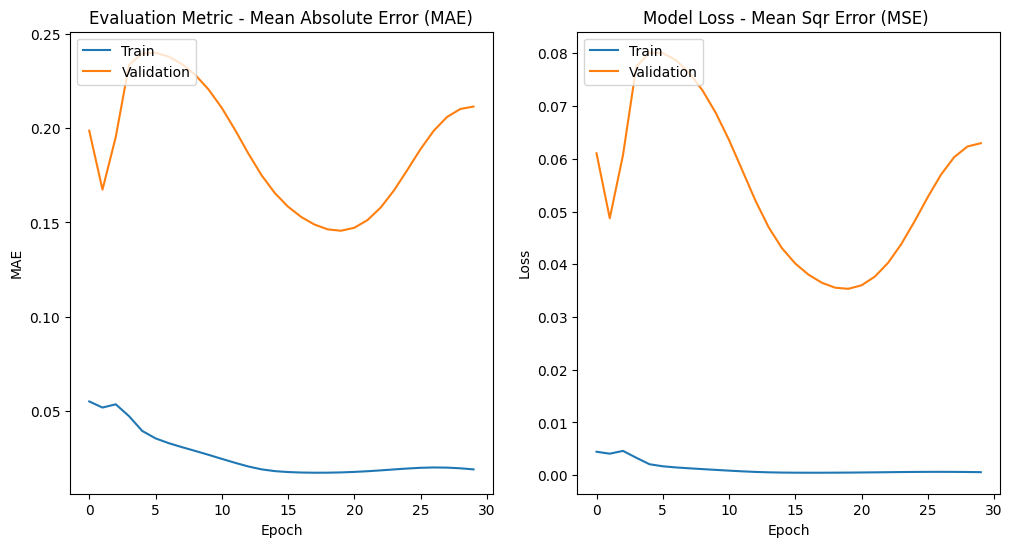

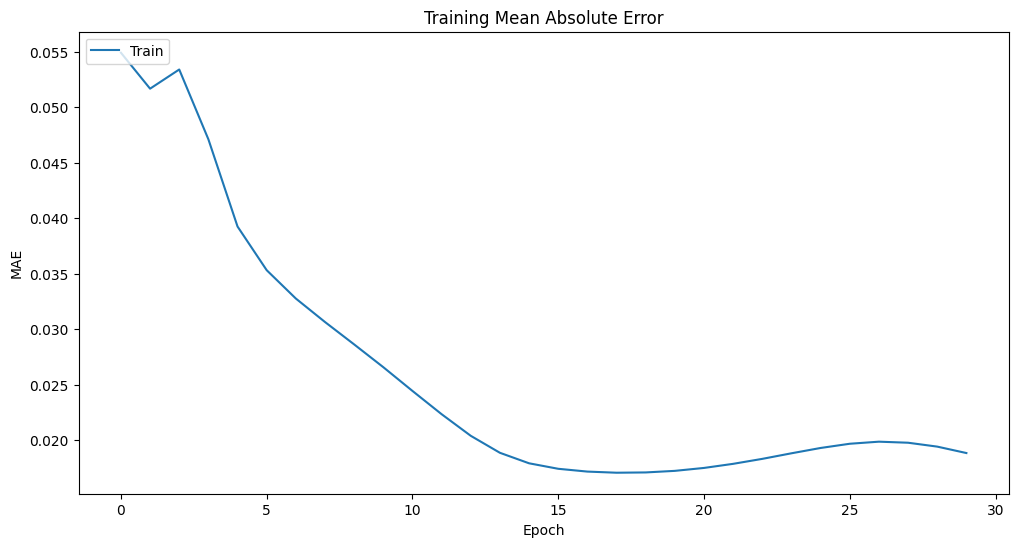

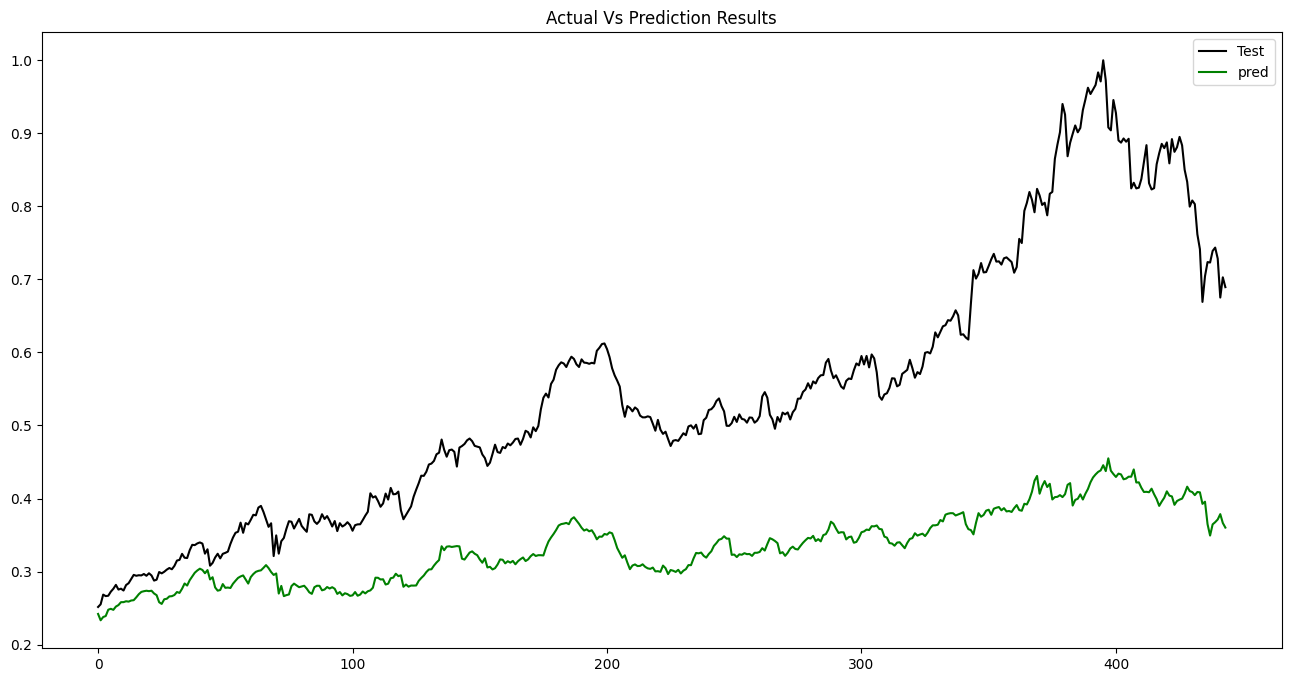

############################################################################
  Model Setup:
                    Name: ADM_F75_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.22133812258791064
             mean_sqr_err =0.07257572552806399
        root_mean_sqr_err =0.26939882243258595
           pred_diff_mean =0.6421681762223664
      pred_diff_bias_mean =0.3578318237776335
    pred_correctness_mean =0.34684684684684686



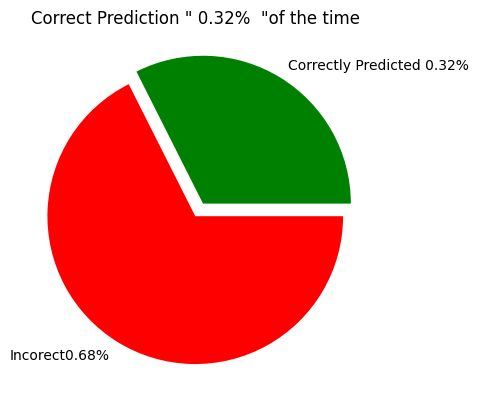

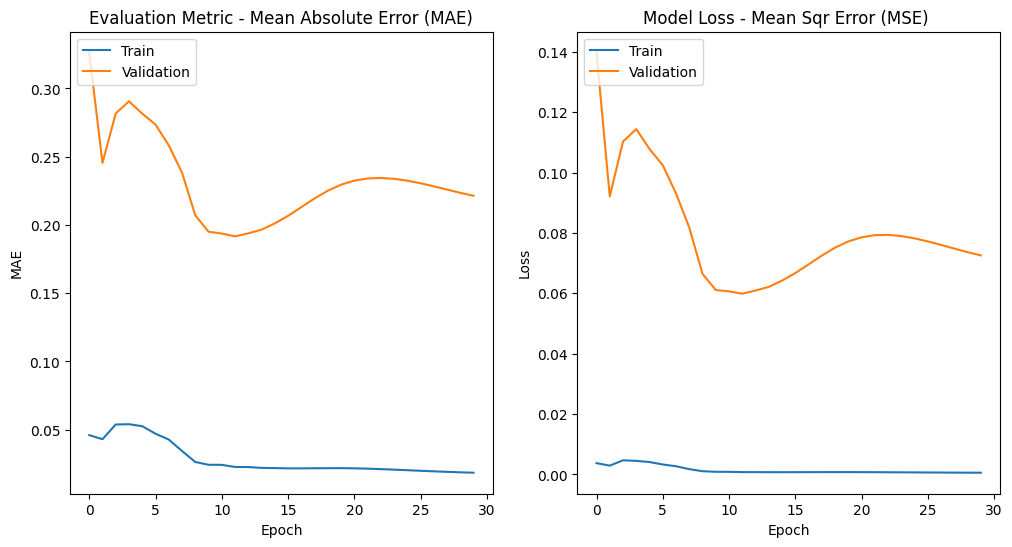

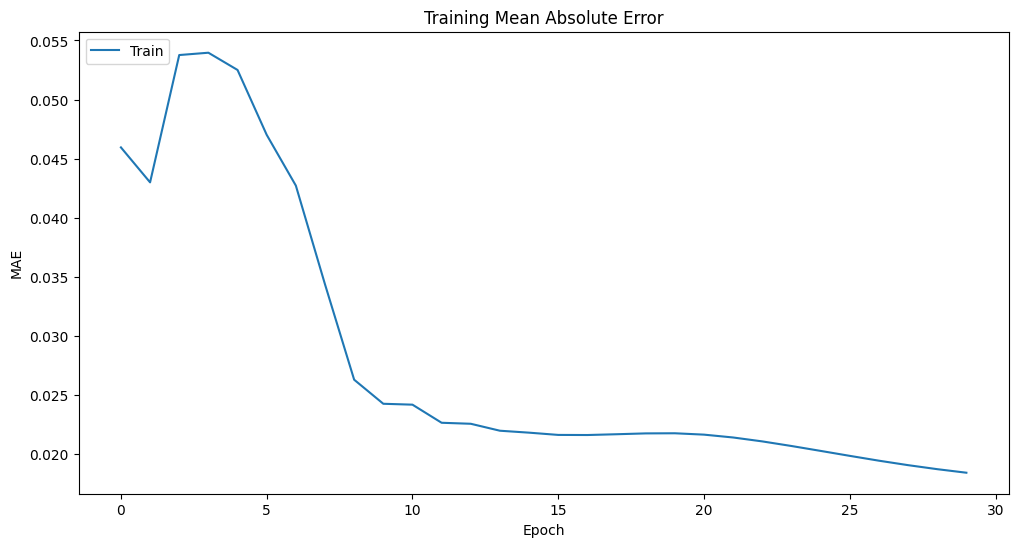

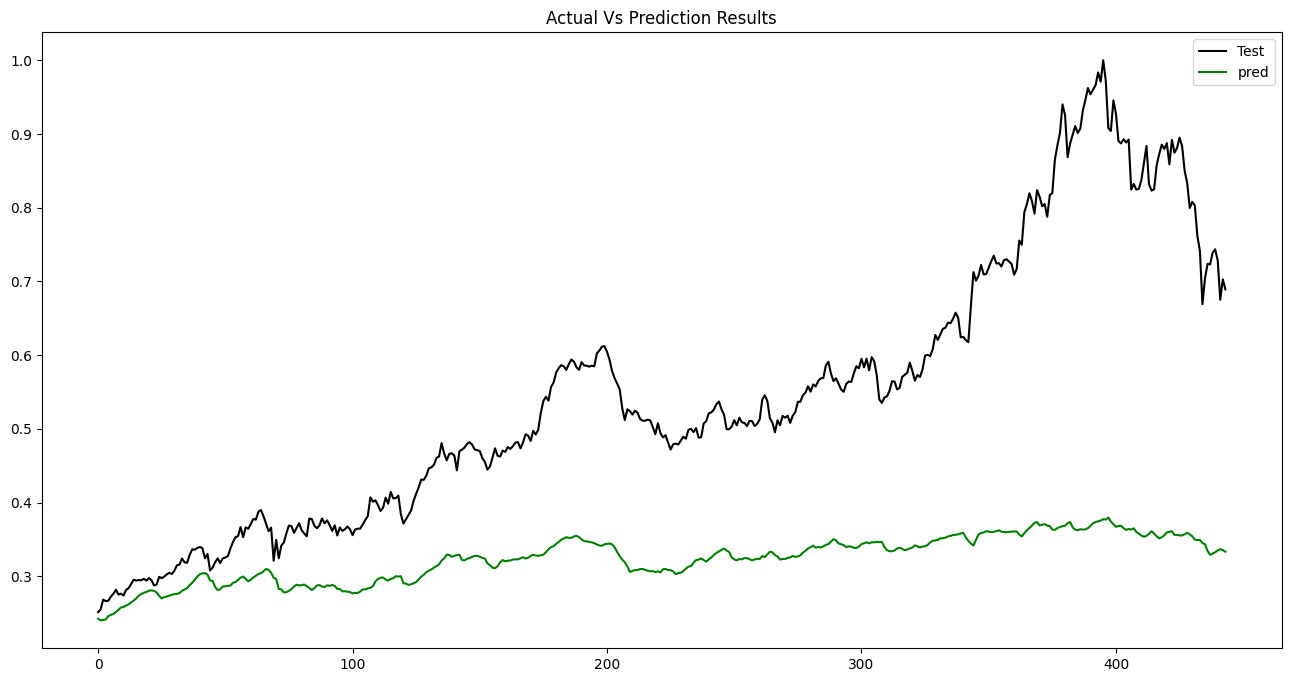

############################################################################
  Model Setup:
                    Name: ADM_F75_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.22782694341110538
             mean_sqr_err =0.07508749725736609
        root_mean_sqr_err =0.27402097959347216
           pred_diff_mean =0.6281354470632352
      pred_diff_bias_mean =0.3718645529367648
    pred_correctness_mean =0.3063063063063063



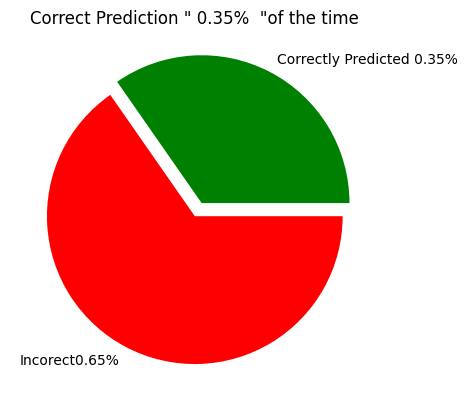

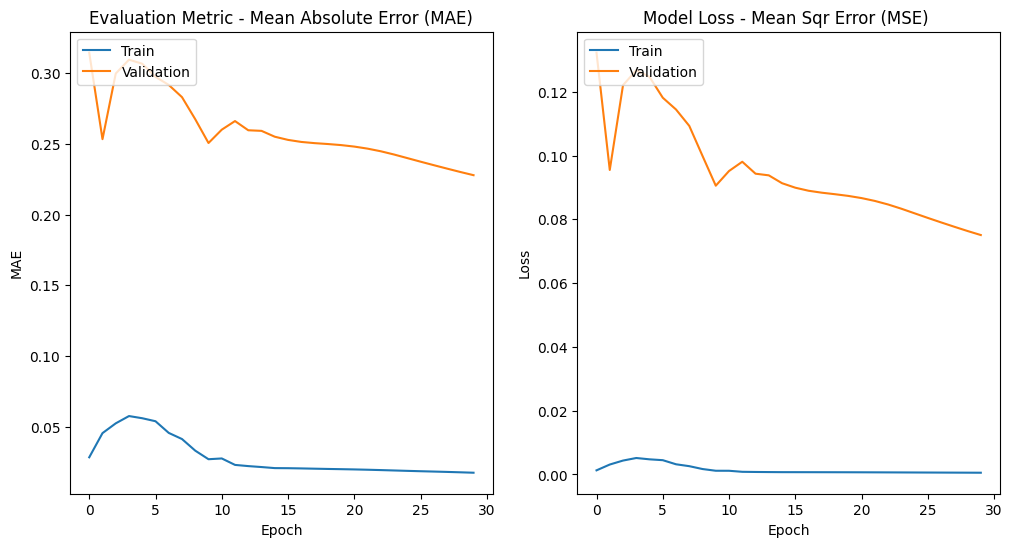

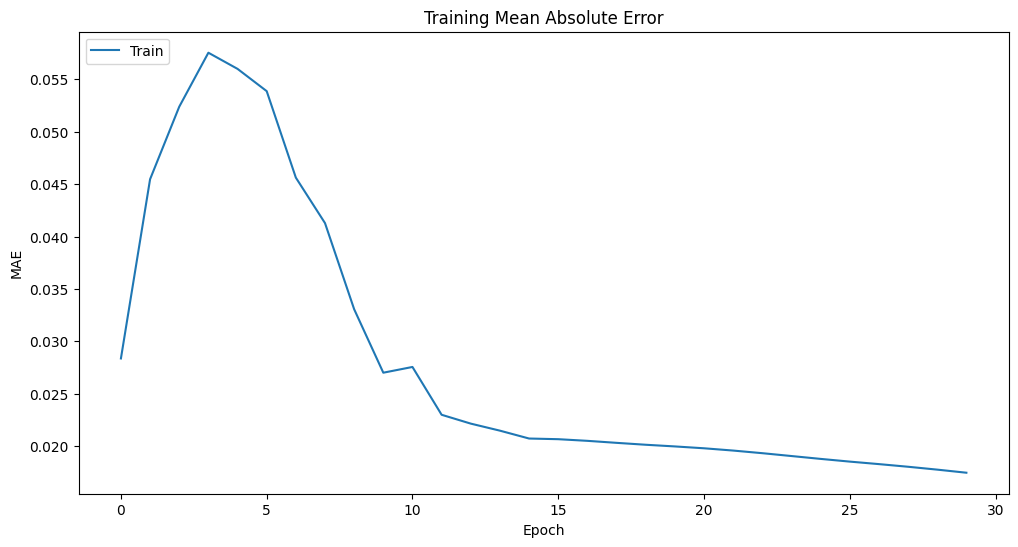

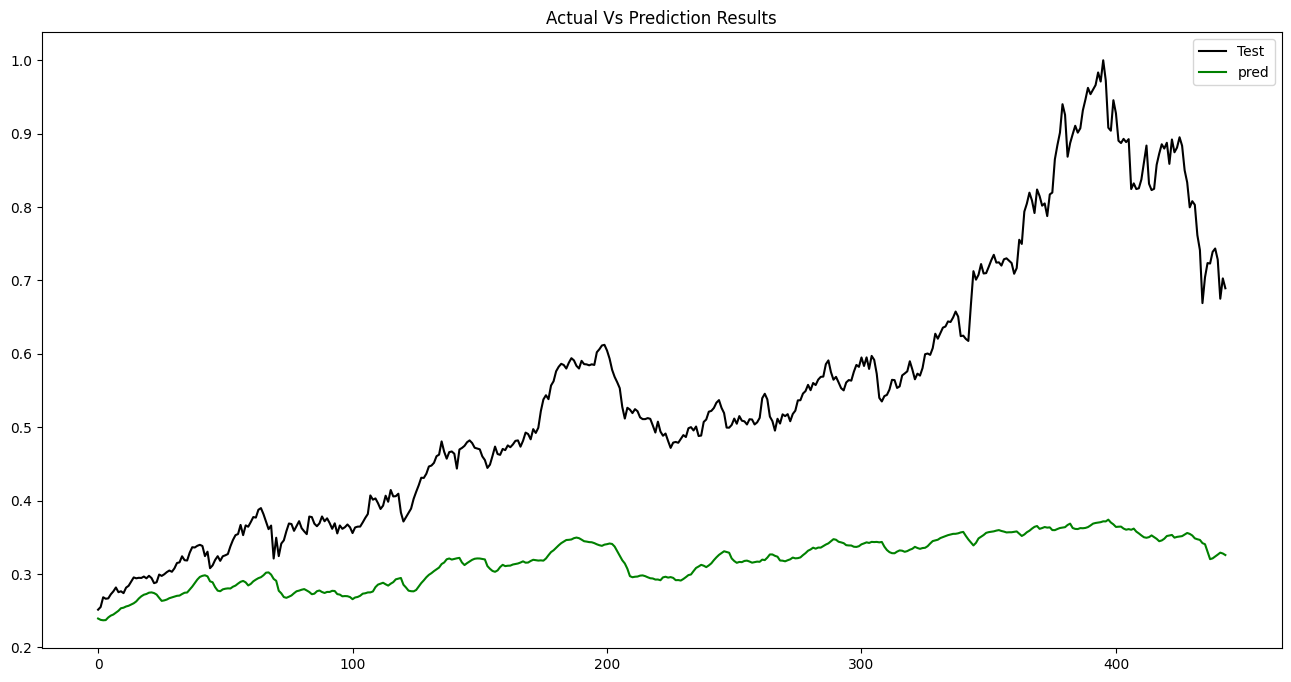

############################################################################
  Model Setup:
                    Name: ADM_F75_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.16745182271745912
             mean_sqr_err =0.04513389561162705
        root_mean_sqr_err =0.21244739492784337
           pred_diff_mean =0.7349690963180737
      pred_diff_bias_mean =0.2650309036819263
    pred_correctness_mean =0.536036036036036



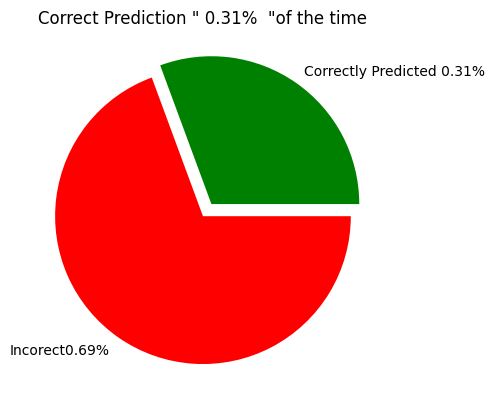

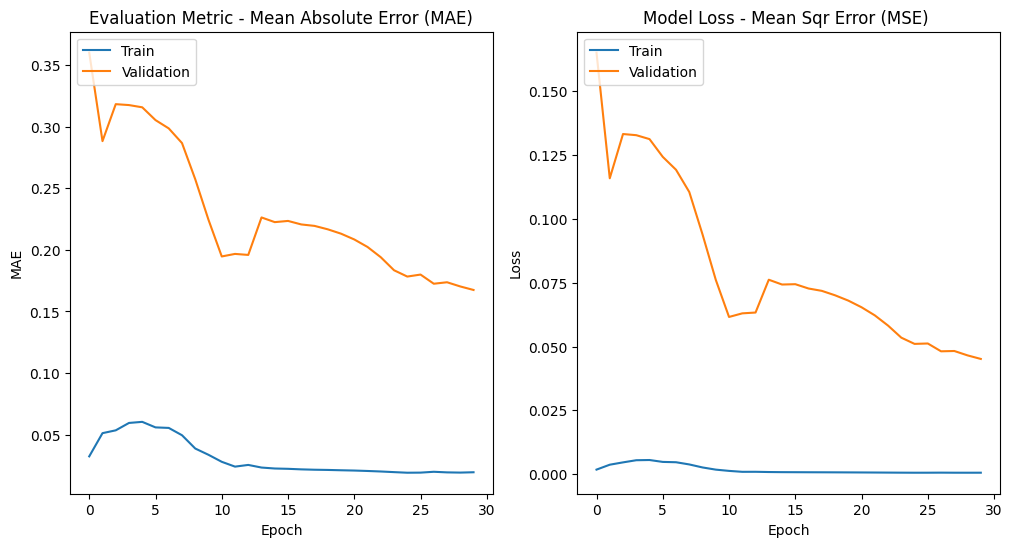

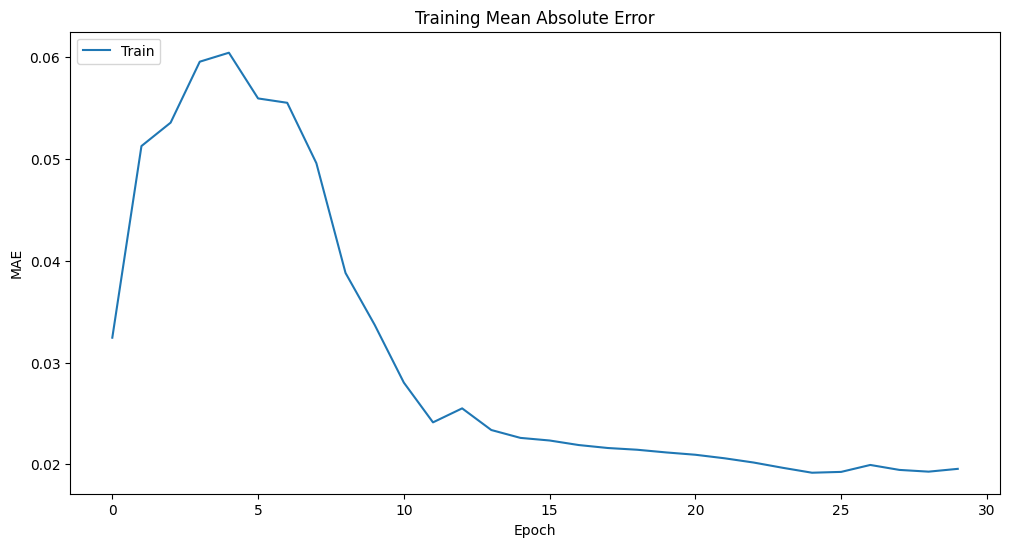

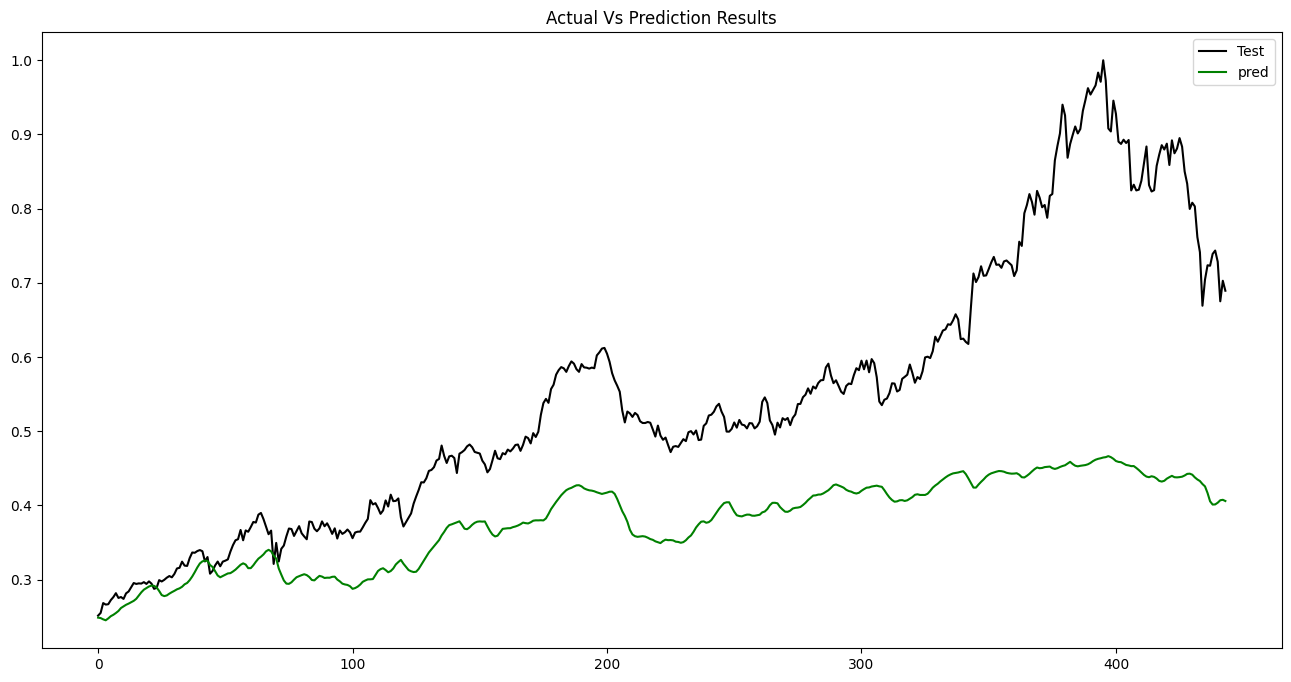

############################################################################
  Model Setup:
                    Name: ADM_F75_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.302694632906525
             mean_sqr_err =0.12452803661537627
        root_mean_sqr_err =0.3528853023510278
           pred_diff_mean =0.49607196193099423
      pred_diff_bias_mean =0.5039280380690058
    pred_correctness_mean =0.2635135135135135



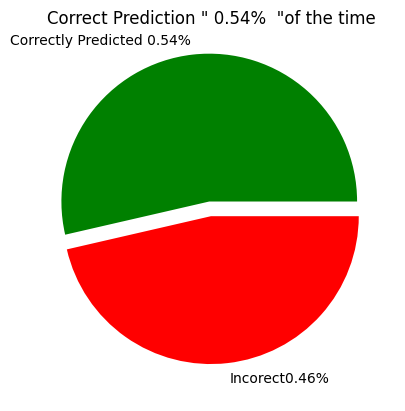

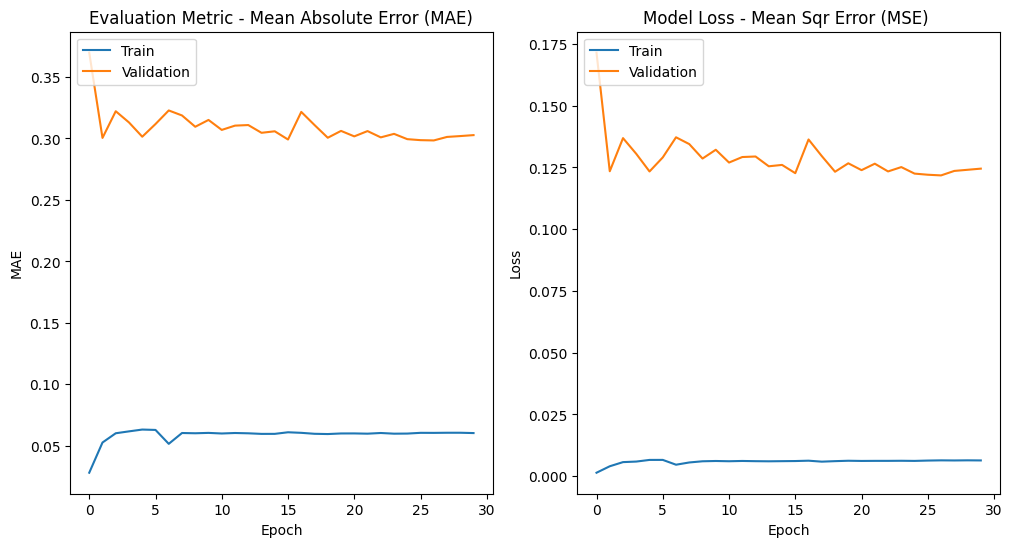

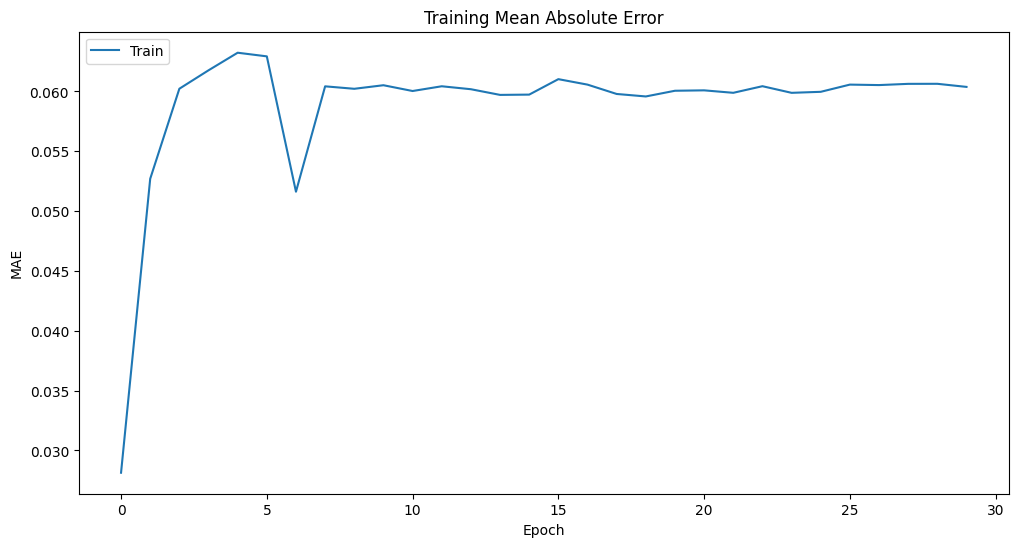

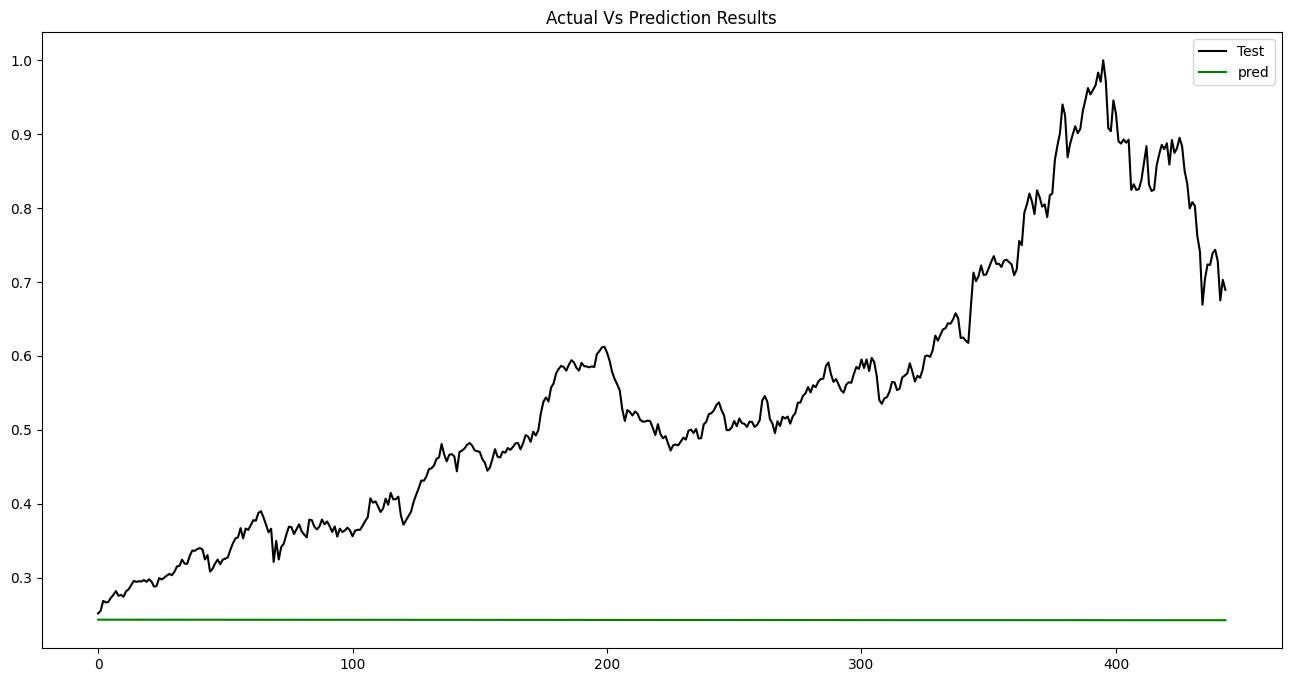

############################################################################
  Model Setup:
                    Name: ADM_F75_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.3090016744307548
             mean_sqr_err =0.12831065104634243
        root_mean_sqr_err =0.35820476133957574
           pred_diff_mean =0.48303609994952135
      pred_diff_bias_mean =0.5169639000504788
    pred_correctness_mean =0.25675675675675674



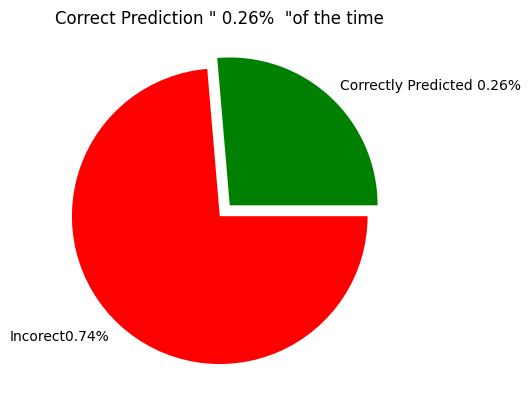

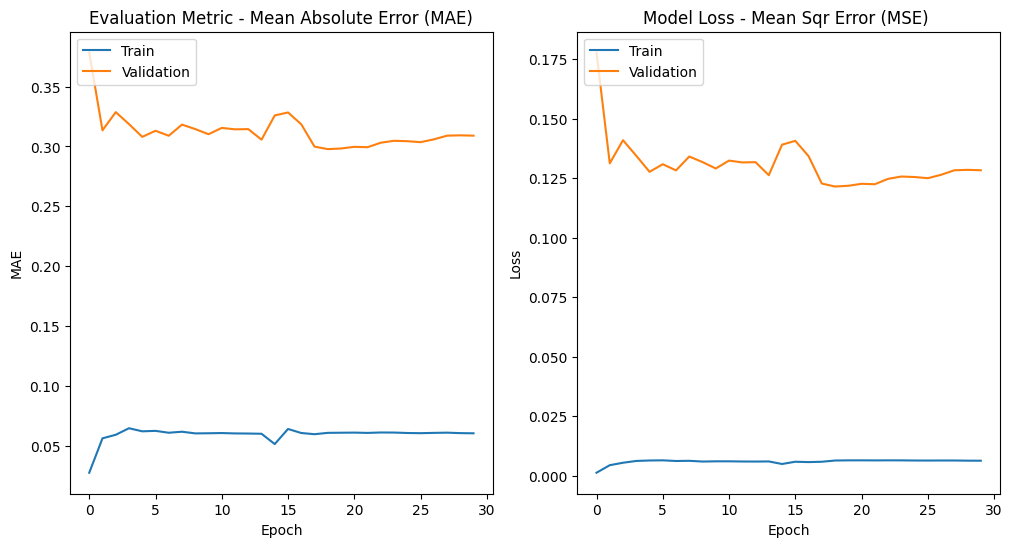

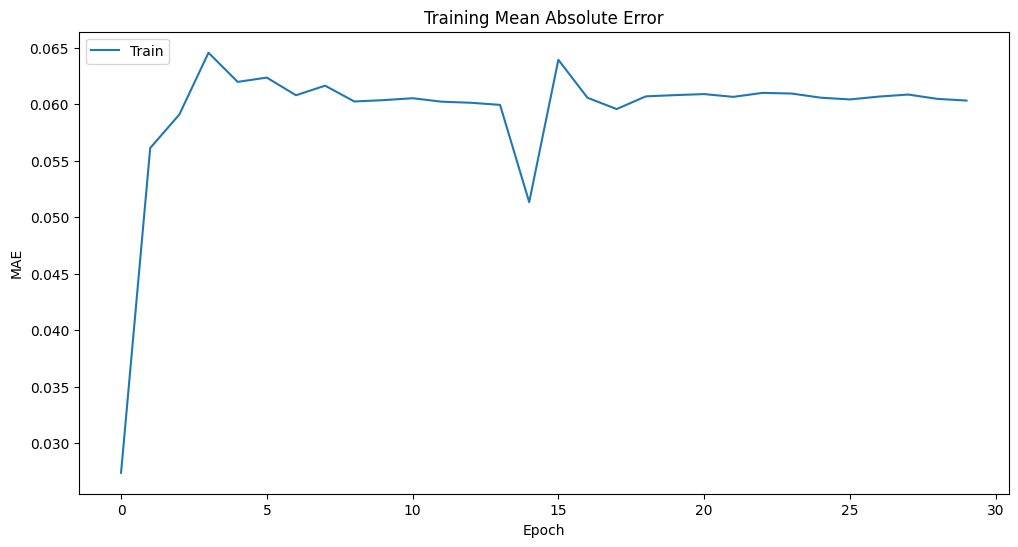

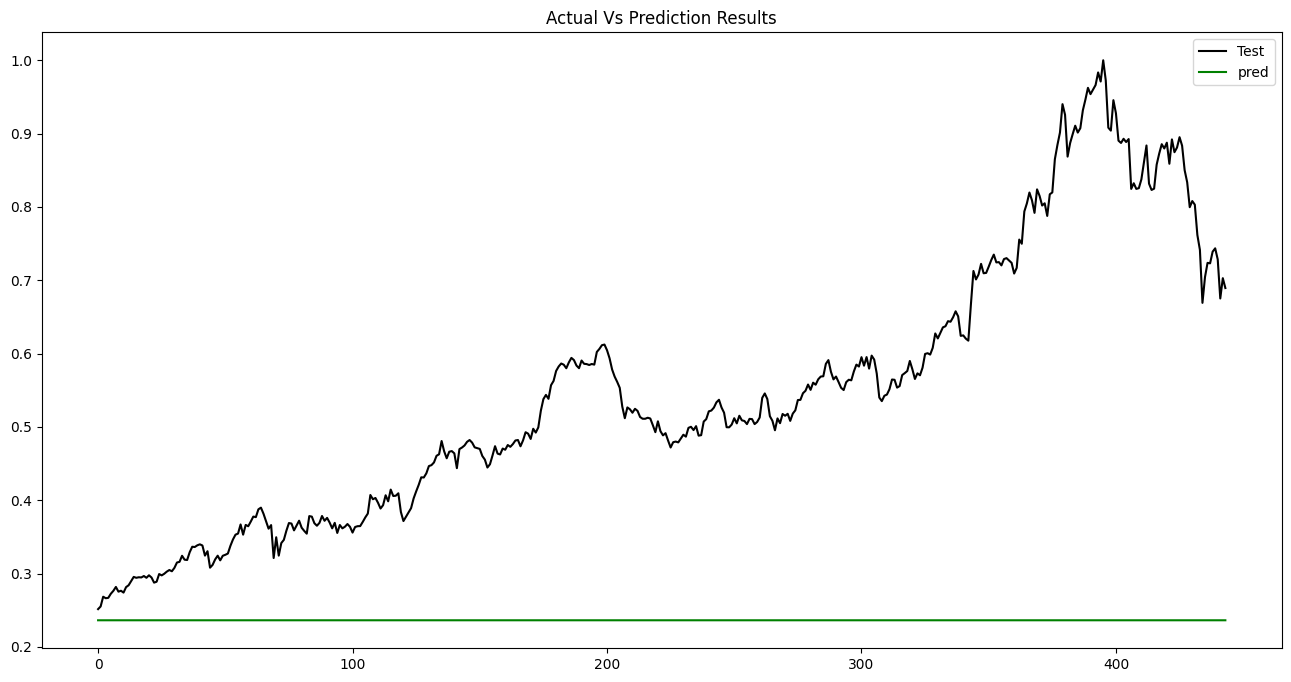

############################################################################
  Model Setup:
                    Name: ADM_F100_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.19948544154831588
             mean_sqr_err =0.05866443610850892
        root_mean_sqr_err =0.24220742372707926
           pred_diff_mean =0.678672567278762
      pred_diff_bias_mean =0.3213274327212379
    pred_correctness_mean =0.4715261958997722



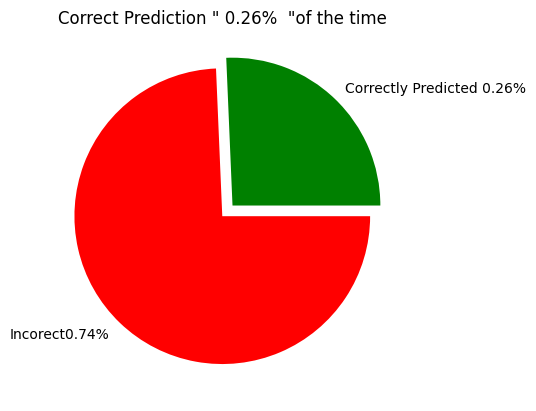

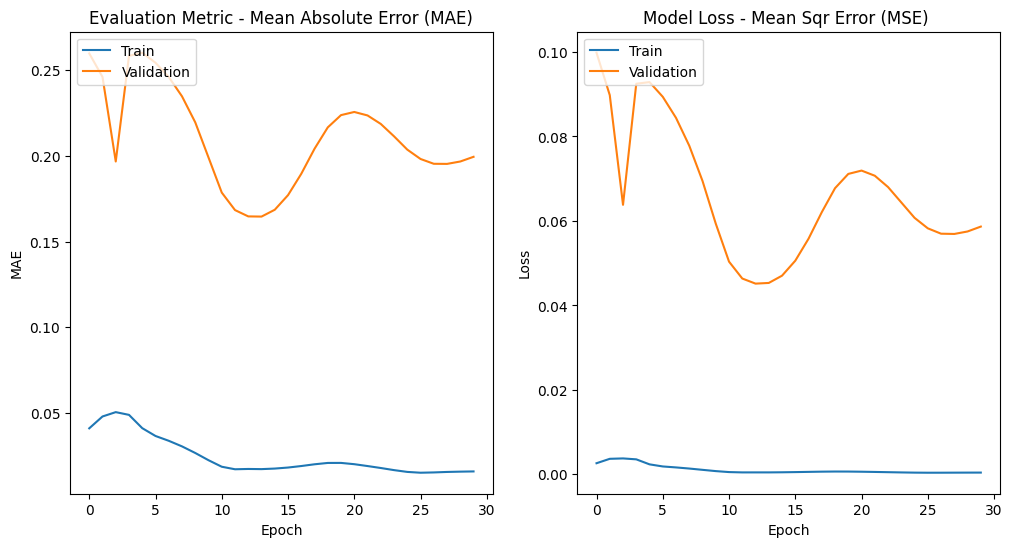

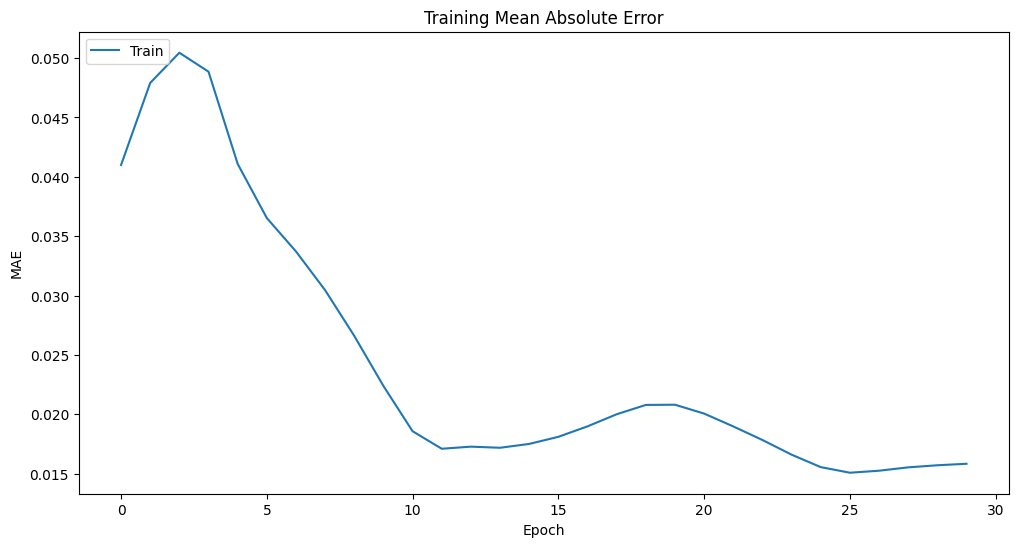

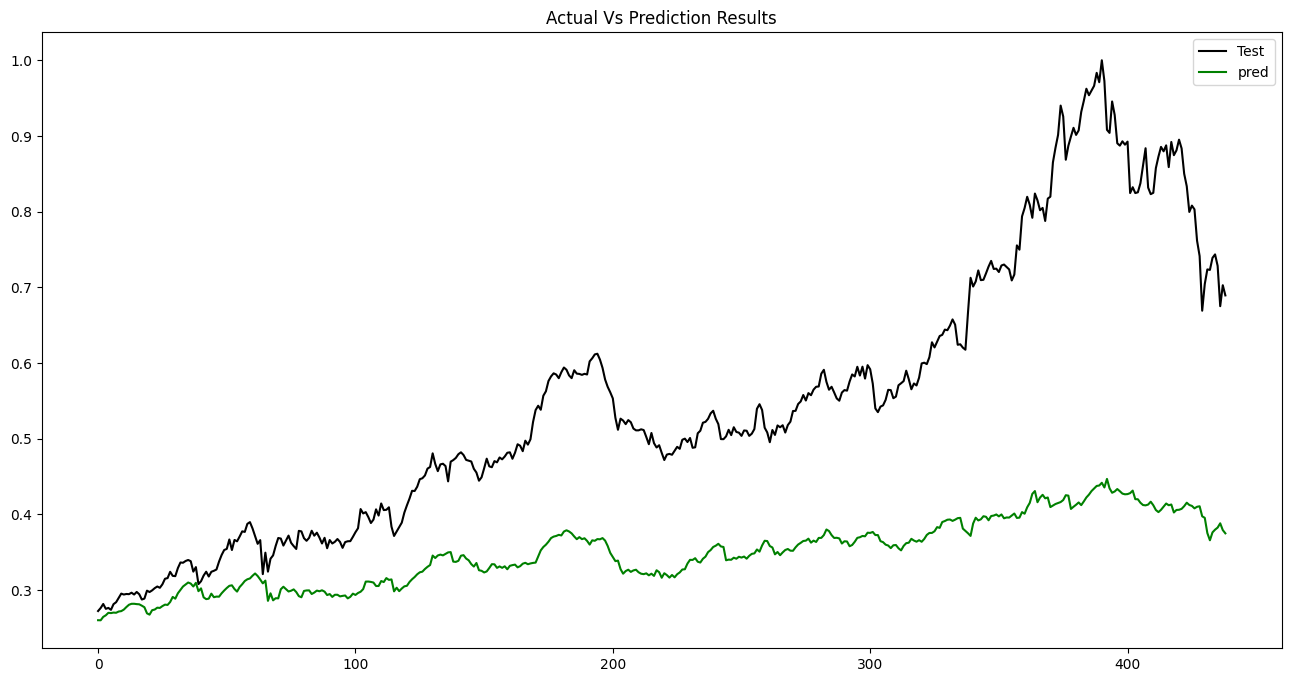

############################################################################
  Model Setup:
                    Name: ADM_F100_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.19379963141102996
             mean_sqr_err =0.05635175359522343
        root_mean_sqr_err =0.23738524300222083
           pred_diff_mean =0.6887843561782111
      pred_diff_bias_mean =0.3112156438217889
    pred_correctness_mean =0.4783599088838269



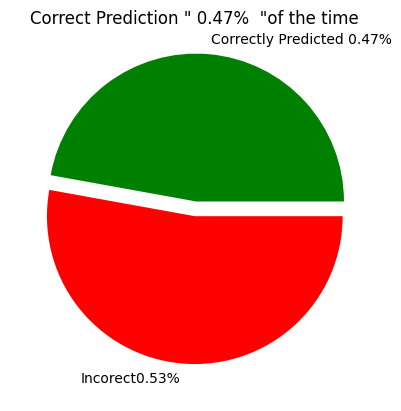

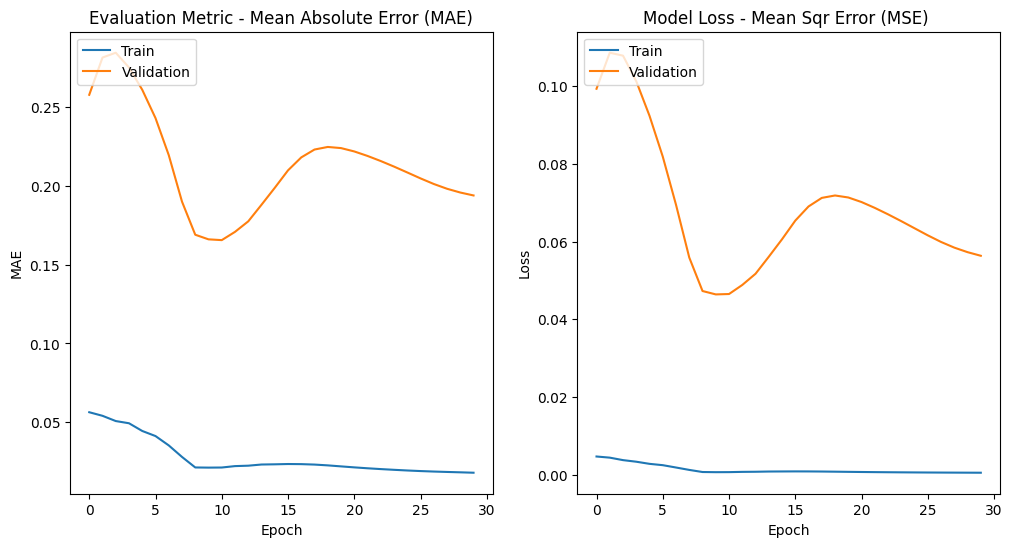

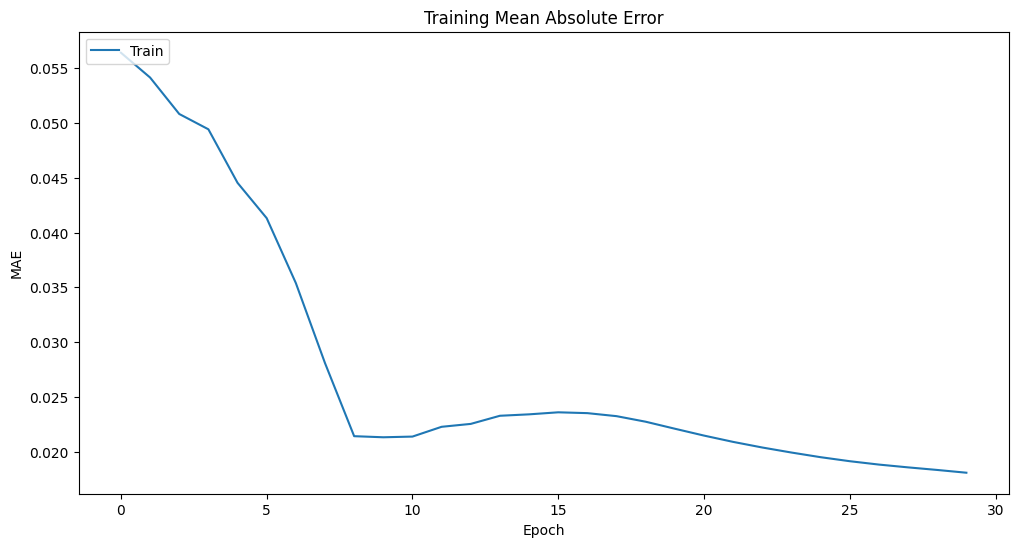

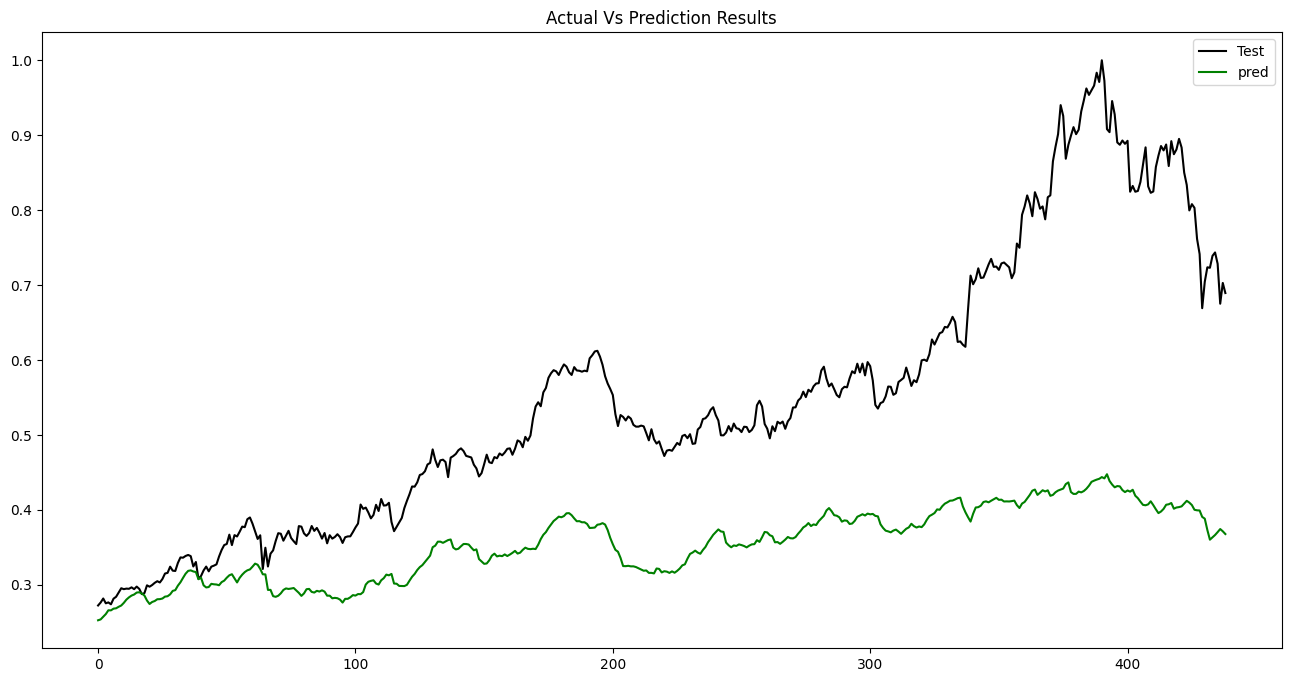

############################################################################
  Model Setup:
                    Name: ADM_F100_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.22415759755719705
             mean_sqr_err =0.07339580441517882
        root_mean_sqr_err =0.27091660047914895
           pred_diff_mean =0.6370179728565308
      pred_diff_bias_mean =0.3629820271434692
    pred_correctness_mean =0.42369020501138954



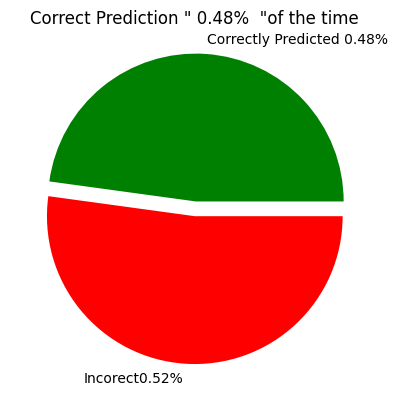

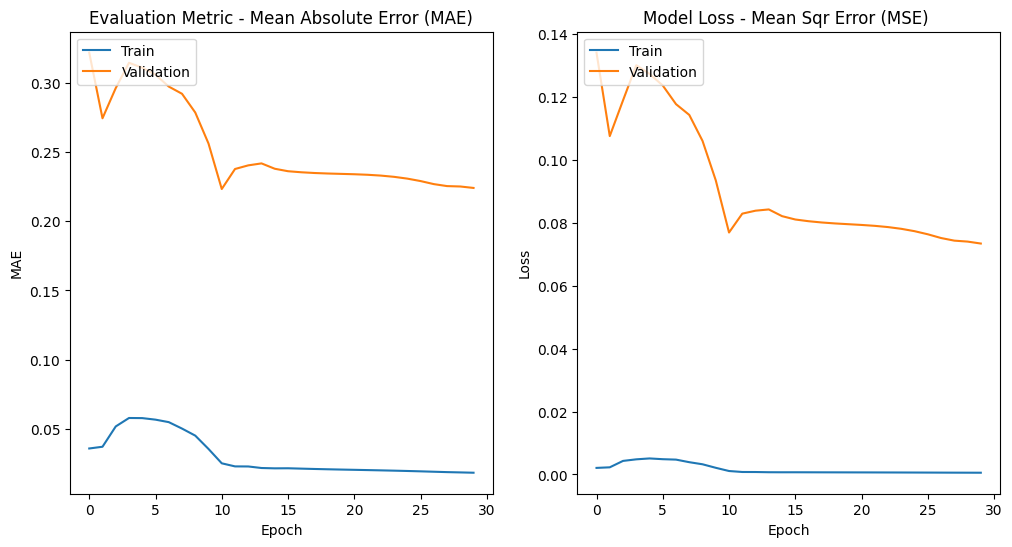

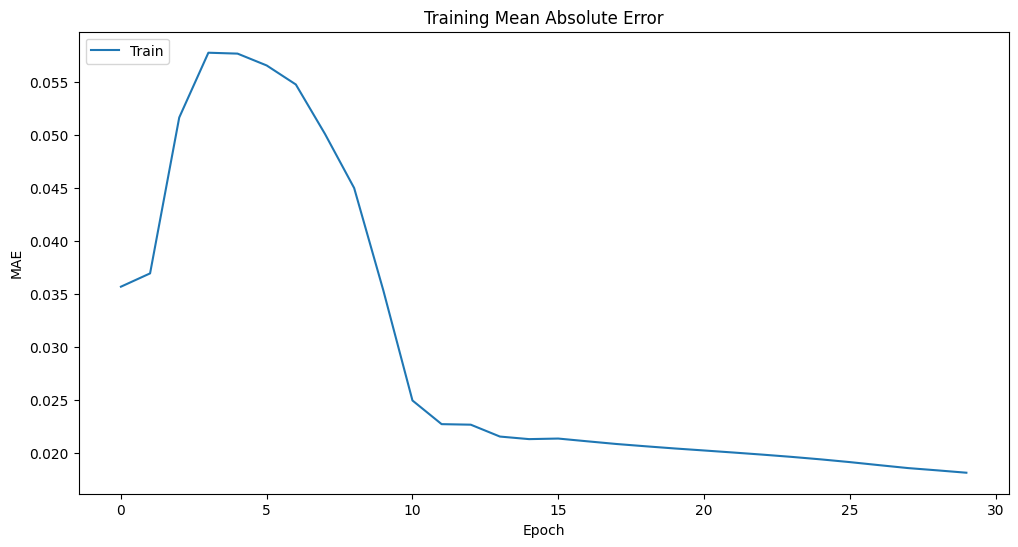

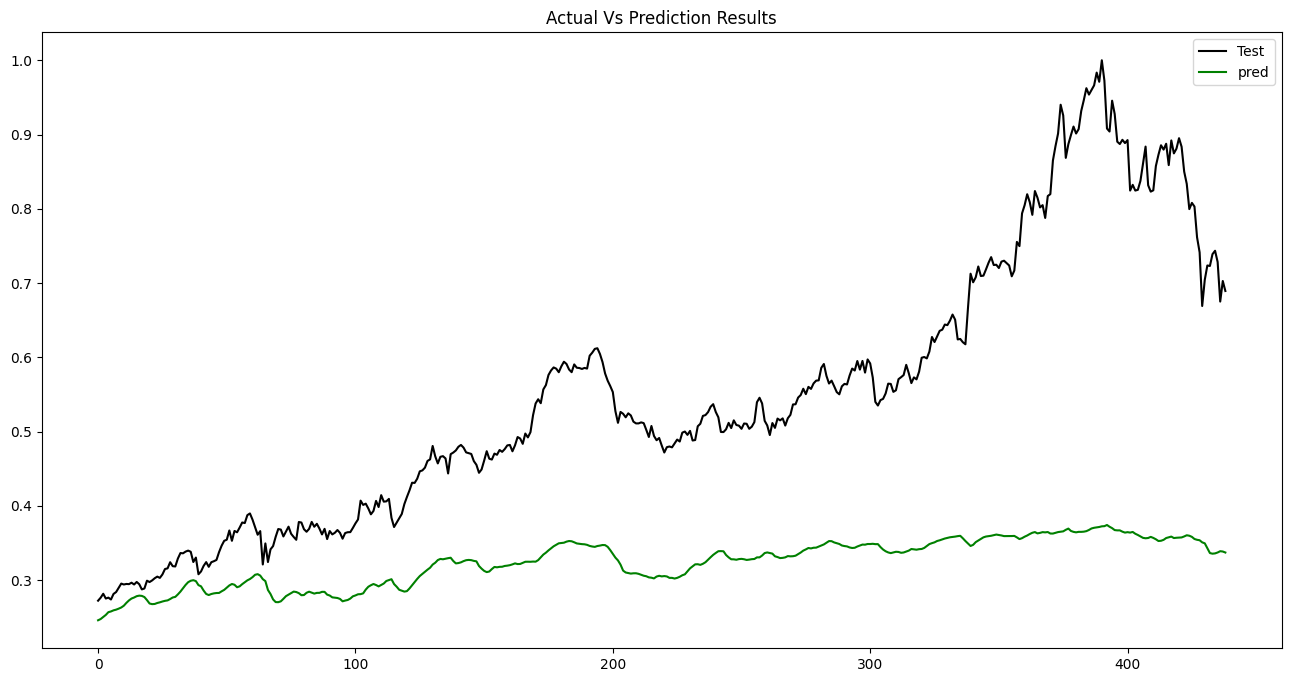

############################################################################
  Model Setup:
                    Name: ADM_F100_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.20562968371008622
             mean_sqr_err =0.06331448996354655
        root_mean_sqr_err =0.25162370707774445
           pred_diff_mean =0.6693035543044107
      pred_diff_bias_mean =0.3306964456955893
    pred_correctness_mean =0.4715261958997722



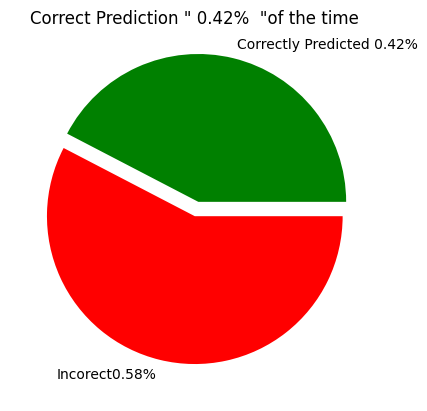

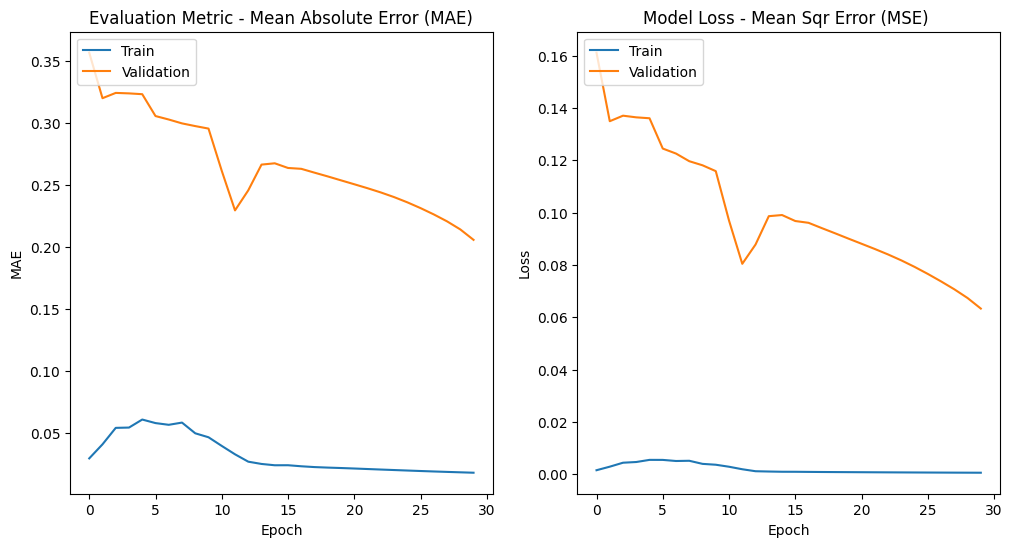

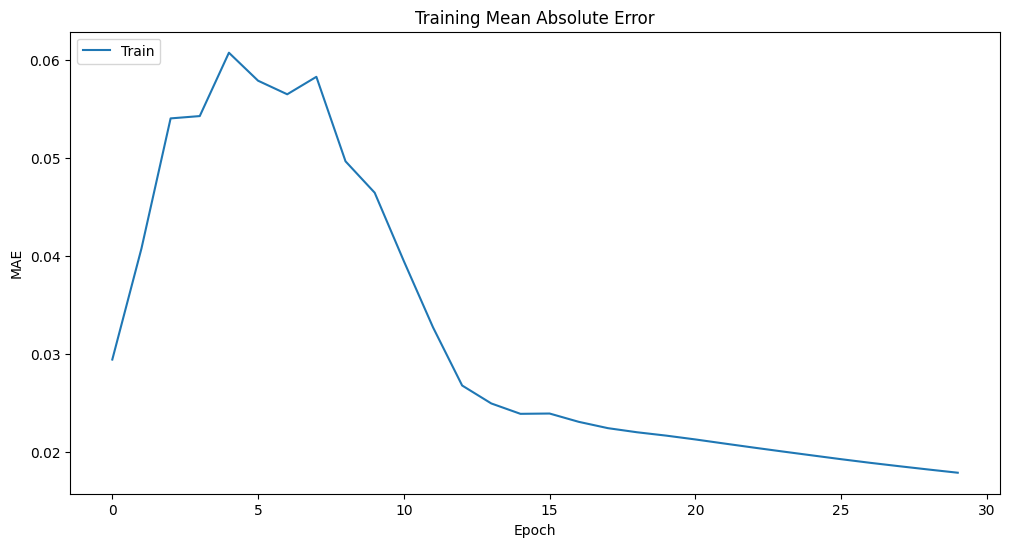

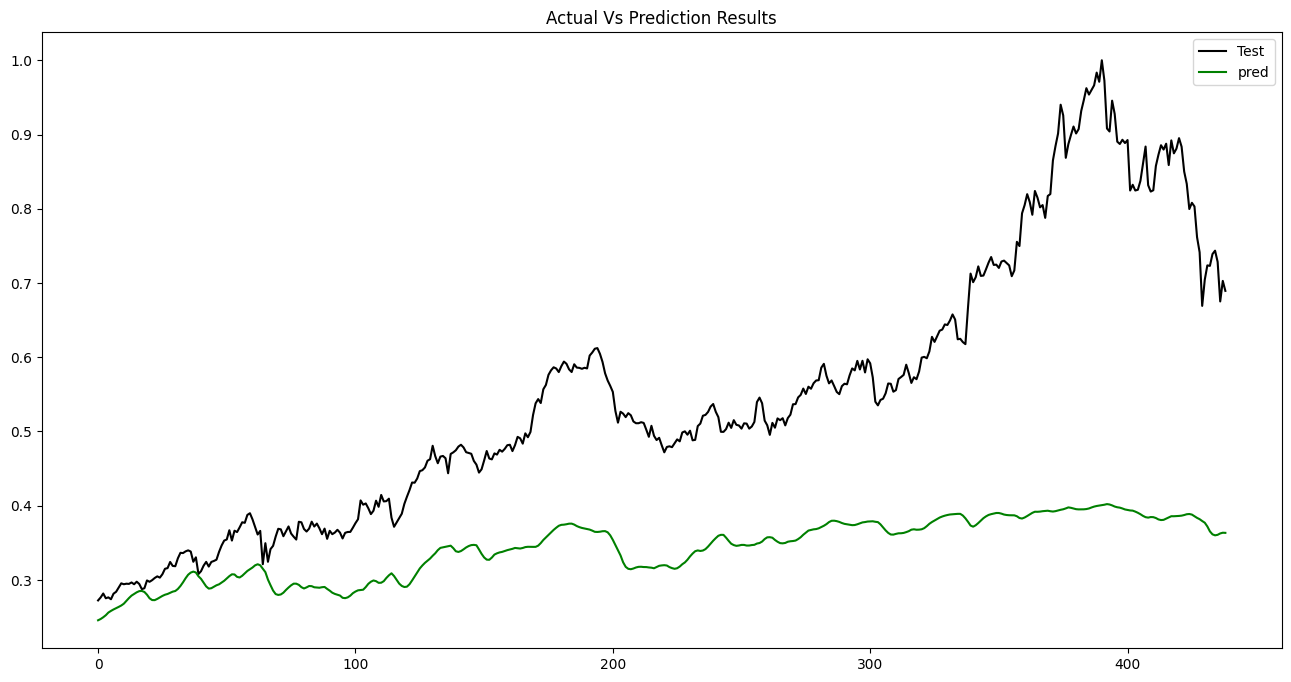

############################################################################
  Model Setup:
                    Name: ADM_F100_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.22380188735597706
             mean_sqr_err =0.07213085647591357
        root_mean_sqr_err =0.2685718832564451
           pred_diff_mean =0.6345698378574202
      pred_diff_bias_mean =0.3654301621425799
    pred_correctness_mean =0.4328018223234624



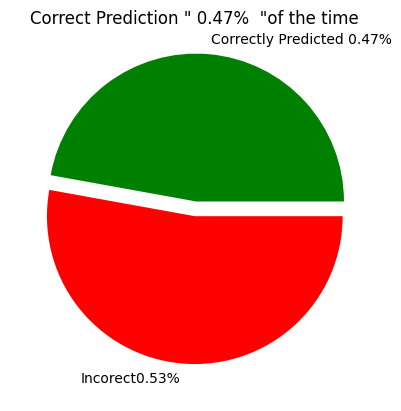

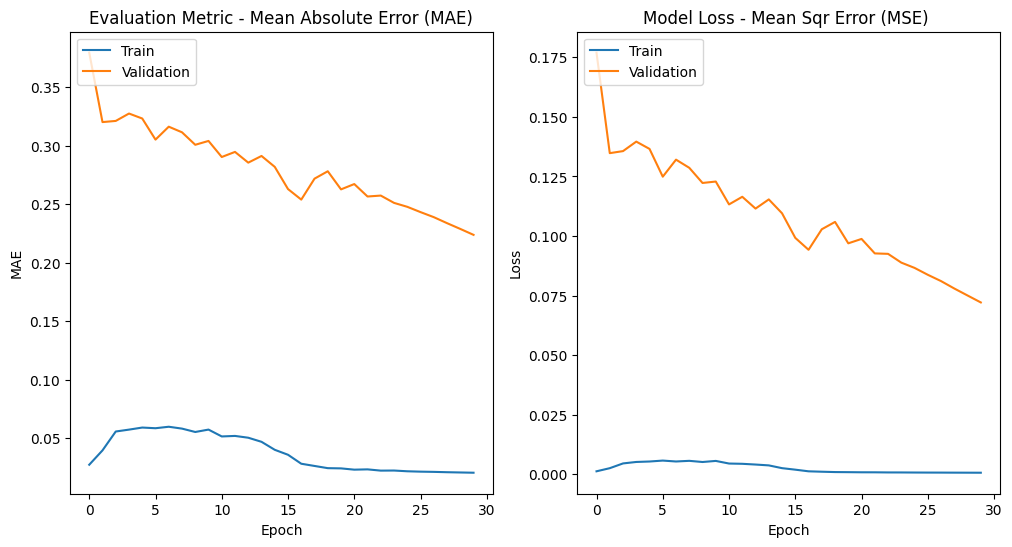

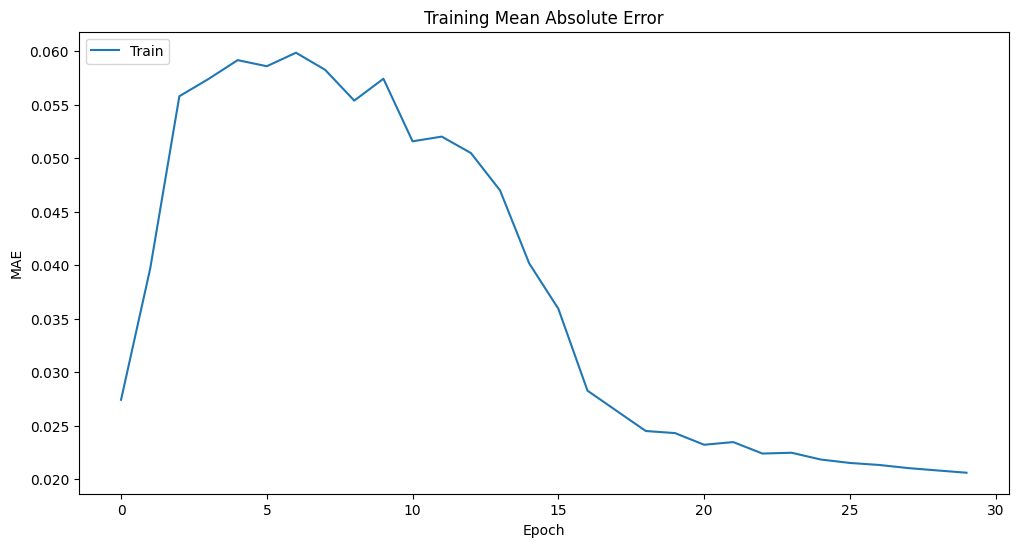

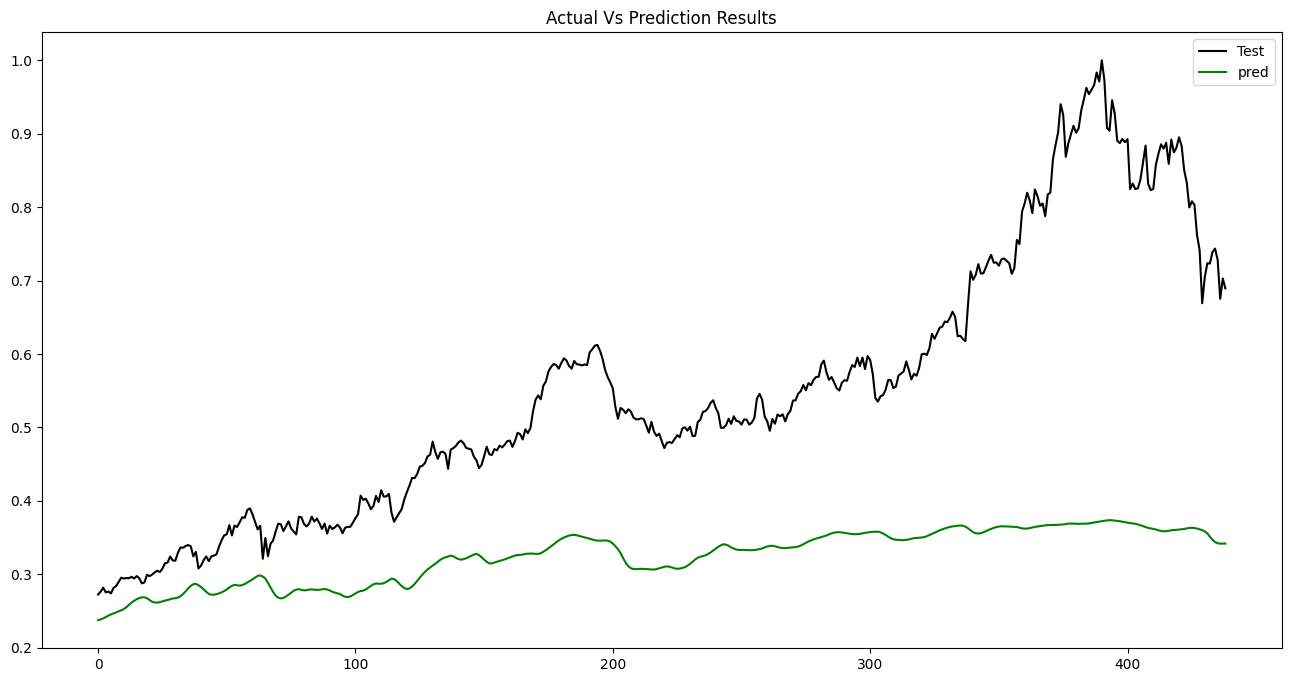

############################################################################
  Model Setup:
                    Name: ADM_F100_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: ADM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.3086057740845462
             mean_sqr_err =0.12746049243556085
        root_mean_sqr_err =0.3570160954852888
           pred_diff_mean =0.4854711814075655
      pred_diff_bias_mean =0.5145288185924345
    pred_correctness_mean =0.27107061503416857



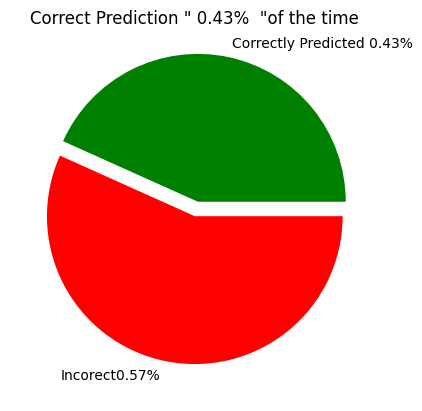

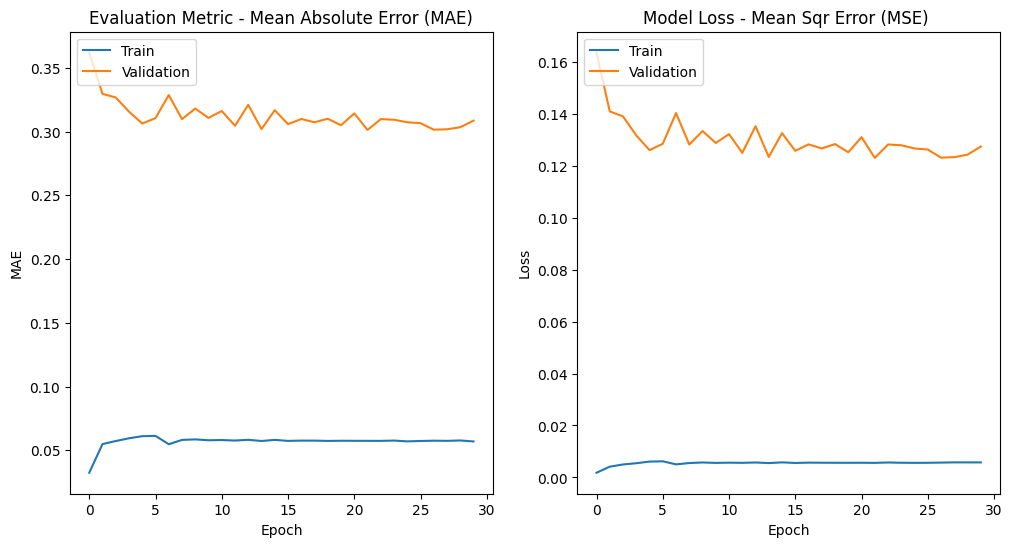

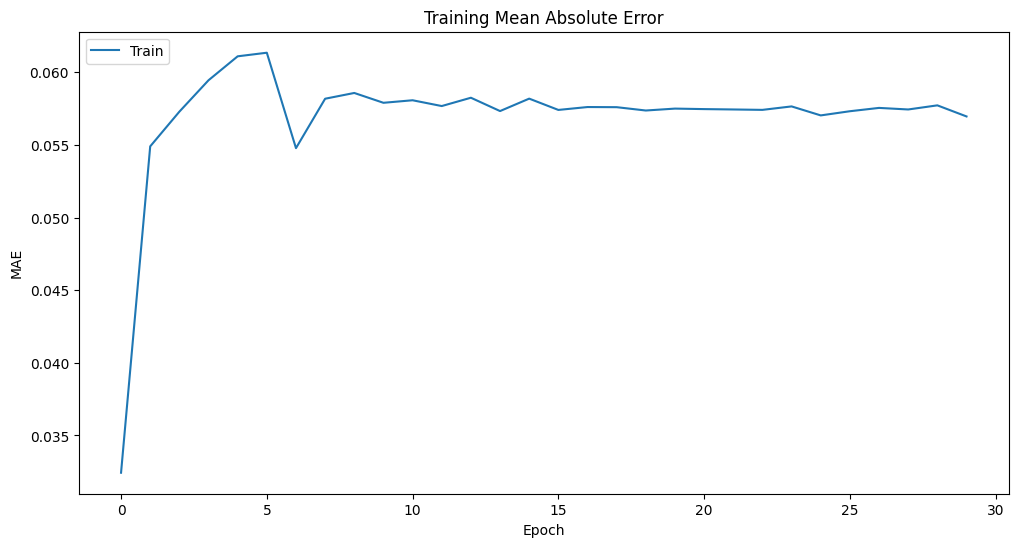

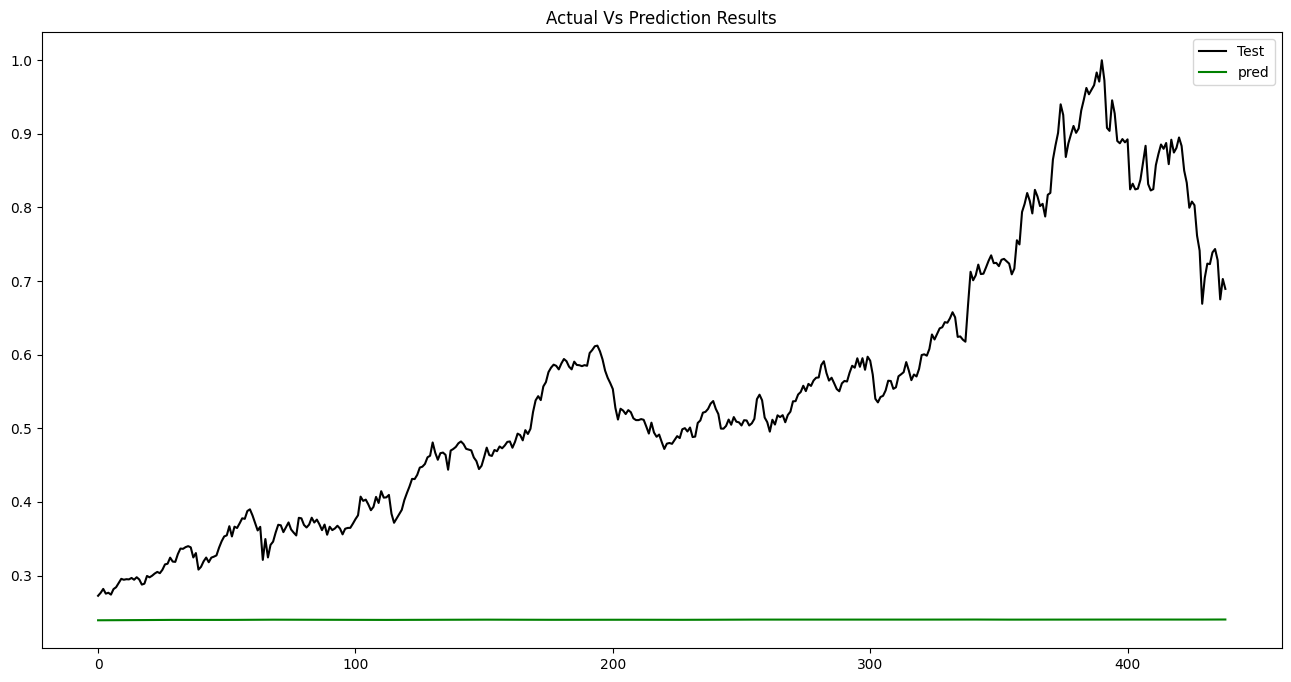

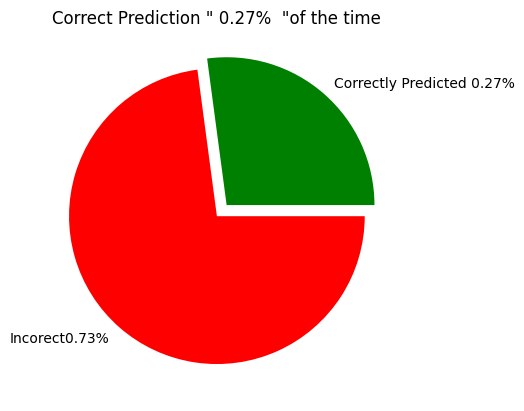

In [44]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [45]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive